Lab-project - Data Science for Business, Università degli Studi dell'Insubria.  

Ad opera di D. Gabriele  



L'obiettivo del progetto è analizzare l'andamento del mercato del lavoro in Lombardia osservando le attivazioni e cessazioni di contratti durante nell'intervallo temporale intercorrente tra il 2010 e il 2021. L'idea contempla un confronto tra i settori trainanti per l'economia della regione Lombardia con particolare attenzione sul settore della ristorazione.  
  
  
SOMMARIO:  



1. - Raccolta dati dal sito ufficiale della Regione Lombardia e dalla sitlogia dell'Istat         

2. - Ispezione dei dataset e considerazioni  

3. - Pulizia dei dataset, correzione dei dati e trasformazione  

4. - Visualizzazione dei dati, considerazioni e confronto tra le statistiche dei lavori cessati e attivati nei settori più importanti per fequenza di attivazione/cessazione contratti.   

5. - Analisi temporale e preparazione dei dati per l'implementazione di un modello di predittività che consideri andamento del mercato lavorativo su attivazioni e cessazioni  

6. - Applicazione di modelli predittivi (AUTO ARIMA) sulle time series di contratti attivati e cessati  

7. - Studio del settore relativo alla ristorazione e considerazioni sui risultati di differenti modelli di forecasting

----

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists
import requests
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from utils.metrics import evaluate


import pickle
import warnings
from math import sqrt

import matplotlib as mpl

import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

#Importing libraries


1. - RACCOLTA DATI DAL SITO UFFICIALE DELLA REGIONE LOMBARDIA E DA SITOLOGIA ISTAT

In [2]:
if not exists('Rapporti_di_lavoro_attivati.csv'):
    file = requests.get("https://dati.lombardia.it/api/views/qbau-cyuc/rows.csv?accessType=DOWNLOAD", allow_redirects=True)
    open('Rapporti_di_lavoro_attivati.csv', 'wb').write(file.content)

if not exists('Rapporti_di_lavoro_cessati.csv'):
    file = requests.get("https://dati.lombardia.it/api/views/nwz3-p6vm/rows.csv?accessType=DOWNLOAD", allow_redirects=True)
    open('Rapporti_di_lavoro_cessati.csv', 'wb').write(file.content)

In [3]:
attivati = pd.read_csv('Rapporti_di_lavoro_attivati.csv')
cessati = pd.read_csv('Rapporti_di_lavoro_cessati.csv')
pil = pd.read_csv('PilRegioniIta.csv', encoding = 'latin')

----

2. - ISPEZIONE DEI DATASET E CONSIDERAZIONI :  

         Analisi del dataset relativo al PIL

In [6]:
pil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Anno                    105 non-null    int64 
 1   Regioni                 105 non-null    object
 2   P.I.L. Milioni di Euro  105 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ KB


In [7]:
pil.head()

Anno         Regioni  P.I.L. Milioni di Euro
0  2000  Emilia Romagna                  106154
1  2000           Lazio                  138118
2  2000       Lombardia                  259861
3  2000        Piemonte                   99693
4  2000          Veneto                  111462

2. - ISPEZIONE DEI DATASET E CONSIDERAZIONI :  

         Analisi del dataset relativo alle attivazioni dei contratti in Lombardia

In [4]:
attivati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        int64 
 3   SETTOREECONOMICODETTAGLIO  object
 4   TITOLOSTUDIO               object
 5   CONTRATTO                  object
 6   MODALITALAVORO             object
 7   PROVINCIAIMPRESA           object
 8   ITALIANO                   object
dtypes: int64(1), object(8)
memory usage: 657.8+ MB


In [ ]:
attivati.head()

2. - ISPEZIONE DEI DATASET E CONSIDERAZIONI :  

         Analisi del dataset relativo alle terminazioni dei contratti in Lombardia

In [5]:
cessati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741394 entries, 0 to 3741393
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        int64 
 3   SETTOREECONOMICODETTAGLIO  object
 4   TITOLOSTUDIO               object
 5   CONTRATTO                  object
 6   MODALITALAVORO             object
 7   PROVINCIAIMPRESA           object
 8   ITALIANO                   object
dtypes: int64(1), object(8)
memory usage: 256.9+ MB


In [ ]:
cessati.head()

2. - ISPEZIONE DEI DATASET E CONSIDERAZIONI :  

         Conversione dei record che rappresentano le date nei dataset in 'datetime' per garantire una manipolazione 
         qualitativamente migliore



In [8]:
attivati.loc[:,'DATA'] = pd.to_datetime(attivati.loc[:,'DATA'], format="%d/%m/%Y", errors='coerce')
cessati.loc[:,'DATA'] = pd.to_datetime(cessati.loc[:,'DATA'], format="%d/%m/%Y", errors='coerce')
pil.loc[:,'Anno'] = pd.to_datetime(pil.loc[:,'Anno'], format='%Y', errors='coerce')

------

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Si può notare che il dataset relativo al PIL contiene informazioni su regioni al di fuori della lombardia. L'obiettivo dell'analisi si focalizza sulle osservazioni del PIL Lombardo.

In [9]:
pil

Anno         Regioni  P.I.L. Milioni di Euro
0   2000-01-01  Emilia Romagna                  106154
1   2000-01-01           Lazio                  138118
2   2000-01-01       Lombardia                  259861
3   2000-01-01        Piemonte                   99693
4   2000-01-01          Veneto                  111462
..         ...             ...                     ...
100 2020-01-01           Lazio                  186298
101 2020-01-01       Lombardia                  365515
102 2020-01-01        Piemonte                  126199
103 2020-01-01          Veneto                  151910
104 2021-01-01       Lombardia                  391101

[105 rows x 3 columns]

In [10]:
prov = pil.iloc[:-1]

In [11]:
prov.head(10)

Anno         Regioni  P.I.L. Milioni di Euro
0 2000-01-01  Emilia Romagna                  106154
1 2000-01-01           Lazio                  138118
2 2000-01-01       Lombardia                  259861
3 2000-01-01        Piemonte                   99693
4 2000-01-01          Veneto                  111462
5 2001-01-01  Emilia Romagna                  110741
6 2001-01-01           Lazio                  146723
7 2001-01-01       Lombardia                  273359
8 2001-01-01        Piemonte                  104026
9 2001-01-01          Veneto                  115853

<AxesSubplot:xlabel='Anno', ylabel='P.I.L. Milioni di Euro'>

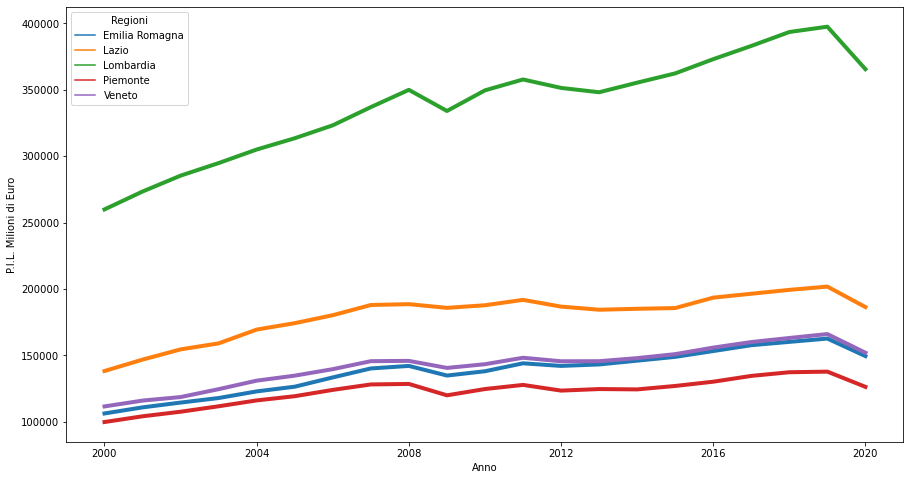

In [12]:
plt.figure(figsize=(15,8))
sns.lineplot(data=prov, x='Anno',y='P.I.L. Milioni di Euro', hue='Regioni',linewidth = 4.0) #show PIL for each major region

In [13]:
pil.isnull().sum() #no null values check

Anno                      0
Regioni                   0
P.I.L. Milioni di Euro    0
dtype: int64

In [14]:
#remove regions that are not 'lombardia', because our study revolves around the Lombardia records
pil = pil[pil['Regioni'] == 'Lombardia']
pil = pil.loc[:, ['Anno', 'P.I.L. Milioni di Euro',]] #we remove the Regioni attribute because we only have Lombardia wich is a obvious information

In [16]:
pil

Anno  P.I.L. Milioni di Euro
2   2000-01-01                  259861
7   2001-01-01                  273359
12  2002-01-01                  285312
17  2003-01-01                  294774
22  2004-01-01                  304987
27  2005-01-01                  313488
32  2006-01-01                  323238
37  2007-01-01                  336926
42  2008-01-01                  349924
47  2009-01-01                  334011
52  2010-01-01                  349558
57  2011-01-01                  357748
62  2012-01-01                  351390
67  2013-01-01                  348117
72  2014-01-01                  355347
77  2015-01-01                  362330
82  2016-01-01                  373038
87  2017-01-01                  383033
91  2018-01-01                  393500
96  2019-01-01                  397507
101 2020-01-01                  365515
104 2021-01-01                  391101

In [17]:
pil.info() #correctly converted to dateTime

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 2 to 104
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Anno                    22 non-null     datetime64[ns]
 1   P.I.L. Milioni di Euro  22 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 528.0 bytes


In [18]:
pil.index = pil.Anno
pilgg = pil.copy()

In [20]:
pilgg.index = pd.DatetimeIndex(pilgg['Anno']).year #year as index to perform operations on dates and ts analyisi

In [48]:
pilgg2 = pilgg.copy()
pilgg2.drop(columns='Anno', inplace = True)
pilgg2

P.I.L. Milioni di Euro
Anno                        
2000                  259861
2001                  273359
2002                  285312
2003                  294774
2004                  304987
2005                  313488
2006                  323238
2007                  336926
2008                  349924
2009                  334011
2010                  349558
2011                  357748
2012                  351390
2013                  348117
2014                  355347
2015                  362330
2016                  373038
2017                  383033
2018                  393500
2019                  397507
2020                  365515
2021                  391101

In [ ]:
kwsne = dict(marker='o')
pilgg2.plot(figsize =(15,6),**kwsne, linewidth = 3.0)

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Analisi e null value inspection dei dataset maggiori: contratti attivati in Lombardia

In [22]:
attivati

DATA GENERE  ETA  \
0       2020-05-09      F   60   
1       2019-07-12      M   43   
2       2013-06-05      F   20   
3       2010-03-12      F   28   
4       2021-04-06      F   49   
...            ...    ...  ...   
9579789 2020-03-01      M   52   
9579790 2010-09-06      M   61   
9579791 2021-11-06      M   37   
9579792 2010-02-02      M   35   
9579793 2012-07-05      F   39   

                                 SETTOREECONOMICODETTAGLIO  \
0        Attività di famiglie e convivenze come datori ...   
1        Gestioni di funicolari, ski-lift e seggiovie s...   
2        Fabbricazione di altre apparecchiature elettri...   
3                                                 Alberghi   
4                                       Rifugi di montagna   
...                                                    ...   
9579789                       Lavori di meccanica generale   
9579790                       Lavori di meccanica generale   
9579791  Fabbricazione di parti ed accessori per bicicl...   
9579792  Fabbricazione di parti ed accessori per bicicl...   
9579793  Commercio all'ingrosso di abbigliamento e acce...   

                                              TITOLOSTUDIO  \
0                                  NESSUN TITOLO DI STUDIO   
1                                            LICENZA MEDIA   
2                                            LICENZA MEDIA   
3        DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
4                                            LICENZA MEDIA   
...                                                    ...   
9579789                                      LICENZA MEDIA   
9579790                            NESSUN TITOLO DI STUDIO   
9579791                            NESSUN TITOLO DI STUDIO   
9579792                                      LICENZA MEDIA   
9579793                                      LICENZA MEDIA   

                                                 CONTRATTO MODALITALAVORO  \
0                                         LAVORO DOMESTICO    TEMPO PIENO   
1                               LAVORO A TEMPO DETERMINATO    TEMPO PIENO   
2        APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...    TEMPO PIENO   
3                 LAVORO INTERMITTENTE A TEMPO DETERMINATO   NON DEFINITO   
4                                     LAVORO INTERMITTENTE   NON DEFINITO   
...                                                    ...            ...   
9579789                         LAVORO A TEMPO DETERMINATO    TEMPO PIENO   
9579790                       LAVORO A TEMPO INDETERMINATO    TEMPO PIENO   
9579791                         LAVORO A TEMPO DETERMINATO    TEMPO PIENO   
9579792  LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...    TEMPO PIENO   
9579793  LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...            NaN   

        PROVINCIAIMPRESA ITALIANO  
0                BERGAMO  UCRAINA  
1                BERGAMO   ITALIA  
2                BERGAMO   ITALIA  
3                BERGAMO   ITALIA  
4                BERGAMO   ITALIA  
...                  ...      ...  
9579789          BERGAMO   ITALIA  
9579790          BERGAMO  ALBANIA  
9579791          BERGAMO  SENEGAL  
9579792          BERGAMO  SENEGAL  
9579793          BERGAMO   ITALIA  

[9579794 rows x 9 columns]

In [23]:
copia = attivati.copy() #copy for activation dataset


<AxesSubplot:>

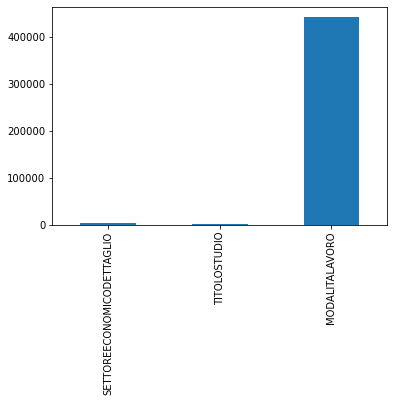

In [24]:
copia.isna().sum()[copia.isna().sum()>0].plot(kind='bar') #null values insection for activated contracts

In [25]:
len(copia)

9579794

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Analisi e null value inspection dei dataset maggiori: contratti cessati in Lombardia

In [ ]:
aipoc= cessati.copy() #copy for terminated dataset
aipoc

<AxesSubplot:>

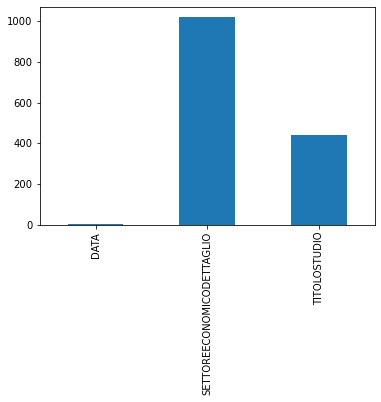

In [26]:
aipoc.isna().sum()[aipoc.isna().sum()>0].plot(kind='bar') #null values inspection for terminated contracts

In [27]:
len(aipoc)

3741394

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         I dataset presentano delle inconsistenze; le quantità maggiori di null values si contano negli attributi 'titolo di studio', 'modalità di lavoro' e 'settore economicodettaglio'.
         La nostra analisi tuttavia ignora i dati relativi alla modalità di lavoro, al titolo di studio, alla nazionalità e alla provincia, pertanto possiamo eliminare le colonne relative ai suddetti dati.


In [28]:
copia.drop(columns = ['MODALITALAVORO', 'TITOLOSTUDIO', 'ITALIANO', 'PROVINCIAIMPRESA'], inplace = True)
aipoc.drop(columns=['MODALITALAVORO', 'TITOLOSTUDIO', 'ITALIANO', 'PROVINCIAIMPRESA'], inplace = True)

In [29]:
copia.isnull().sum()

DATA                            0
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    2888
CONTRATTO                       0
dtype: int64

In [30]:
aipoc.isnull().sum()

DATA                            1
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    1019
CONTRATTO                       0
dtype: int64

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         
         Possiamo notare che in entrambi i casi 'SETTOREECONOMICODETTAGLIO' ha una quantità discreta di valori nulli, quindi dobbiamo occuparcene senza modificare troppo le statistiche. Reminder: abbiamo bisogno di dati relativi al 'SETTOREECONOMICODETTAGLIO'.
         Si noti che i valori nulli di 'SETTOREECONOMICODETTAGLIO' sono 2888/9579794, pari a circa lo 0,03% del dataset per i contratti attivati, e 1019/3741394, pari a circa lo 0,027% del dataset.
         Possiamo rimuoverli senza bisogno di interpolazioni.

In [31]:
copia.dropna(inplace=True)
aipoc.dropna(inplace=True)

In [32]:
copia.isnull().sum() #null value check after cleaning the activated contracts dataset

DATA                         0
GENERE                       0
ETA                          0
SETTOREECONOMICODETTAGLIO    0
CONTRATTO                    0
dtype: int64

In [33]:
aipoc.isnull().sum() #null value check after cleaning the terminated contracts dataset

DATA                         0
GENERE                       0
ETA                          0
SETTOREECONOMICODETTAGLIO    0
CONTRATTO                    0
dtype: int64

In [34]:
copia.index = copia['DATA']
aipoc.index = aipoc['DATA']
#creation of a new column for the major datasets with copy of date

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  


         Creazione dell'attributo 'STATO' per l'identificazione di contratti attivati o cessati in vista del merging dei dataset

In [39]:
copiafilt = copia.copy()
copiafilt['STATO'] = 1
copiafilt

In [41]:
aipocfilt = aipoc.copy()
aipocfilt['STATO'] = 0
aipocfilt

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Merge dei dataset maggiori

In [43]:
dFrames = [copiafilt,aipocfilt]
unifDf = pd.concat(dFrames)
#merge of the two dataset in one; the datasets have the same attributes so it will be easier to do filtering and cleaning operations once they have been merged together

In [44]:
unifDf

DATA GENERE  ETA  \
DATA                                
2020-05-09 2020-05-09      F   60   
2019-07-12 2019-07-12      M   43   
2013-06-05 2013-06-05      F   20   
2010-03-12 2010-03-12      F   28   
2021-04-06 2021-04-06      F   49   
...               ...    ...  ...   
2018-11-05 2018-11-05      M   19   
2017-04-09 2017-04-09      M   67   
2015-05-08 2015-05-08      M   59   
2016-10-10 2016-10-10      M   26   
2018-10-09 2018-10-09      M   45   

                                    SETTOREECONOMICODETTAGLIO  \
DATA                                                            
2020-05-09  Attività di famiglie e convivenze come datori ...   
2019-07-12  Gestioni di funicolari, ski-lift e seggiovie s...   
2013-06-05  Fabbricazione di altre apparecchiature elettri...   
2010-03-12                                           Alberghi   
2021-04-06                                 Rifugi di montagna   
...                                                       ...   
2018-11-05  Fabbricazione di altri elementi in legno e di ...   
2017-04-09  Altra istruzione secondaria di secondo grado d...   
2015-05-08  Costruzione di edifici residenziali e non resi...   
2016-10-10  Installazione di altre macchine ed apparecchia...   
2018-10-09  Fabbricazione di strutture metalliche e parti ...   

                                                    CONTRATTO  STATO  
DATA                                                                  
2020-05-09                                   LAVORO DOMESTICO      1  
2019-07-12                         LAVORO A TEMPO DETERMINATO      1  
2013-06-05  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...      1  
2010-03-12           LAVORO INTERMITTENTE A TEMPO DETERMINATO      1  
2021-04-06                               LAVORO INTERMITTENTE      1  
...                                                       ...    ...  
2018-11-05                         LAVORO A TEMPO DETERMINATO      0  
2017-04-09                       LAVORO A TEMPO INDETERMINATO      0  
2015-05-08                       LAVORO A TEMPO INDETERMINATO      0  
2016-10-10                       LAVORO A TEMPO INDETERMINATO      0  
2018-10-09                       LAVORO A TEMPO INDETERMINATO      0  

[13317280 rows x 6 columns]

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Trasformazione ed encoding delle variabili

In [45]:
unifDf.loc[(unifDf['GENERE'] == 'M'), 'GENERE'] = 1
unifDf.loc[(unifDf['GENERE'] == 'F'), 'GENERE'] = 0
copiaEpic = unifDf
copiaEpic
#genere to 1 for males and 0 for females

In [47]:
copiaEpicFilt = copiaEpic.copy()

In [49]:
copiaEpicFilt['Mese'] = copiaEpicFilt['DATA'].dt.month
copiaEpicFilt['Anno'] = copiaEpicFilt['DATA'].dt.year
#estrapolating year and month from the dates

In [50]:
copiaEpicFilt

DATA GENERE  ETA  \
DATA                                
2020-05-09 2020-05-09      0   60   
2019-07-12 2019-07-12      1   43   
2013-06-05 2013-06-05      0   20   
2010-03-12 2010-03-12      0   28   
2021-04-06 2021-04-06      0   49   
...               ...    ...  ...   
2018-11-05 2018-11-05      1   19   
2017-04-09 2017-04-09      1   67   
2015-05-08 2015-05-08      1   59   
2016-10-10 2016-10-10      1   26   
2018-10-09 2018-10-09      1   45   

                                    SETTOREECONOMICODETTAGLIO  \
DATA                                                            
2020-05-09  Attività di famiglie e convivenze come datori ...   
2019-07-12  Gestioni di funicolari, ski-lift e seggiovie s...   
2013-06-05  Fabbricazione di altre apparecchiature elettri...   
2010-03-12                                           Alberghi   
2021-04-06                                 Rifugi di montagna   
...                                                       ...   
2018-11-05  Fabbricazione di altri elementi in legno e di ...   
2017-04-09  Altra istruzione secondaria di secondo grado d...   
2015-05-08  Costruzione di edifici residenziali e non resi...   
2016-10-10  Installazione di altre macchine ed apparecchia...   
2018-10-09  Fabbricazione di strutture metalliche e parti ...   

                                                    CONTRATTO  STATO  Mese  \
DATA                                                                         
2020-05-09                                   LAVORO DOMESTICO      1     5   
2019-07-12                         LAVORO A TEMPO DETERMINATO      1     7   
2013-06-05  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...      1     6   
2010-03-12           LAVORO INTERMITTENTE A TEMPO DETERMINATO      1     3   
2021-04-06                               LAVORO INTERMITTENTE      1     4   
...                                                       ...    ...   ...   
2018-11-05                         LAVORO A TEMPO DETERMINATO      0    11   
2017-04-09                       LAVORO A TEMPO INDETERMINATO      0     4   
2015-05-08                       LAVORO A TEMPO INDETERMINATO      0     5   
2016-10-10                       LAVORO A TEMPO INDETERMINATO      0    10   
2018-10-09                       LAVORO A TEMPO INDETERMINATO      0    10   

            Anno  
DATA              
2020-05-09  2020  
2019-07-12  2019  
2013-06-05  2013  
2010-03-12  2010  
2021-04-06  2021  
...          ...  
2018-11-05  2018  
2017-04-09  2017  
2015-05-08  2015  
2016-10-10  2016  
2018-10-09  2018  

[13317280 rows x 8 columns]

In [51]:
mergedData = pd.merge(copiaEpicFilt, pilgg2, how = 'inner', on = 'Anno')
#merging dataframes with pil dataset

In [52]:
mergedData

DATA GENERE  ETA  \
0        2020-05-09      0   60   
1        2020-03-07      1   37   
2        2020-01-06      1   28   
3        2020-06-03      1   55   
4        2020-05-08      0   28   
...             ...    ...  ...   
13317240 2000-02-03      1   42   
13317241 2000-09-06      0   31   
13317242 2000-03-01      0   46   
13317243 2000-01-07      1   38   
13317244 2000-11-09      0   58   

                                  SETTOREECONOMICODETTAGLIO  \
0         Attività di famiglie e convivenze come datori ...   
1         Costruzione di strade, autostrade e piste aero...   
2         Costruzione di strade, autostrade e piste aero...   
3                  Bar e altri esercizi simili senza cucina   
4                  Bar e altri esercizi simili senza cucina   
...                                                     ...   
13317240  Attività di famiglie e convivenze come datori ...   
13317241  Attività di famiglie e convivenze come datori ...   
13317242  Attività di famiglie e convivenze come datori ...   
13317243  Attività di famiglie e convivenze come datori ...   
13317244  Attività di famiglie e convivenze come datori ...   

                                       CONTRATTO  STATO  Mese  Anno  \
0                               LAVORO DOMESTICO      1     5  2020   
1                     LAVORO A TEMPO DETERMINATO      1     3  2020   
2                     LAVORO A TEMPO DETERMINATO      1     1  2020   
3                     LAVORO A TEMPO DETERMINATO      1     6  2020   
4                           LAVORO INTERMITTENTE      1     5  2020   
...                                          ...    ...   ...   ...   
13317240  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     2  2000   
13317241  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     9  2000   
13317242  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     3  2000   
13317243  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     1  2000   
13317244  LAVORO DOMESTICO A TEMPO INDETERMINATO      0    11  2000   

          P.I.L. Milioni di Euro  
0                         365515  
1                         365515  
2                         365515  
3                         365515  
4                         365515  
...                          ...  
13317240                  259861  
13317241                  259861  
13317242                  259861  
13317243                  259861  
13317244                  259861  

[13317245 rows x 9 columns]

In [53]:
mergedDataCopy = mergedData.copy()

In [54]:
mergedDataCopy.sort_values('DATA', inplace=True)

In [55]:
mergedDataCopy.index = mergedDataCopy['DATA']

In [56]:
mergedDataCopy.rename(columns = {'DATA':'DATE','SETTOREECONOMICODETTAGLIO' : 'SETTORE',
                                 'Mese' : 'MESE', 'Anno' : 'ANNO', 'P.I.L. Milioni di Euro' : 'PIL MLN EUR ANNUO' }, inplace=True)

In [57]:
transField = LabelEncoder().fit_transform(mergedDataCopy.SETTORE)
transCon = LabelEncoder().fit_transform(mergedDataCopy.CONTRATTO)
mergedDataCopy['SETT_ID'] = transField
mergedDataCopy['CONTR_N'] = transCon
mergedDataCopy.head()

DATE GENERE  ETA  \
DATA                                
2000-01-07 2000-01-07      1   38   
2000-02-03 2000-02-03      1   42   
2000-03-01 2000-03-01      0   46   
2000-09-06 2000-09-06      0   31   
2000-11-09 2000-11-09      0   58   

                                                      SETTORE  \
DATA                                                            
2000-01-07  Attività di famiglie e convivenze come datori ...   
2000-02-03  Attività di famiglie e convivenze come datori ...   
2000-03-01  Attività di famiglie e convivenze come datori ...   
2000-09-06  Attività di famiglie e convivenze come datori ...   
2000-11-09  Attività di famiglie e convivenze come datori ...   

                                         CONTRATTO  STATO  MESE  ANNO  \
DATA                                                                    
2000-01-07  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     1  2000   
2000-02-03  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     2  2000   
2000-03-01  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     3  2000   
2000-09-06  LAVORO DOMESTICO A TEMPO INDETERMINATO      0     9  2000   
2000-11-09  LAVORO DOMESTICO A TEMPO INDETERMINATO      0    11  2000   

            PIL MLN EUR ANNUO  SETT_ID  CONTR_N  
DATA                                             
2000-01-07             259861      188       34  
2000-02-03             259861      188       34  
2000-03-01             259861      188       34  
2000-09-06             259861      188       34  
2000-11-09             259861      188       34

In [58]:
columns_titles = ['CONTRATTO','CONTR_N', 'SETTORE', 'SETT_ID' , 'STATO',
                  'ETA', 'GENERE', 'DATE', 'MESE', 'ANNO', 'PIL MLN EUR ANNUO']
mergedDataCopy = mergedDataCopy.reindex(columns=columns_titles)
mergedDataCopy
#reordering the dataset

In [60]:
dfOrdinato = mergedDataCopy.copy()
dfOrdinato

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Controllo e pulizia dei dati inconsistenti ed outliers

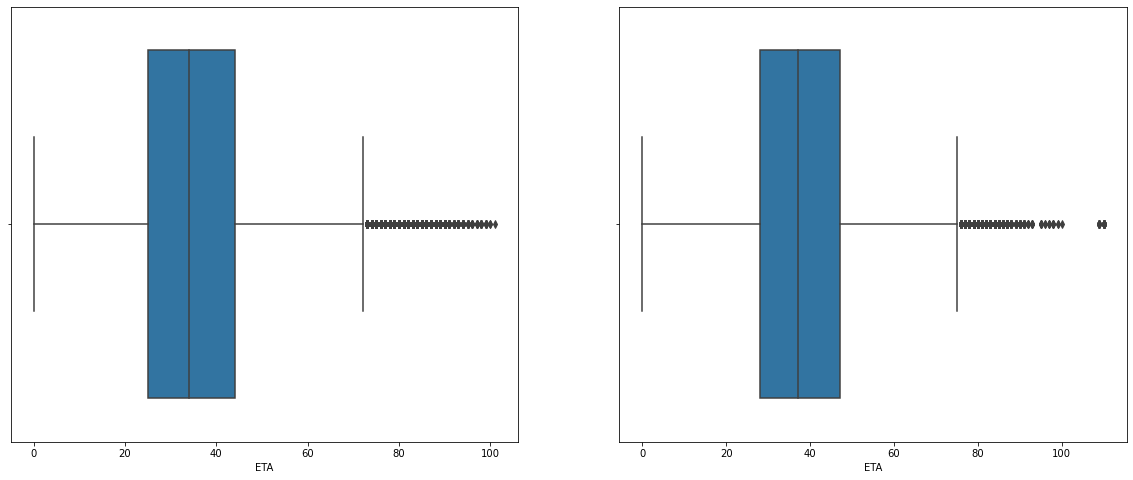

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x = dfOrdinato['ETA'].loc[dfOrdinato['STATO'] == 1], ax=ax1)
sns.boxplot(x = dfOrdinato['ETA'].loc[dfOrdinato['STATO'] == 0], ax=ax2)
plt.show()
#lets clean age. We have ages that are not particoularly suitable for our analysis

In [63]:
etaDaDropp = dfOrdinato[(dfOrdinato.ETA >= 18) & (dfOrdinato.ETA <= 67) &
                        (dfOrdinato['DATE'].dt.year>2009 ) & (dfOrdinato['DATE'].dt.year<2022)]
#range di interesse di età per un contratto lavorativo che possa essere rilevante nella media legale
#range di interesse per anni in cui la digitalizzazione e i social hanno incominciato a segnare un'evoluzione nel mondo del lavoro

In [64]:
etaDaDropp

CONTRATTO  CONTR_N  \
DATA                                                                     
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
2010-01-01           LAVORO A DOMICILIO A TEMPO INDETERMINATO       23   
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
2010-01-01                       LAVORO A TEMPO INDETERMINATO       27   
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
...                                                       ...      ...   
2021-12-09                       LAVORO A TEMPO INDETERMINATO       27   
2021-12-09  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...        8   
2021-12-09                         LAVORO A TEMPO DETERMINATO       25   
2021-12-09                       LAVORO A TEMPO INDETERMINATO       27   
2021-12-09                         LAVORO A TEMPO DETERMINATO       25   

                                                      SETTORE  SETT_ID  STATO  \
DATA                                                                            
2010-01-01  Cura e manutenzione del paesaggio (inclusi par...      502      1   
2010-01-01           Preparazione e filatura di fibre tessili      965      0   
2010-01-01                   Attività che seguono la raccolta      134      1   
2010-01-01         Altri servizi di supporto alle imprese nca      123      1   
2010-01-01                   Attività che seguono la raccolta      134      1   
...                                                       ...      ...    ...   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      0   
2021-12-09  Altre attività di consulenza imprenditoriale e...       88      1   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      1   
2021-12-09  Commercio all'ingrosso di altri materiali da c...      374      1   
2021-12-09  Attività di produzione cinematografica, di vid...      207      1   

            ETA GENERE       DATE  MESE  ANNO  PIL MLN EUR ANNUO  
DATA                                                              
2010-01-01   44      0 2010-01-01     1  2010             349558  
2010-01-01   60      0 2010-01-01     1  2010             349558  
2010-01-01   33      1 2010-01-01     1  2010             349558  
2010-01-01   28      1 2010-01-01     1  2010             349558  
2010-01-01   54      1 2010-01-01     1  2010             349558  
...         ...    ...        ...   ...   ...                ...  
2021-12-09   39      1 2021-12-09    12  2021             391101  
2021-12-09   29      1 2021-12-09    12  2021             391101  
2021-12-09   24      1 2021-12-09    12  2021             391101  
2021-12-09   39      1 2021-12-09    12  2021             391101  
2021-12-09   47      0 2021-12-09    12  2021             391101  

[12606817 rows x 11 columns]

In [65]:
cleanData = etaDaDropp.copy()

In [66]:
dfOrdAtt = cleanData.loc[cleanData['STATO'] == 1]
dfOrdCess = cleanData.loc[cleanData['STATO'] == 0]
#grouping activated and terminated contracts to perform analysis

In [67]:
dfOrdAtt

CONTRATTO  CONTR_N  \
DATA                                                                     
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
2010-01-01                       LAVORO A TEMPO INDETERMINATO       27   
2010-01-01                         LAVORO A TEMPO DETERMINATO       25   
2010-01-01                       LAVORO A TEMPO INDETERMINATO       27   
...                                                       ...      ...   
2021-12-09                       LAVORO A TEMPO INDETERMINATO       27   
2021-12-09  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...        8   
2021-12-09                         LAVORO A TEMPO DETERMINATO       25   
2021-12-09                       LAVORO A TEMPO INDETERMINATO       27   
2021-12-09                         LAVORO A TEMPO DETERMINATO       25   

                                                      SETTORE  SETT_ID  STATO  \
DATA                                                                            
2010-01-01  Cura e manutenzione del paesaggio (inclusi par...      502      1   
2010-01-01                   Attività che seguono la raccolta      134      1   
2010-01-01         Altri servizi di supporto alle imprese nca      123      1   
2010-01-01                   Attività che seguono la raccolta      134      1   
2010-01-01         Altri servizi di supporto alle imprese nca      123      1   
...                                                       ...      ...    ...   
2021-12-09  Attività non specializzate di lavori edili (mu...      224      1   
2021-12-09  Altre attività di consulenza imprenditoriale e...       88      1   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      1   
2021-12-09  Commercio all'ingrosso di altri materiali da c...      374      1   
2021-12-09  Attività di produzione cinematografica, di vid...      207      1   

            ETA GENERE       DATE  MESE  ANNO  PIL MLN EUR ANNUO  
DATA                                                              
2010-01-01   44      0 2010-01-01     1  2010             349558  
2010-01-01   33      1 2010-01-01     1  2010             349558  
2010-01-01   28      1 2010-01-01     1  2010             349558  
2010-01-01   54      1 2010-01-01     1  2010             349558  
2010-01-01   34      1 2010-01-01     1  2010             349558  
...         ...    ...        ...   ...   ...                ...  
2021-12-09   38      1 2021-12-09    12  2021             391101  
2021-12-09   29      1 2021-12-09    12  2021             391101  
2021-12-09   24      1 2021-12-09    12  2021             391101  
2021-12-09   39      1 2021-12-09    12  2021             391101  
2021-12-09   47      0 2021-12-09    12  2021             391101  

[9083633 rows x 11 columns]

In [68]:
dfOrdCess

CONTRATTO  CONTR_N  \
DATA                                                            
2010-01-01  LAVORO A DOMICILIO A TEMPO INDETERMINATO       23   
2010-01-01                LAVORO A TEMPO DETERMINATO       25   
2010-01-01              LAVORO A TEMPO INDETERMINATO       27   
2010-01-01                LAVORO A TEMPO DETERMINATO       25   
2010-01-01              LAVORO A TEMPO INDETERMINATO       27   
...                                              ...      ...   
2021-12-09                          LAVORO DOMESTICO       32   
2021-12-09              LAVORO A TEMPO INDETERMINATO       27   
2021-12-09                LAVORO A TEMPO DETERMINATO       25   
2021-12-09              LAVORO A TEMPO INDETERMINATO       27   
2021-12-09              LAVORO A TEMPO INDETERMINATO       27   

                                                      SETTORE  SETT_ID  STATO  \
DATA                                                                            
2010-01-01           Preparazione e filatura di fibre tessili      965      0   
2010-01-01      Raccolta e depurazione delle acque di scarico     1046      0   
2010-01-01           Bar e altri esercizi simili senza cucina      235      0   
2010-01-01                       Trasporto di merci su strada     1203      0   
2010-01-01                            Agenti di assicurazioni        5      0   
...                                                       ...      ...    ...   
2021-12-09  Attività di famiglie e convivenze come datori ...      188      0   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      0   
2021-12-09  Coltivazione di ortaggi(inclusi i meloni) in f...      262      0   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      0   
2021-12-09  Servizi logistici relativi alla distribuzione ...     1170      0   

            ETA GENERE       DATE  MESE  ANNO  PIL MLN EUR ANNUO  
DATA                                                              
2010-01-01   60      0 2010-01-01     1  2010             349558  
2010-01-01   36      1 2010-01-01     1  2010             349558  
2010-01-01   36      1 2010-01-01     1  2010             349558  
2010-01-01   31      1 2010-01-01     1  2010             349558  
2010-01-01   52      0 2010-01-01     1  2010             349558  
...         ...    ...        ...   ...   ...                ...  
2021-12-09   45      0 2021-12-09    12  2021             391101  
2021-12-09   46      1 2021-12-09    12  2021             391101  
2021-12-09   52      1 2021-12-09    12  2021             391101  
2021-12-09   25      0 2021-12-09    12  2021             391101  
2021-12-09   39      1 2021-12-09    12  2021             391101  

[3523184 rows x 11 columns]

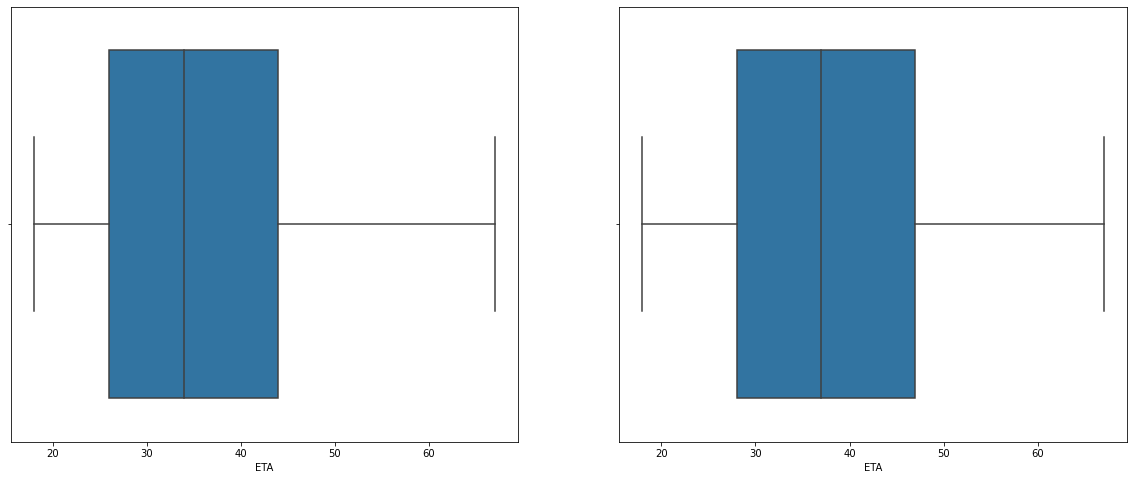

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x = dfOrdAtt['ETA'], ax=ax1)
sns.boxplot(x = dfOrdCess['ETA'], ax=ax2)
plt.show()

In [70]:
dfOrdAtt.isnull().sum()

CONTRATTO            0
CONTR_N              0
SETTORE              0
SETT_ID              0
STATO                0
ETA                  0
GENERE               0
DATE                 0
MESE                 0
ANNO                 0
PIL MLN EUR ANNUO    0
dtype: int64

In [71]:
dfOrdCess.isnull().sum()

CONTRATTO            0
CONTR_N              0
SETTORE              0
SETT_ID              0
STATO                0
ETA                  0
GENERE               0
DATE                 0
MESE                 0
ANNO                 0
PIL MLN EUR ANNUO    0
dtype: int64

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Analisi dei settori più importanti. Preparazione dei dati per costruire un dataset utile

  

In [72]:
dfOrdAtt.value_counts('SETTORE') #settori più importanti per attivazioni

SETTORE
Alberghi                                                                           437403
Ristorazione con somministrazione                                                  424929
Attività di produzione cinematografica, di video e di programmi televisivi         355267
Attività di famiglie e convivenze come datori di lavoro per personale domestico    326150
Altri servizi di supporto alle imprese nca                                         281581
                                                                                    ...  
Agenti e rappresentanti di giocattoli                                                   1
Attività delle guide alpine                                                             1
Coltivazione di fiori in colture protette fuori suolo                                   1
Allevamento di cammelli e camelidi                                                      1
Gestione di stazioni per autobus                                                        1
Le

In [74]:
aa = dfOrdAtt.groupby('SETTORE').count().sort_values(by = 'CONTRATTO', ascending=False)
aa

In [ ]:
perAtt = aa.head(10)


In [73]:
dfOrdCess.value_counts('SETTORE') #settori più importanti per cessazioni

SETTORE
Attività di famiglie e convivenze come datori di lavoro per personale domestico                                                      258683
Ristorazione con somministrazione                                                                                                    202637
Costruzione di edifici residenziali e non residenziali                                                                               171079
Pulizia generale (non specializzata) di edifici                                                                                      145277
Altri servizi di supporto alle imprese nca                                                                                           143166
                                                                                                                                      ...  
Gestione di stazioni per autobus                                                                                                          1
Fabbricazion

In [76]:
ab = dfOrdCess.groupby('SETTORE').count().sort_values(by = 'CONTRATTO', ascending=False)
ab

In [78]:
perCess = ab.head(10)

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Costruzione dei dataset per la top 10 attivazioni per contratti attivati

 

In [79]:
perAtt = perAtt.loc[:, ['STATO',]]
perAtt['CESSAZIONI'] = ab['STATO'].loc[ab.index.isin(perAtt.index.tolist())]
perAtt.rename(columns = {'STATO' : 'ATTIVAZIONI'}, inplace = True)

In [80]:
perAtt

ATTIVAZIONI  CESSAZIONI
SETTORE                                                                    
Alberghi                                                 437403       61989
Ristorazione con somministrazione                        424929      202637
Attività di produzione cinematografica, di vide...       355267        7561
Attività di famiglie e convivenze come datori d...       326150      258683
Altri servizi di supporto alle imprese nca               281581      143166
Pulizia generale (non specializzata) di edifici          252967      145277
Istruzione secondaria di primo grado: scuole medie       249435       21910
Costruzione di edifici residenziali e non resid...       223083      171079
Commercio al dettaglio di confezioni per adulti          157768       32198
Istruzione primaria: scuole elementari                   156582       12745

3. - PULIZIA DEI DATASET, CORREZIONE DEI DATI E TRASFORMAZIONE:  
  
         Costruzione dei dataset per la top 10 attivazioni per contratti cessati

 

In [81]:
perCess = perCess.loc[:, ['STATO',]]
perCess['ATTIVAZIONI'] = aa['STATO'].loc[aa.index.isin(perCess.index.tolist())]
perCess.rename(columns = {'STATO' : 'CESSAZIONI'}, inplace = True)

In [82]:
perCess

CESSAZIONI  ATTIVAZIONI
SETTORE                                                                    
Attività di famiglie e convivenze come datori d...      258683       326150
Ristorazione con somministrazione                       202637       424929
Costruzione di edifici residenziali e non resid...      171079       223083
Pulizia generale (non specializzata) di edifici         145277       252967
Altri servizi di supporto alle imprese nca              143166       281581
Trasporto di merci su strada                             86094       126545
Bar e altri esercizi simili senza cucina                 85297       149918
Servizi logistici relativi alla distribuzione d...       69199       125653
Alberghi                                                 61989       437403
Movimento merci relativo ad altri trasporti ter...       56825        75983

- - - 

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

          Visualizzazione e plot dei 10 settori più importanti per attivazioni. Il settore alberghiero e quello della
          ristorazione dominano le statistiche.
      


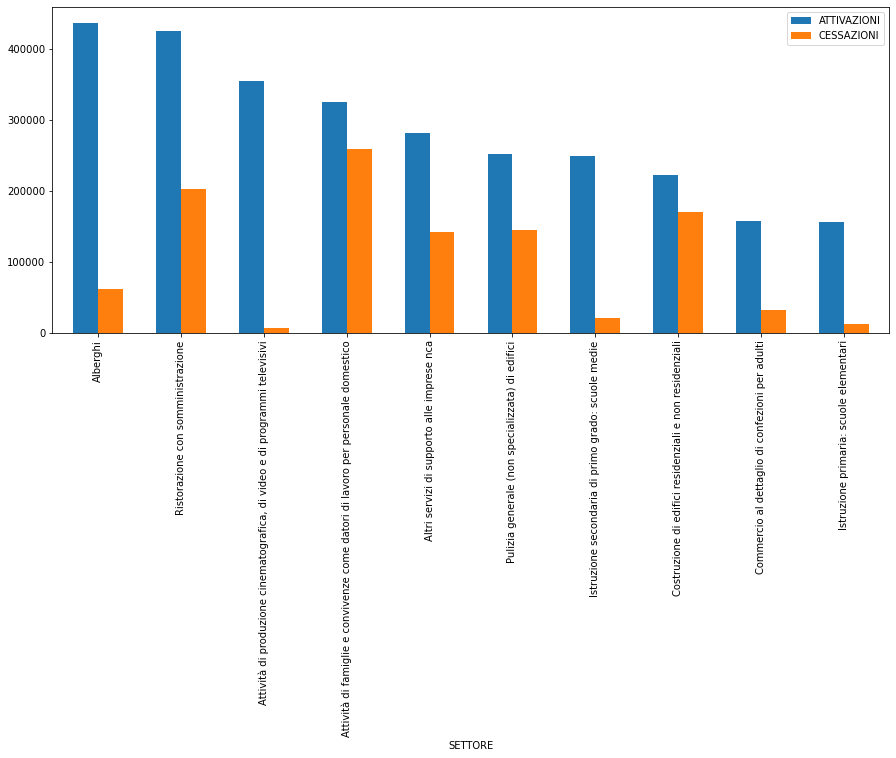

In [83]:
ax = perAtt.plot.bar(width = 0.6, figsize = (15,6))
#plot attivazioni più rilevanti

Text(0, 0.5, 'SETTORE')

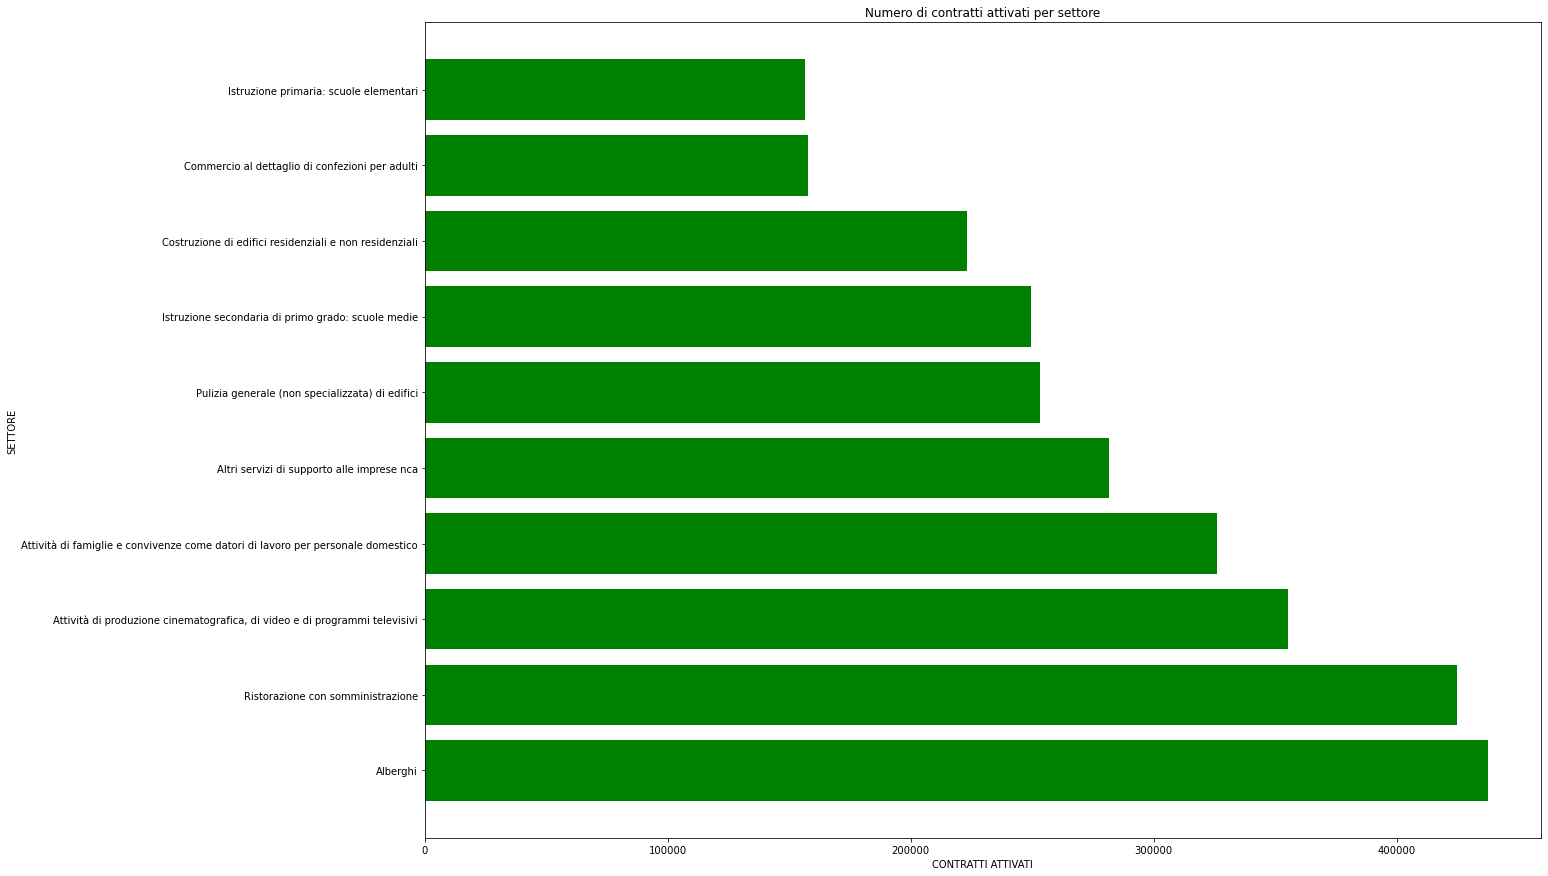

In [86]:
#plt.ticklabel_format(style='plain')
counts=dfOrdAtt.loc[:, ['SETTORE']].value_counts() 
counts=counts.head(10)
pltfigsize=(20,15)
plt.figure(figsize=pltfigsize) 
plt.ticklabel_format(style='plain') #Importante lasciare qui questo comando 
plt.barh(y=[i[0] for i in counts.index], width=counts.values, color='green')
plt.title('Numero di contratti attivati per settore')
plt.xlabel('CONTRATTI ATTIVATI')
plt.ylabel('SETTORE')

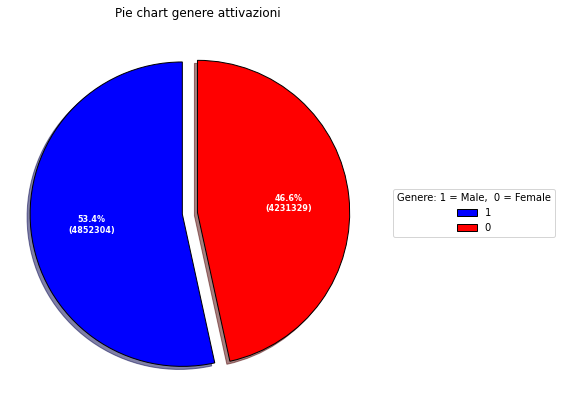

In [88]:
 #visualizing percentage of activated contracts for genre
 
# Creating dataset
geners = dfOrdAtt.GENERE.value_counts()

data = geners.values
indx = geners.index
 
 
# Creating explode data
explode = (0.1, 0.0)
 
# Creating color parameters
colors = ( "blue", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = indx,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="white"))
 
# Adding legend
ax.legend(wedges, indx,
          title ="Genere: 1 = Male,  0 = Female",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Pie chart genere attivazioni")
 
# show plot
plt.show()

Text(0, 0.5, 'NUMERO ATTIVAZIONI')

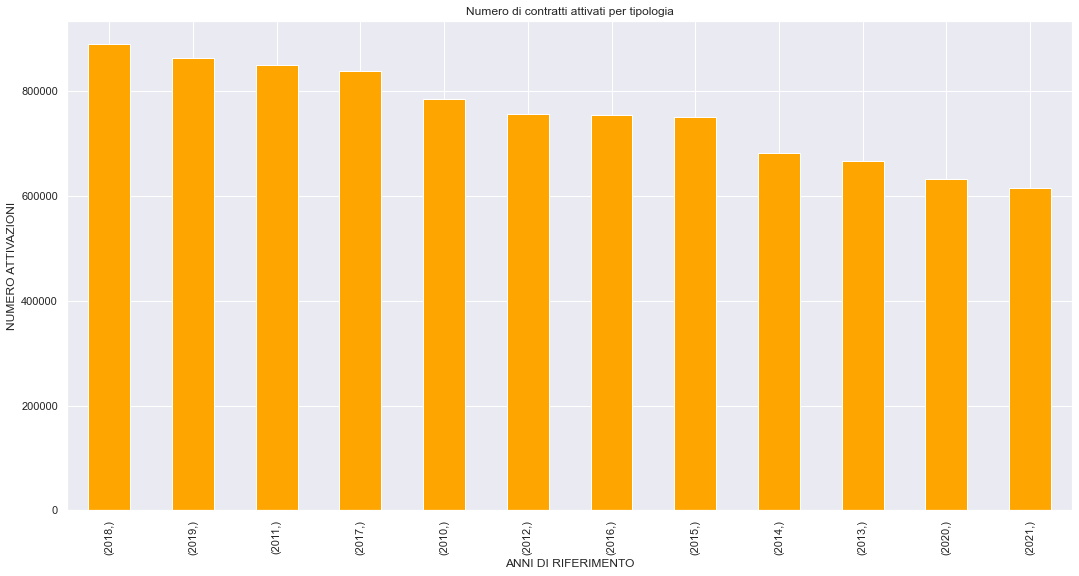

In [91]:
value_count_modalita = dfOrdAtt.loc[:, ['ANNO']].value_counts()
plt.ticklabel_format(style='plain')
abscissa_axis=value_count_modalita.index
ordinate_axis=value_count_modalita.values
ax=value_count_modalita.plot.bar(x=abscissa_axis,y=ordinate_axis,color='orange', figsize = (18,9))
plt.title('Numero di contratti attivati per Anno')
plt.xlabel('ANNI DI RIFERIMENTO')
plt.ylabel('NUMERO ATTIVAZIONI')

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

         Visualizzazione e plot dei 10 settori più importanti per cessazioni.
         Il settore del personale domestico e quello della ristorazione presentano una quantità importante di cessazioni.
         Il settore della ristorazione ha un notevole turnover essendo in seconda posizione per frequenza di attivazioni
         ma anche di cessazioni.
      


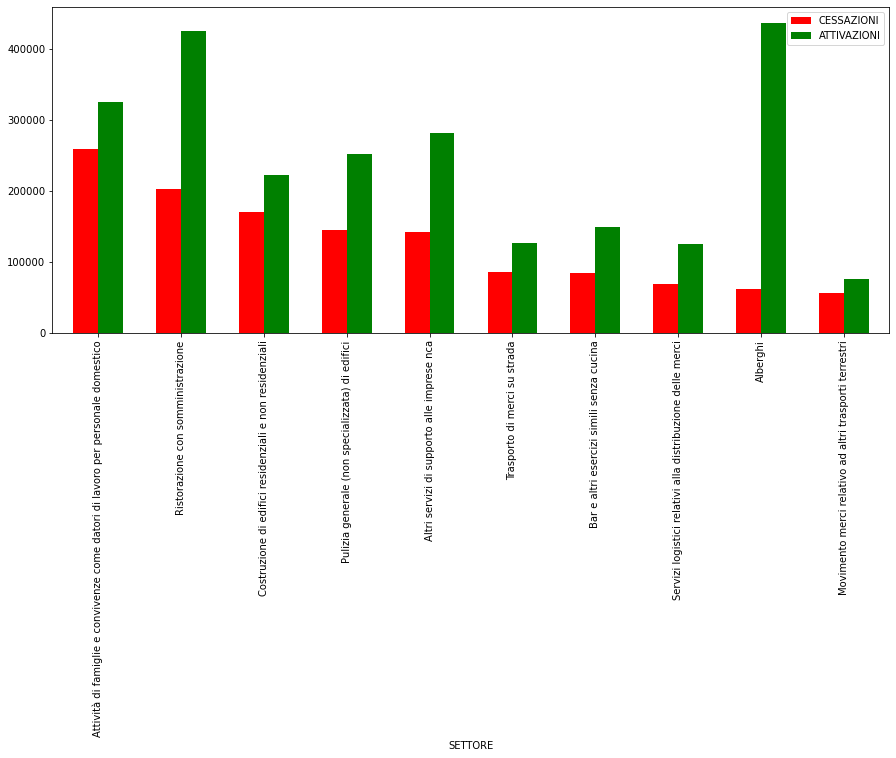

In [84]:
ax = perCess.plot.bar(width = 0.6, figsize = (15,6), color = ['red','green'])
    
#plot cessazioni più rilevanti

Text(0, 0.5, 'SETTORE')

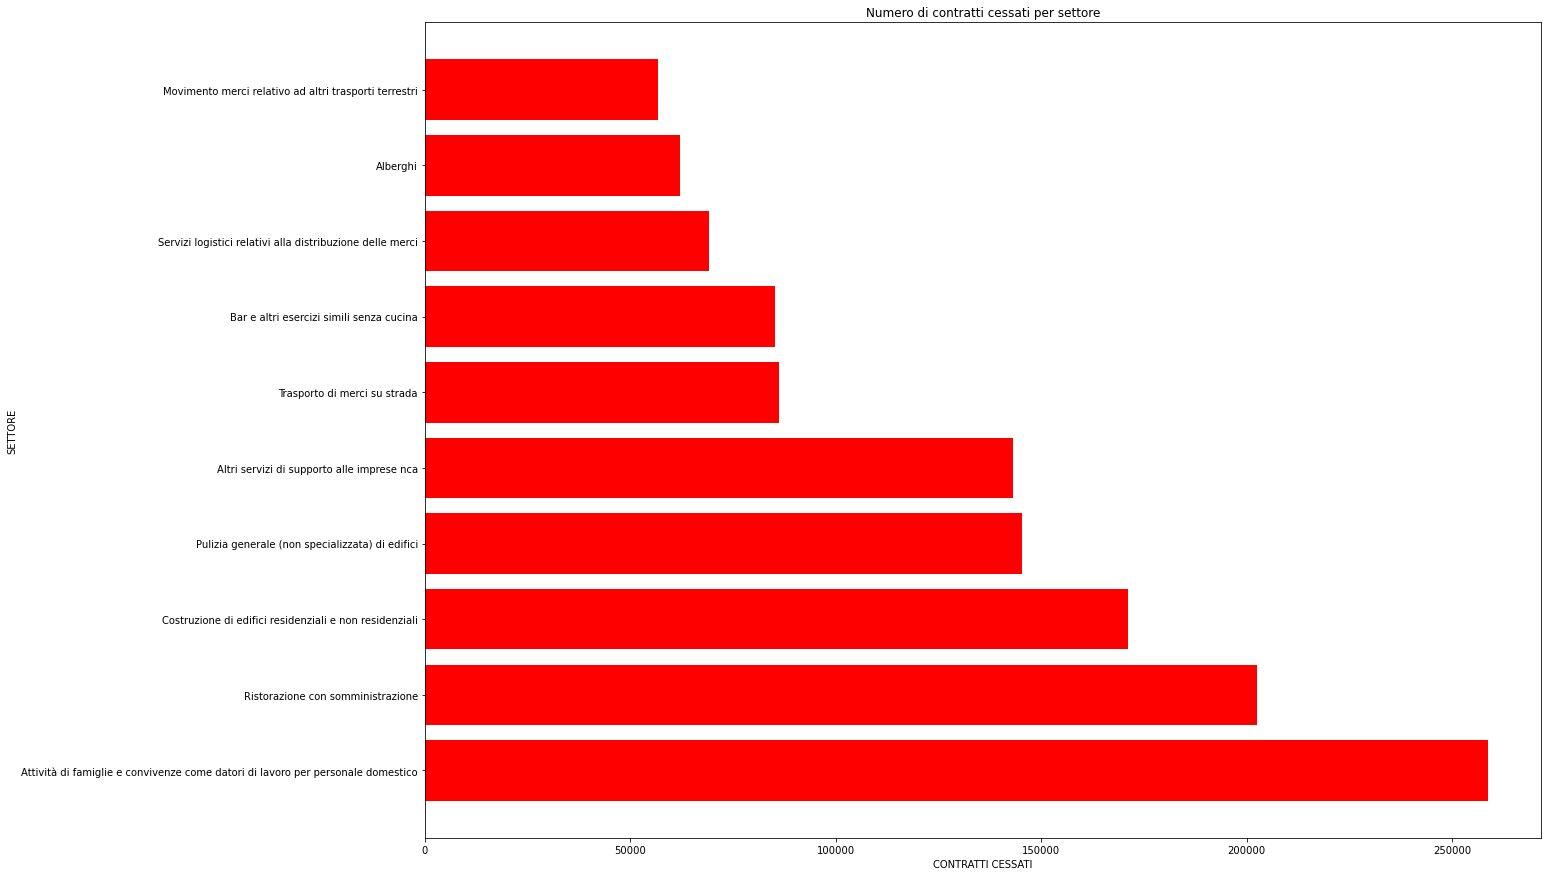

In [87]:
#plt.ticklabel_format(style='plain')
counts=dfOrdCess.loc[:, ['SETTORE']].value_counts() 
counts=counts.head(10)
pltfigsize=(20,15)
plt.figure(figsize=pltfigsize) 
plt.ticklabel_format(style='plain') #Importante lasciare qui questo comando 
plt.barh(y=[i[0] for i in counts.index], width=counts.values, color='red')
plt.title('Numero di contratti cessati per settore')
plt.xlabel('CONTRATTI CESSATI')
plt.ylabel('SETTORE')

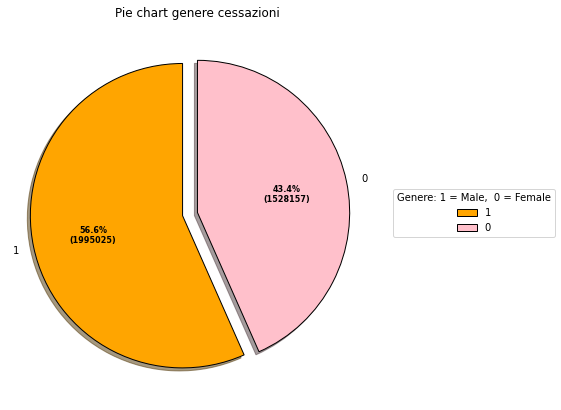

In [89]:
 #visualizing percentage of activated contracts for genre

 
 
# Creating dataset
geners = dfOrdCess.GENERE.value_counts()

data = geners.values
indx = geners.index
 
 
# Creating explode data
explode = (0.1, 0.0)
 
# Creating color parameters
colors = ( "orange", "pink")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = indx,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, indx,
          title ="Genere: 1 = Male,  0 = Female",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Pie chart genere cessazioni")
 
# show plot
plt.show()

Text(0, 0.5, 'NUMERO CESSAZIONI')

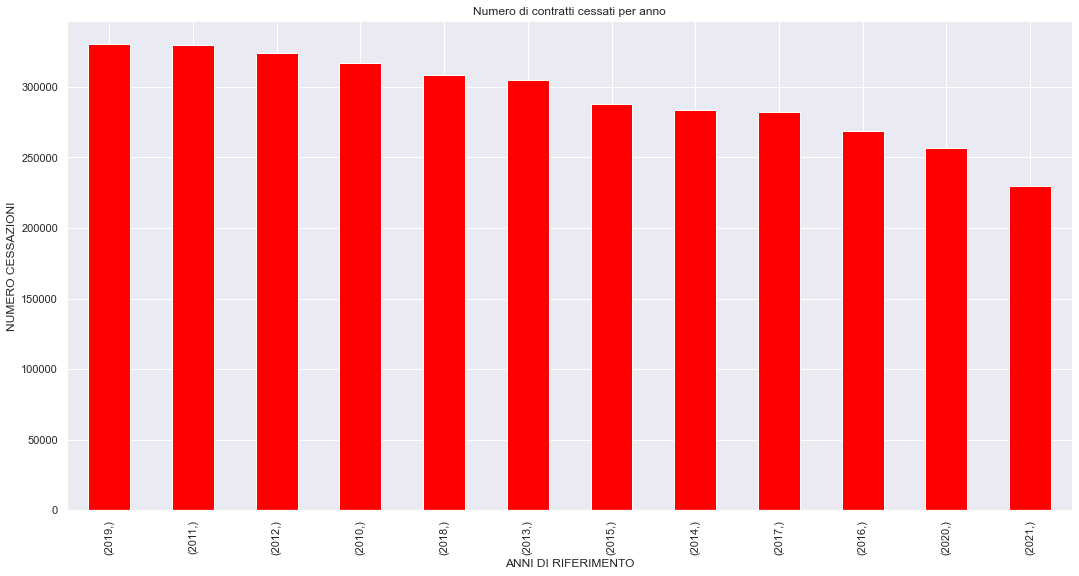

In [92]:
value_count_modalita = dfOrdCess.loc[:, ['ANNO']].value_counts()
plt.ticklabel_format(style='plain')
abscissa_axis=value_count_modalita.index
ordinate_axis=value_count_modalita.values
ax=value_count_modalita.plot.bar(x=abscissa_axis,y=ordinate_axis,color='red', figsize = (18,9))
plt.title('Numero di contratti cessati per anno')
plt.xlabel('ANNI DI RIFERIMENTO')
plt.ylabel('NUMERO CESSAZIONI')

Text(0.5, 1.0, 'Distribuzione contratti cessati negli anni')

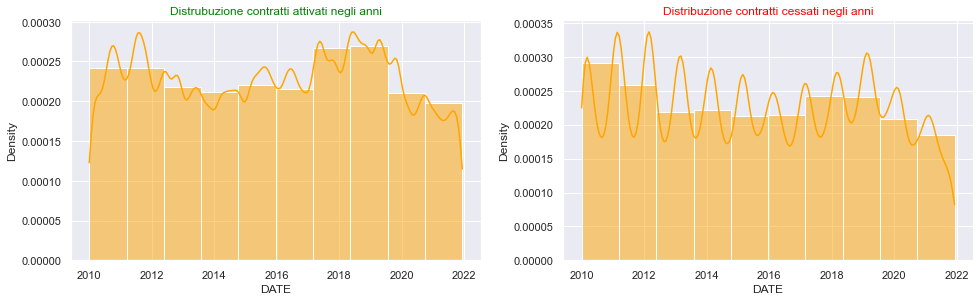

In [90]:
sns.set(rc={"figure.figsize":(25,15)})
plt.subplot(3,3,2)
sns.histplot(dfOrdAtt.DATE,label="DATA",stat="density",bins=10,kde=True, color="orange").set_title("Distrubuzione contratti attivati negli anni", color = 'green')
plt.subplot(3,3,3)
sns.histplot(dfOrdCess.DATE,label="DATA",stat="density",bins=10,kde=True, color="orange").set_title("Distribuzione contratti cessati negli anni", color = 'red')

In [93]:
attivHead = dfOrdAtt.loc[dfOrdAtt['SETTORE'].isin(perAtt.index)]

In [94]:
cessHead = dfOrdCess.loc[dfOrdCess['SETTORE'].isin(perCess.index)]

In [95]:
cessHead['SETTORE'].value_counts()

Attività di famiglie e convivenze come datori di lavoro per personale domestico    258683
Ristorazione con somministrazione                                                  202637
Costruzione di edifici residenziali e non residenziali                             171079
Pulizia generale (non specializzata) di edifici                                    145277
Altri servizi di supporto alle imprese nca                                         143166
Trasporto di merci su strada                                                        86094
Bar e altri esercizi simili senza cucina                                            85297
Servizi logistici relativi alla distribuzione delle merci                           69199
Alberghi                                                                            61989
Movimento merci relativo ad altri trasporti terrestri                               56825
Name: SETTORE, dtype: int64

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

          Correlazione tra i 10 settori più importanti per attivazioni.
          La matrice di correlazione evidenzia la correlazione tra i settori di attivazione e tra settori e PIL
      


In [96]:
mostA = aa.head(10).index.tolist()
mostA

In [97]:
mostC = ab.head(10).index.tolist()
mostC

In [100]:
li = mostA
li2 = mostC

In [102]:
dfAttivatiMost = pd.DataFrame(columns=[li]) #da rinominare dfAttivatiMost
for k in li:
     a = dfOrdAtt.loc[(dfOrdAtt['SETTORE'] == k)].ANNO.value_counts()
     dfAttivatiMost[k] = a
dfAttivatiMost.sort_index(inplace= True)

In [113]:
dfAttivatiMost

Alberghi Ristorazione con somministrazione  \
2010    47362                             24097   
2011    48194                             26522   
2012    38889                             30406   
2013    36996                             26102   
2014    36281                             31617   
2015    39300                             35944   
2016    37828                             34756   
2017    42149                             49113   
2018    43396                             52870   
2019    43733                             56466   
2020    10960                             27853   
2021    12315                             29183   

     Attività di produzione cinematografica, di video e di programmi televisivi  \
2010                                              22961                           
2011                                              24920                           
2012                                              22053                           
2013                                              24273                           
2014                                              27560                           
2015                                              29257                           
2016                                              33961                           
2017                                              33412                           
2018                                              37154                           
2019                                              37965                           
2020                                              29759                           
2021                                              31992                           

     Attività di famiglie e convivenze come datori di lavoro per personale domestico  \
2010                                              31641                                
2011                                              25846                                
2012                                              26468                                
2013                                              28872                                
2014                                              24748                                
2015                                              22784                                
2016                                              22523                                
2017                                              22407                                
2018                                              24155                                
2019                                              25210                                
2020                                              48704                                
2021                                              22792                                

     Altri servizi di supporto alle imprese nca  \
2010                                      38878   
2011                                      34991   
2012                                      36275   
2013                                      28722   
2014                                      25211   
2015                                      19581   
2016                                      16415   
2017                                      19134   
2018                                      20552   
2019                                      18091   
2020                                      12367   
2021                                      11364   

     Pulizia generale (non specializzata) di edifici  \
2010                                           19373   
2011                                           22127   
2012                                           21870   
2013                                           17394   
2014                                           16518   
2015                                           19763   
2016                                           20997   
2017

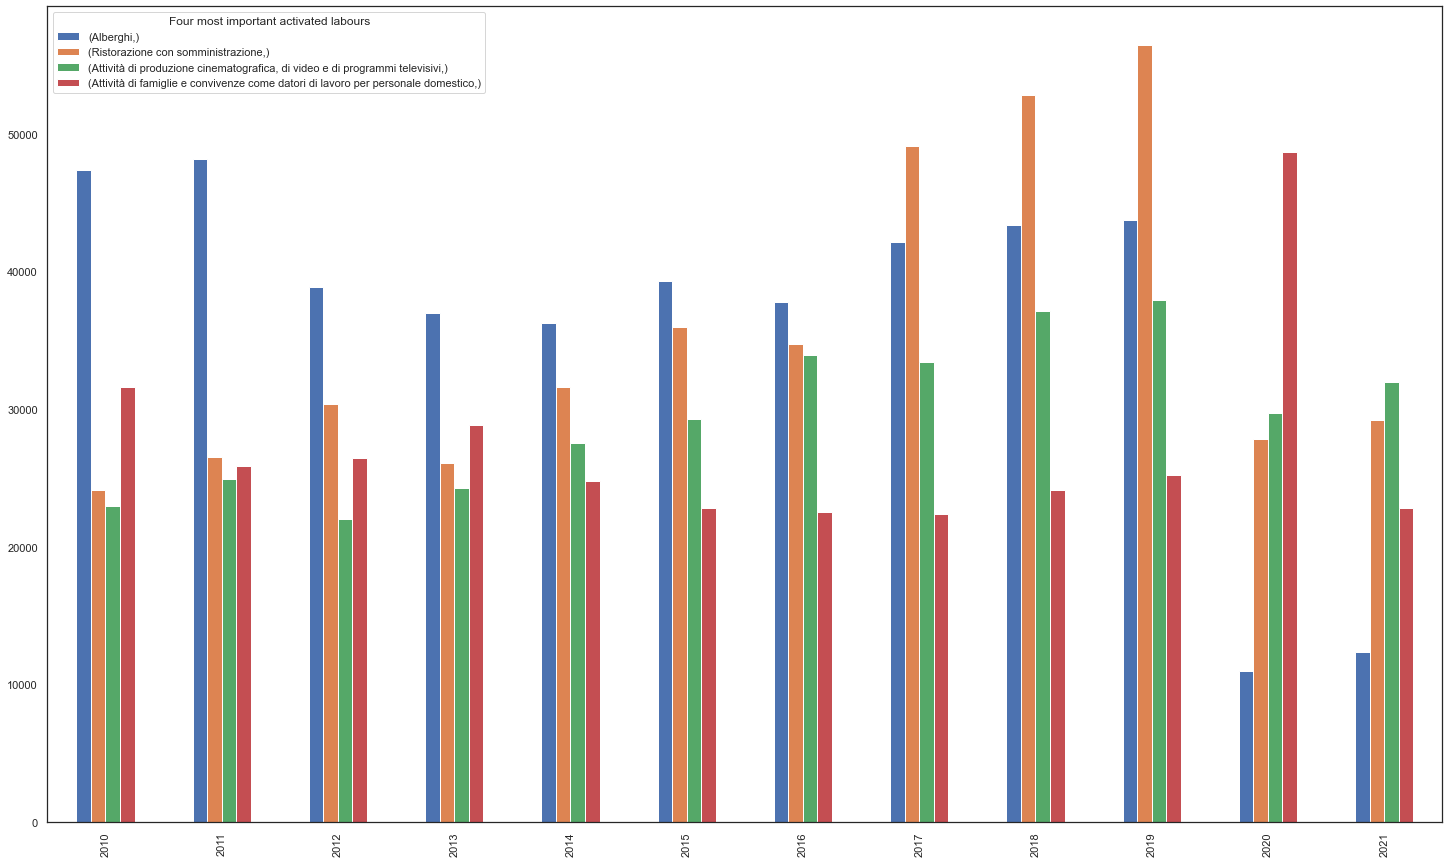

In [114]:
dfAttivatiMost.iloc[:, 0:4].plot.bar() #plot 4 most important activated contracts per year
plt.legend(title = 'Four most important activated labours')

In [115]:
dfAttivatiMost['PIL_MLN_EUR'] = pilgg2['P.I.L. Milioni di Euro']

In [116]:
dfAttivatiMost

Alberghi Ristorazione con somministrazione  \
2010    47362                             24097   
2011    48194                             26522   
2012    38889                             30406   
2013    36996                             26102   
2014    36281                             31617   
2015    39300                             35944   
2016    37828                             34756   
2017    42149                             49113   
2018    43396                             52870   
2019    43733                             56466   
2020    10960                             27853   
2021    12315                             29183   

     Attività di produzione cinematografica, di video e di programmi televisivi  \
2010                                              22961                           
2011                                              24920                           
2012                                              22053                           
2013                                              24273                           
2014                                              27560                           
2015                                              29257                           
2016                                              33961                           
2017                                              33412                           
2018                                              37154                           
2019                                              37965                           
2020                                              29759                           
2021                                              31992                           

     Attività di famiglie e convivenze come datori di lavoro per personale domestico  \
2010                                              31641                                
2011                                              25846                                
2012                                              26468                                
2013                                              28872                                
2014                                              24748                                
2015                                              22784                                
2016                                              22523                                
2017                                              22407                                
2018                                              24155                                
2019                                              25210                                
2020                                              48704                                
2021                                              22792                                

     Altri servizi di supporto alle imprese nca  \
2010                                      38878   
2011                                      34991   
2012                                      36275   
2013                                      28722   
2014                                      25211   
2015                                      19581   
2016                                      16415   
2017                                      19134   
2018                                      20552   
2019                                      18091   
2020                                      12367   
2021                                      11364   

     Pulizia generale (non specializzata) di edifici  \
2010                                           19373   
2011                                           22127   
2012                                           21870   
2013                                           17394   
2014                                           16518   
2015                                           19763   
2016                                           20997   
2017

Text(0.5, 1.0, 'Lombardia : most important activated labours')

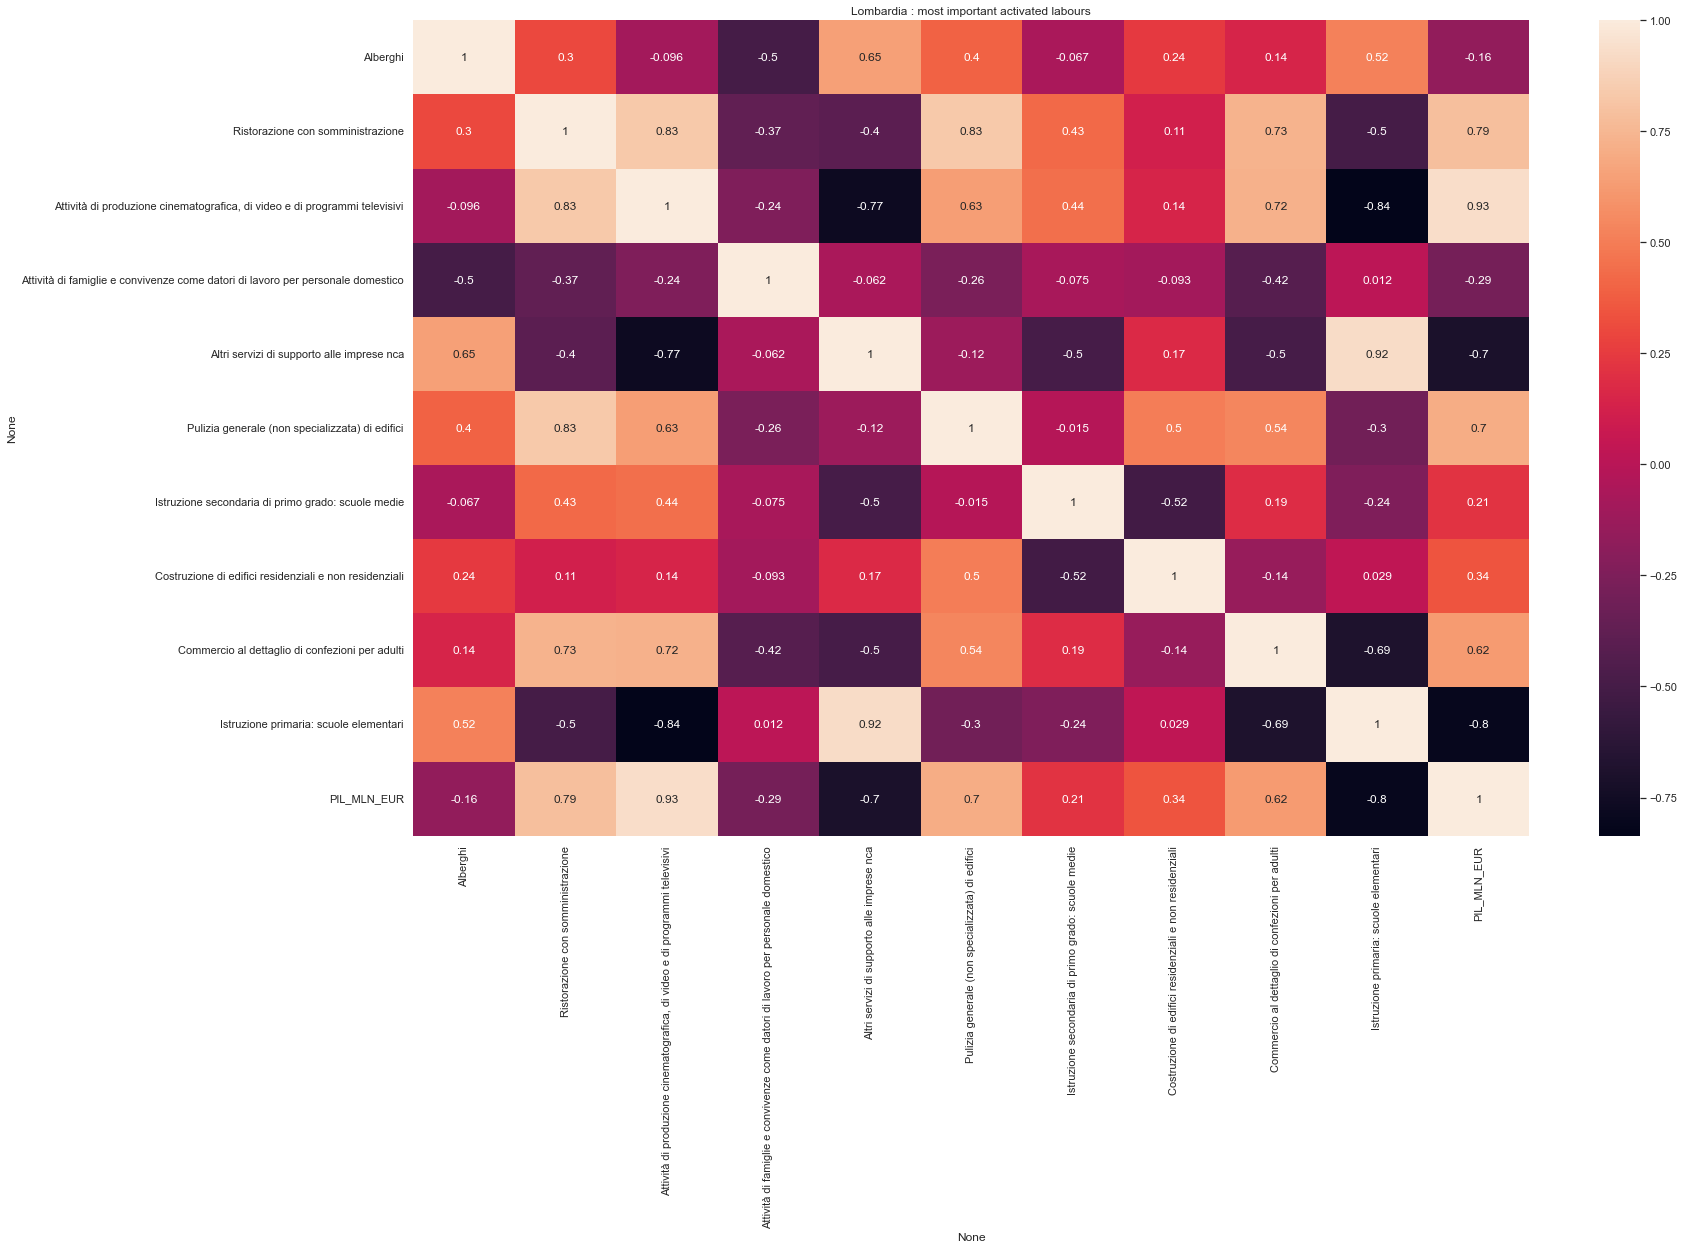

In [117]:
corr = dfAttivatiMost.corr()
sns.set_theme (style = 'white')
heatmap = sns.heatmap(corr, annot = True)
plt.title('Lombardia : most important activated labours')

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

         Notiamo una forte correlazione direttamente proporzionale tra il settore della ristorazione e l'incremento del PIL Lombardo.
         Parimenti il settore di produzione cinematografica e multimediale è fortemente correlato all'incremento del PIL, in quanto un PIL elevato è indice di evoluzione tecnologica e sociale.
         Il settore della ristorazione va di pari passo con la pulizia generale di edifici, in quanto per un servizio di ristorazione professionale è richiesto un controllo e una pulizia di infrastrutture altrettanto professionali.
      


<AxesSubplot:>

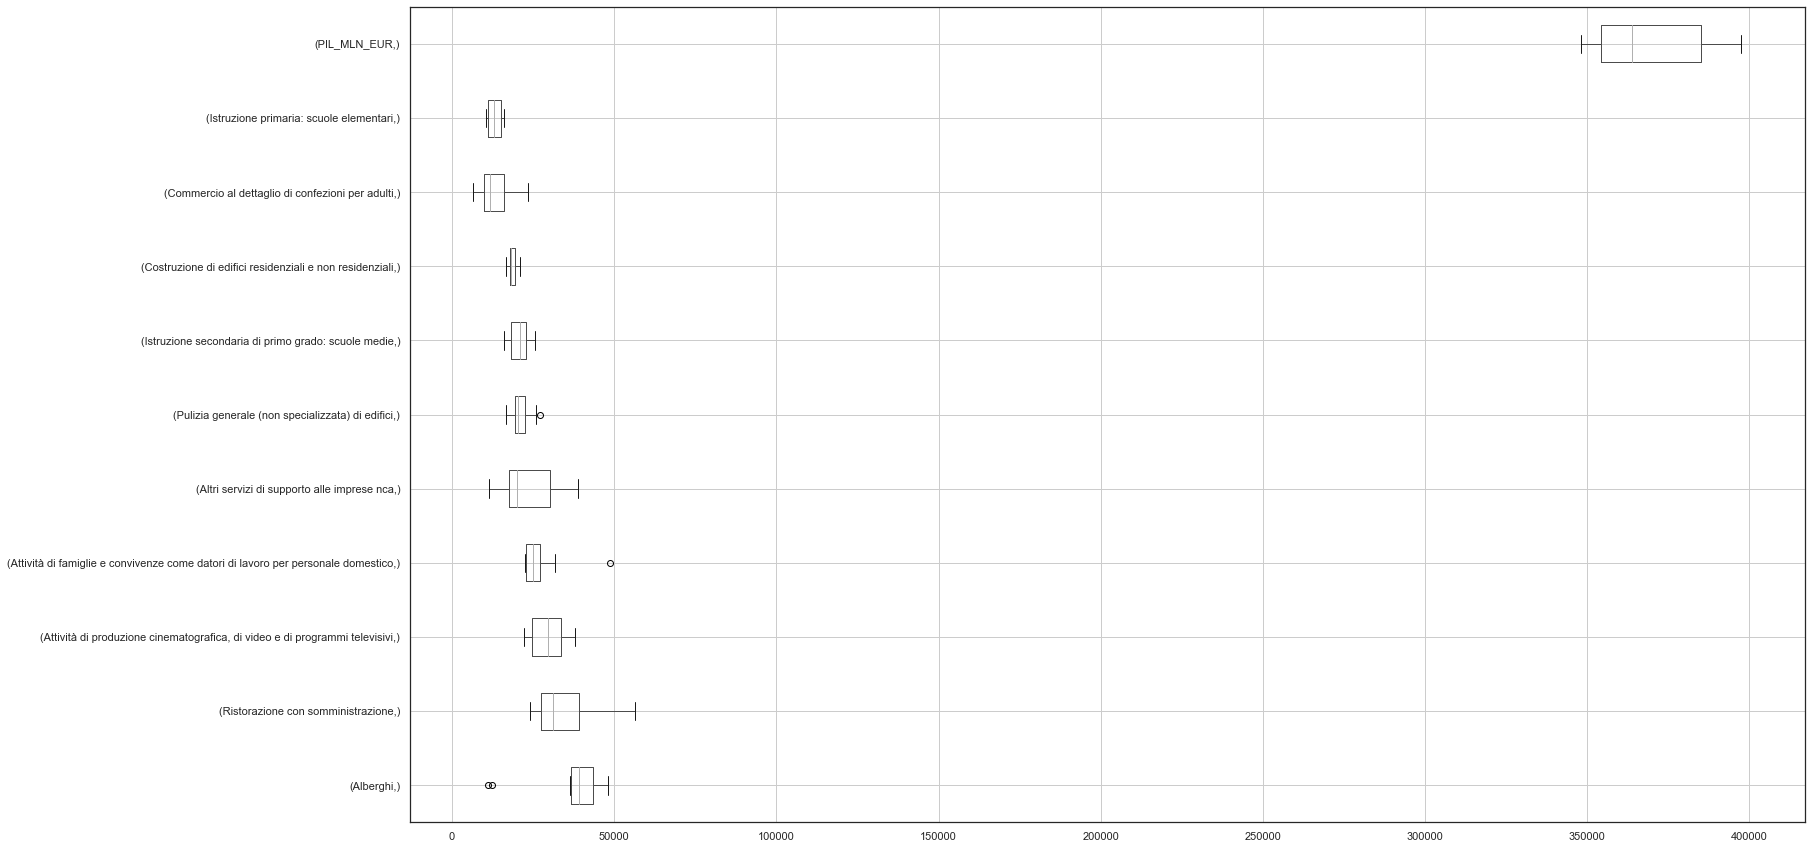

In [118]:
dfAttivatiMost.boxplot(vert = False) #boxplot most important activated contracts

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

         Correlazione tra i 10 settori più importanti per cessazioni.
         La matrice di correlazione evidenzia la correlazione tra i settori terminati e tra settori e PIL
      


In [105]:
dfCessatiMost = pd.DataFrame(columns=[li2])
for c in li2:
     t = dfOrdCess.loc[(dfOrdCess['SETTORE'] == c)].ANNO.value_counts()
     dfCessatiMost[c] = t
dfCessatiMost.sort_index(inplace= True)

In [106]:
dfCessatiMost

Attività di famiglie e convivenze come datori di lavoro per personale domestico  \
2010                                              15325                                
2011                                              21642                                
2012                                              25292                                
2013                                              24870                                
2014                                              22037                                
2015                                              21551                                
2016                                              20289                                
2017                                              21606                                
2018                                              22192                                
2019                                              21743                                
2020                                              23392                                
2021                                              18744                                

     Ristorazione con somministrazione  \
2010                             13935   
2011                             15492   
2012                             18403   
2013                             16707   
2014                             16379   
2015                             16796   
2016                             16232   
2017                             18369   
2018                             20816   
2019                             22227   
2020                             15686   
2021                             11595   

     Costruzione di edifici residenziali e non residenziali  \
2010                                              20432       
2011                                              20954       
2012                                              17682       
2013                                              15620       
2014                                              14049       
2015                                              13906       
2016                                              12639       
2017                                              12740       
2018                                              12773       
2019                                              12366       
2020                                               8692       
2021                                               9226       

     Pulizia generale (non specializzata) di edifici  \
2010                                           13508   
2011                                           14145   
2012                                           13978   
2013                                           13388   
2014                                           10847   
2015                                           12693   
2016                                           11356   
2017                                           10889   
2018                                           11730   
2019                                           13772   
2020                                           10914   
2021                                            8057   

     Altri servizi di supporto alle imprese nca Trasporto di merci su strada  \
2010                                      19072                         6449   
2011                                      17960                         7300   
2012                                      15784                         7008   
2013                                      14512                         6651   
2014                                      12414                         6471   
2015                                      13120                         6695   
2016                                      11460                         6264   
2017                                       8421                         7452   
2018                                       9

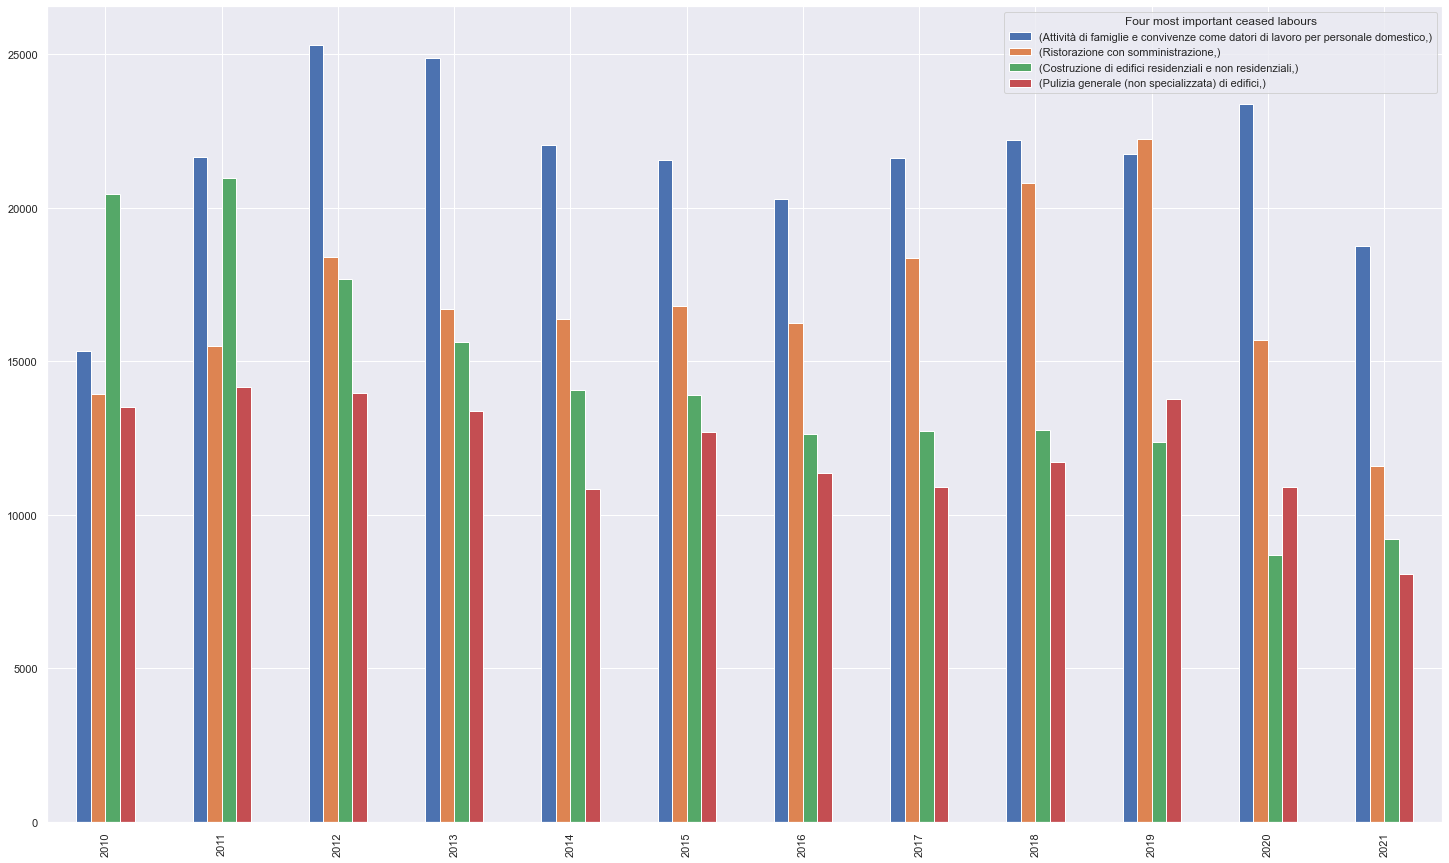

In [107]:
dfCessatiMost.iloc[:, 0:4].plot.bar()  #plot 4 most imprtant ceased contracts per year
plt.legend(title = 'Four most important ceased labours')

In [108]:
dfCessatiMost['PIL_MLN_EUR'] = pilgg2['P.I.L. Milioni di Euro']

In [109]:
dfCessatiMost

Attività di famiglie e convivenze come datori di lavoro per personale domestico  \
2010                                              15325                                
2011                                              21642                                
2012                                              25292                                
2013                                              24870                                
2014                                              22037                                
2015                                              21551                                
2016                                              20289                                
2017                                              21606                                
2018                                              22192                                
2019                                              21743                                
2020                                              23392                                
2021                                              18744                                

     Ristorazione con somministrazione  \
2010                             13935   
2011                             15492   
2012                             18403   
2013                             16707   
2014                             16379   
2015                             16796   
2016                             16232   
2017                             18369   
2018                             20816   
2019                             22227   
2020                             15686   
2021                             11595   

     Costruzione di edifici residenziali e non residenziali  \
2010                                              20432       
2011                                              20954       
2012                                              17682       
2013                                              15620       
2014                                              14049       
2015                                              13906       
2016                                              12639       
2017                                              12740       
2018                                              12773       
2019                                              12366       
2020                                               8692       
2021                                               9226       

     Pulizia generale (non specializzata) di edifici  \
2010                                           13508   
2011                                           14145   
2012                                           13978   
2013                                           13388   
2014                                           10847   
2015                                           12693   
2016                                           11356   
2017                                           10889   
2018                                           11730   
2019                                           13772   
2020                                           10914   
2021                                            8057   

     Altri servizi di supporto alle imprese nca Trasporto di merci su strada  \
2010                                      19072                         6449   
2011                                      17960                         7300   
2012                                      15784                         7008   
2013                                      14512                         6651   
2014                                      12414                         6471   
2015                                      13120                         6695   
2016                                      11460                         6264   
2017                                       8421                         7452   
2018                                       9

Text(0.5, 1.0, 'Lombardia : most important ceased labours')

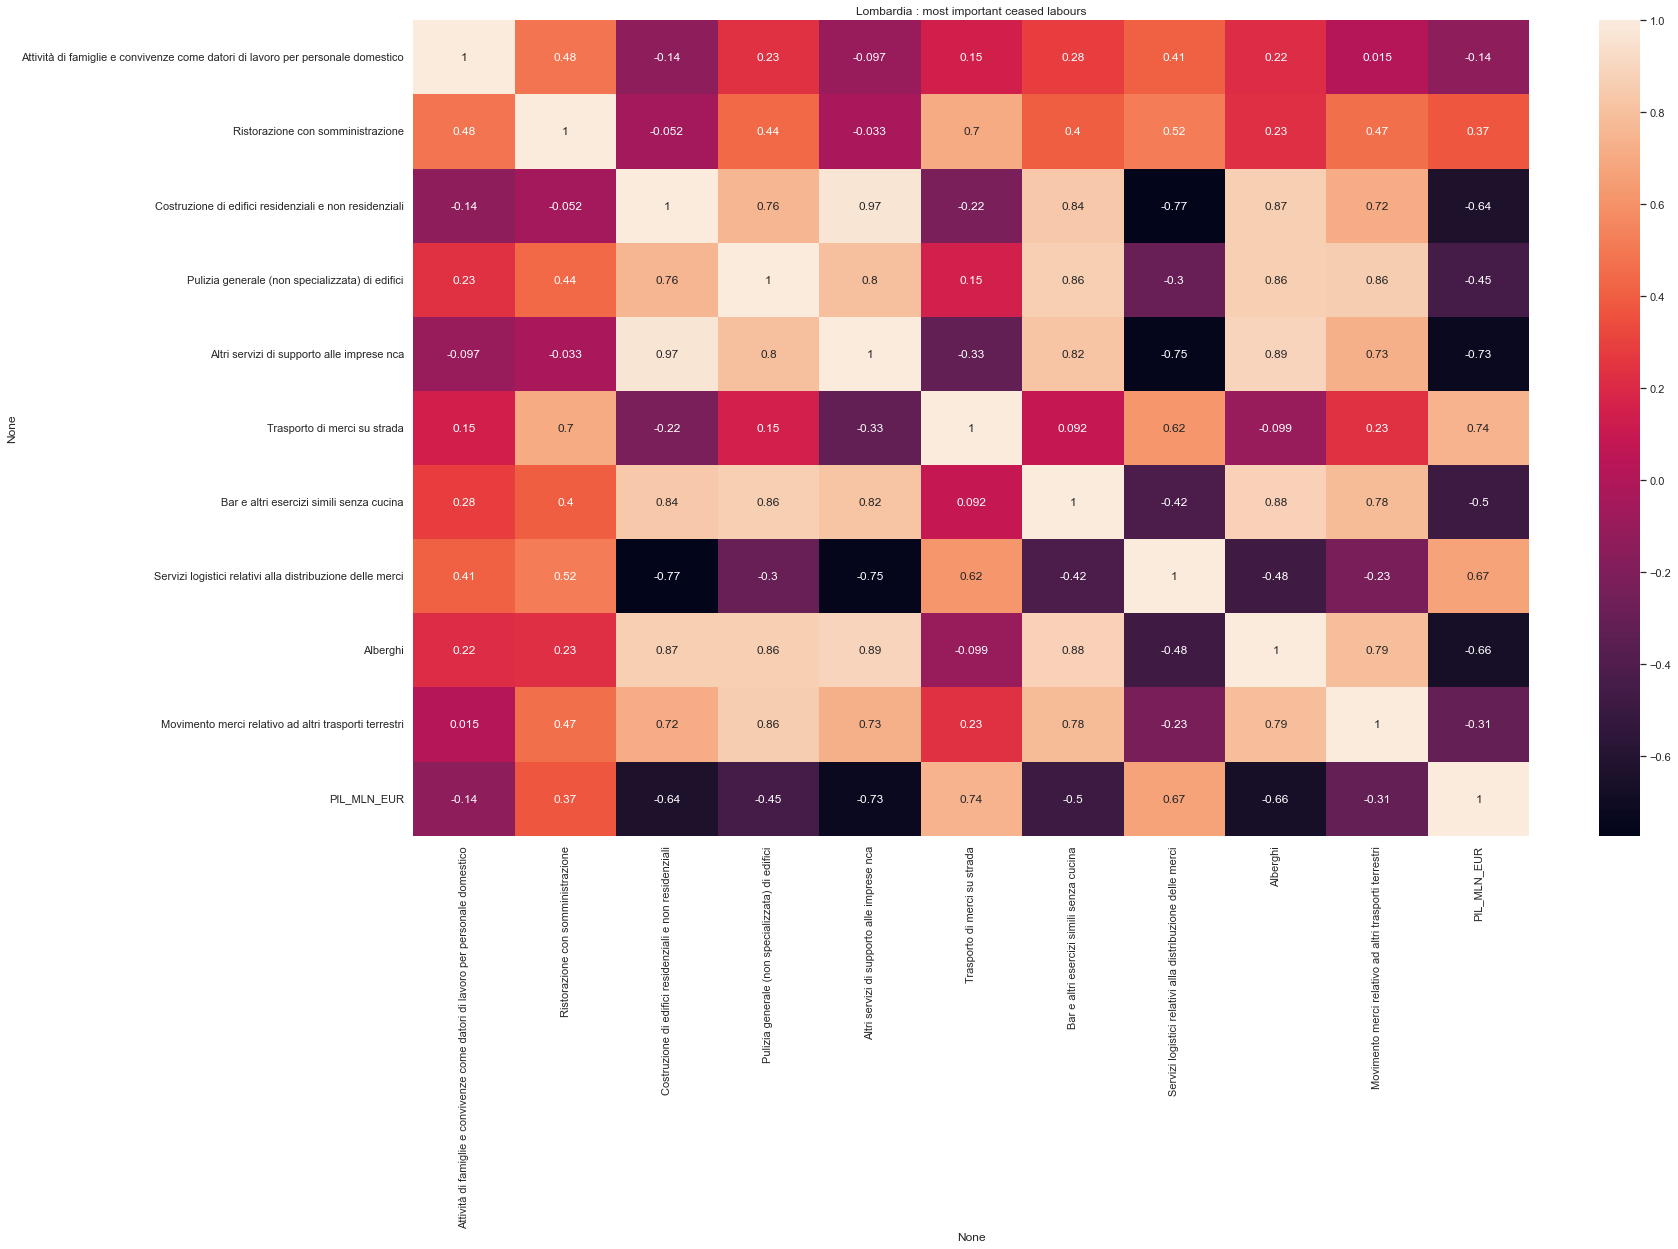

In [111]:
corr2 = dfCessatiMost.corr()
sns.set_theme (style = 'white')
heatmap2 = sns.heatmap(corr2, annot = True)
plt.title('Lombardia : most important ceased labours')

4. - VISUALIZZAZIONE DEI DATI, CONSIDERAZIONI E CONFRONTO TRA LE STATISTICHE DEI LAVORI CESSATI E ATTIVATI NEI SETTORI PIU IMPORTANTI PER FREQUENZA DI ATTIVAZIONE/CESSAZIONE: 

         Notiamo una forte correlazione tra la terminazione dei contratti relativi al trasporto e l'incremento del PIL. Con il processo di digitalizzazione e innovazione tecnica è probabile che tali posizioni vengano considerate meno importanti e non risultano quindi un target interessante per la popolazione


<AxesSubplot:>

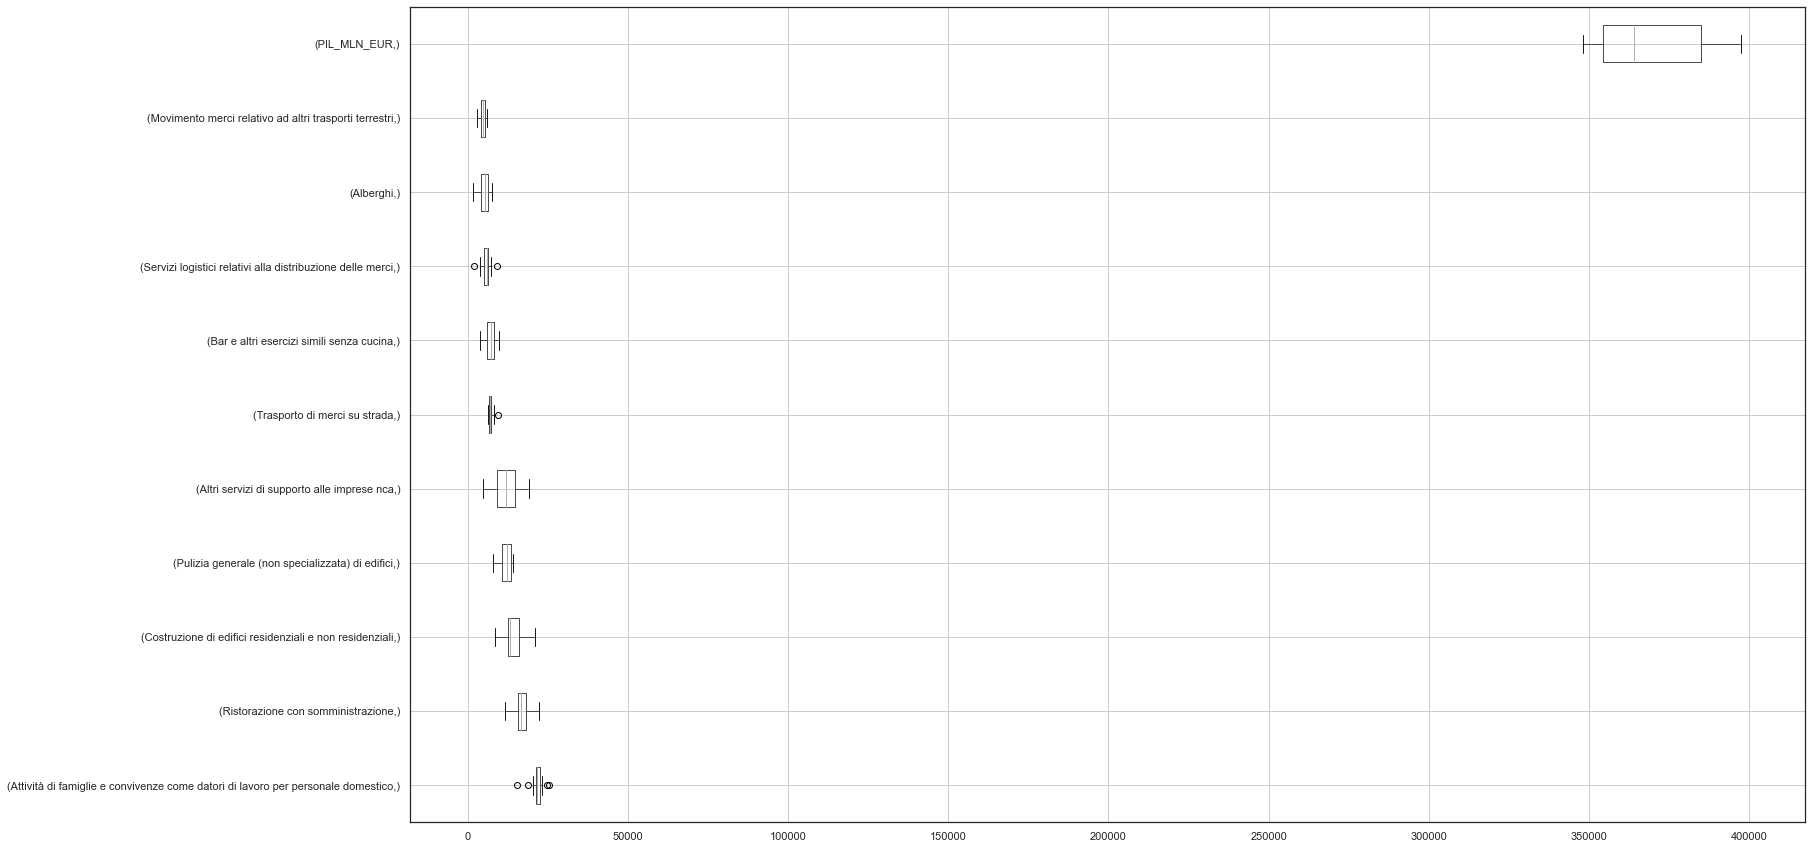

In [119]:
dfCessatiMost.boxplot(vert = False) #boxplot most ceased contracts

----

5. - ANALISI TEMPORALE E PREPARAZIONE DEI DATI PER L'IMPLEMENTAZIONE DI UN MODELLO DI PREDITTIVITÀ CHE CONSIDERI ANDAMENTO DEL MERCATO LAVORATIVO SU ATTIVAZIONI E CESSAZIONI:  

         Visualizzazione dele serie temporali mensili per i dieci tipi di contratti attivati più frequentemente

  

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


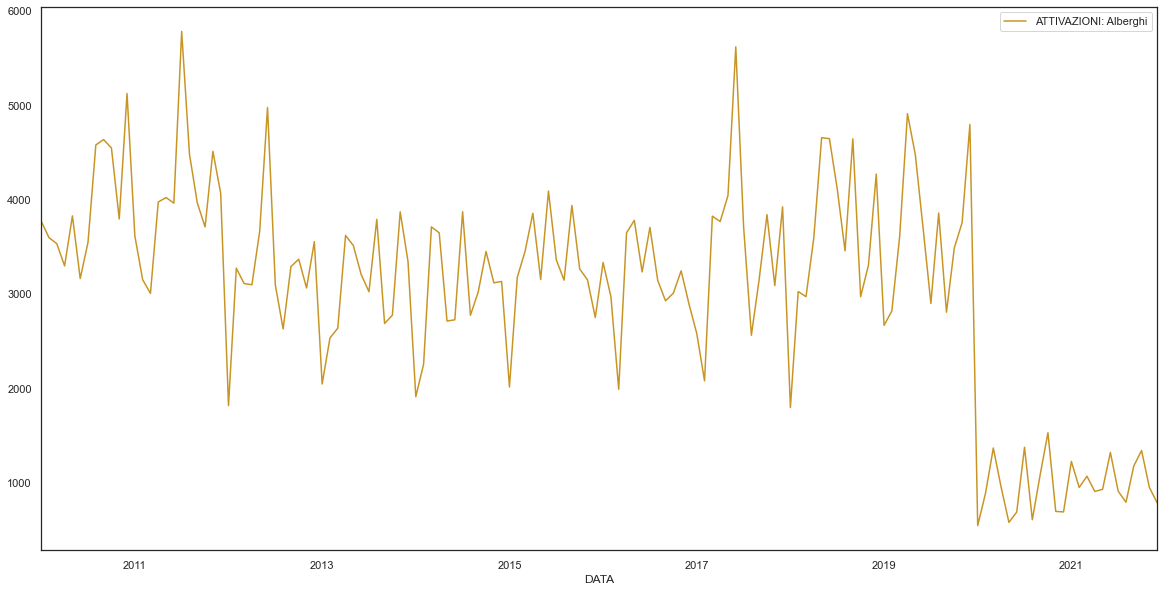

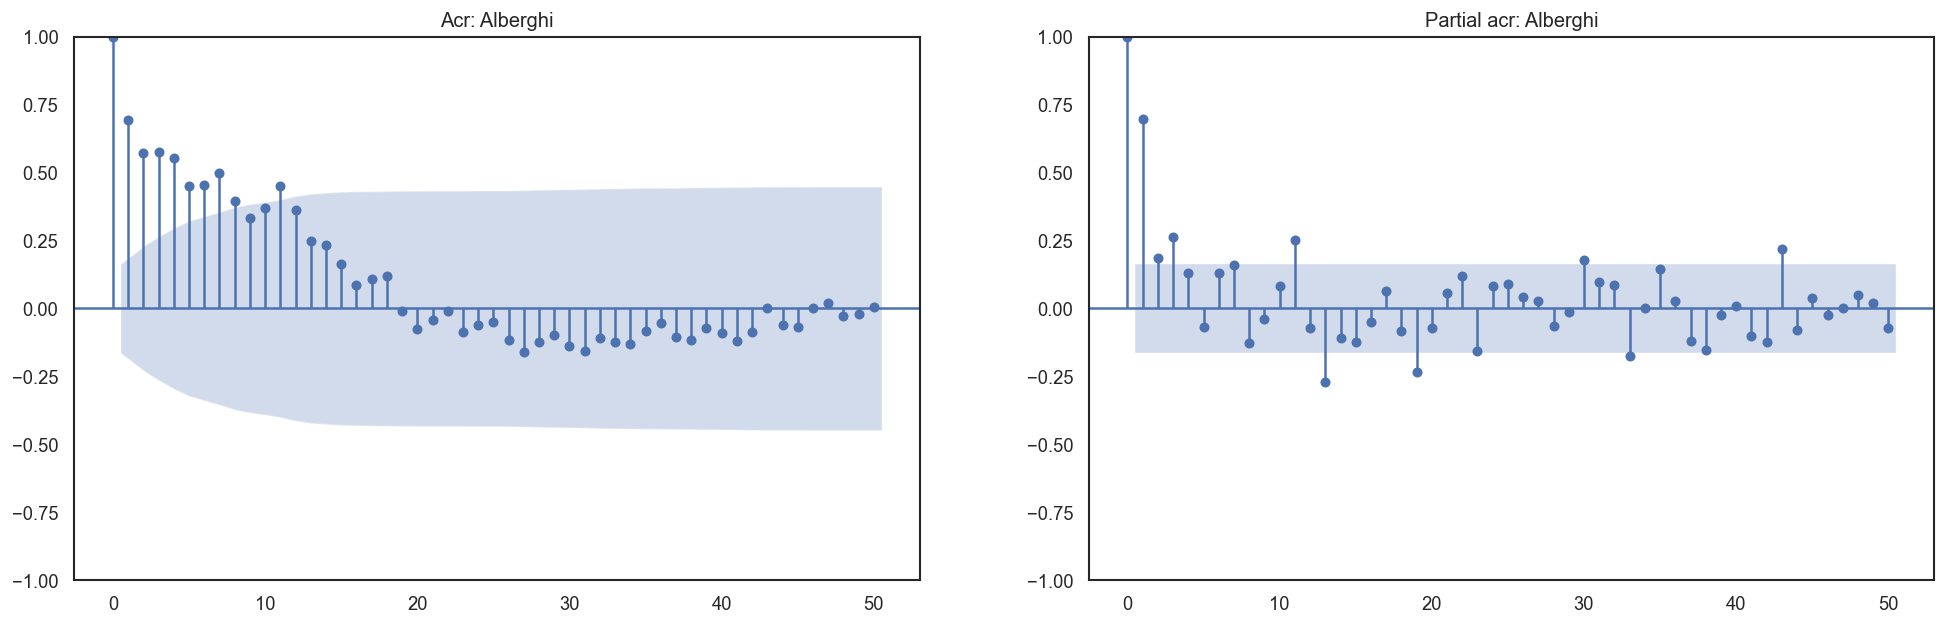

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


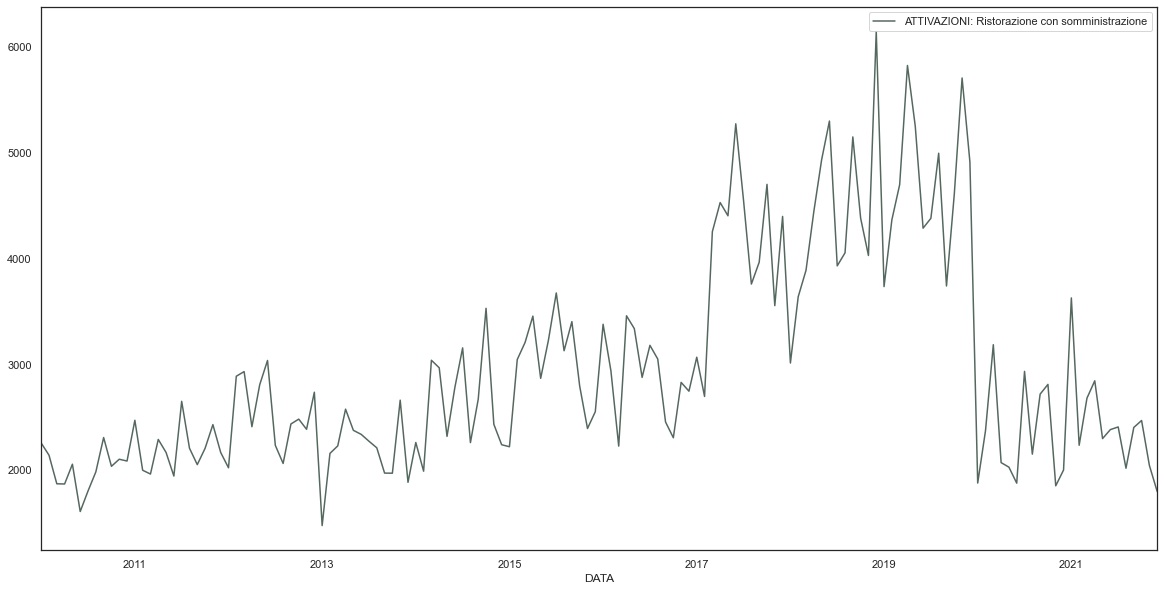

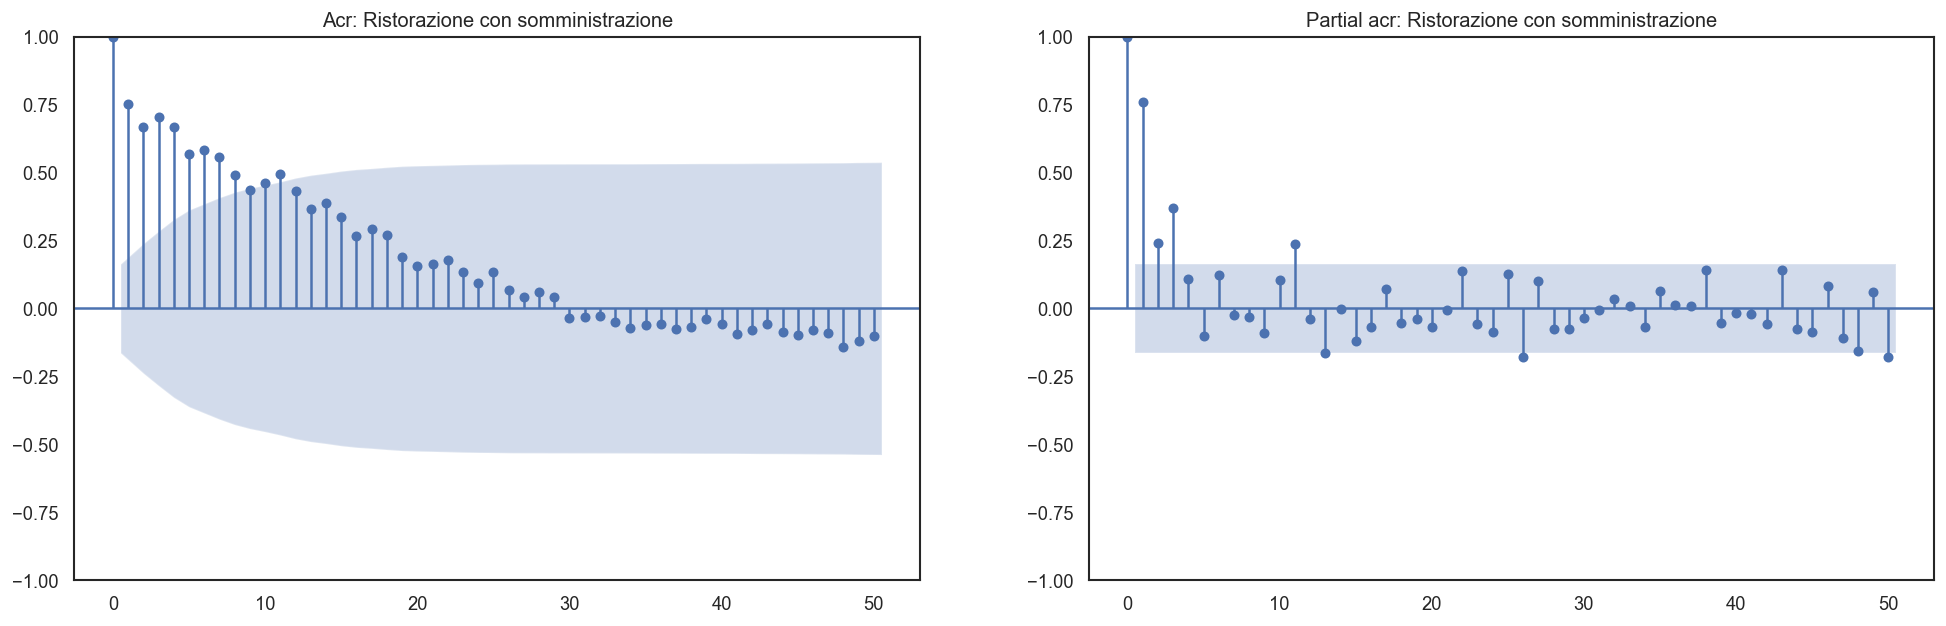

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


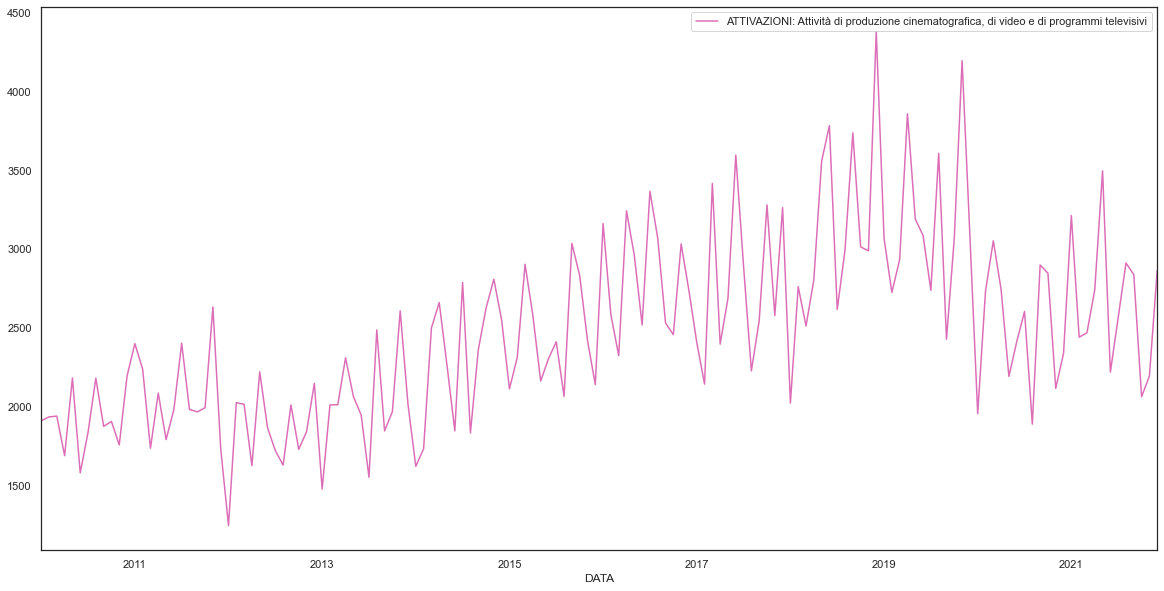

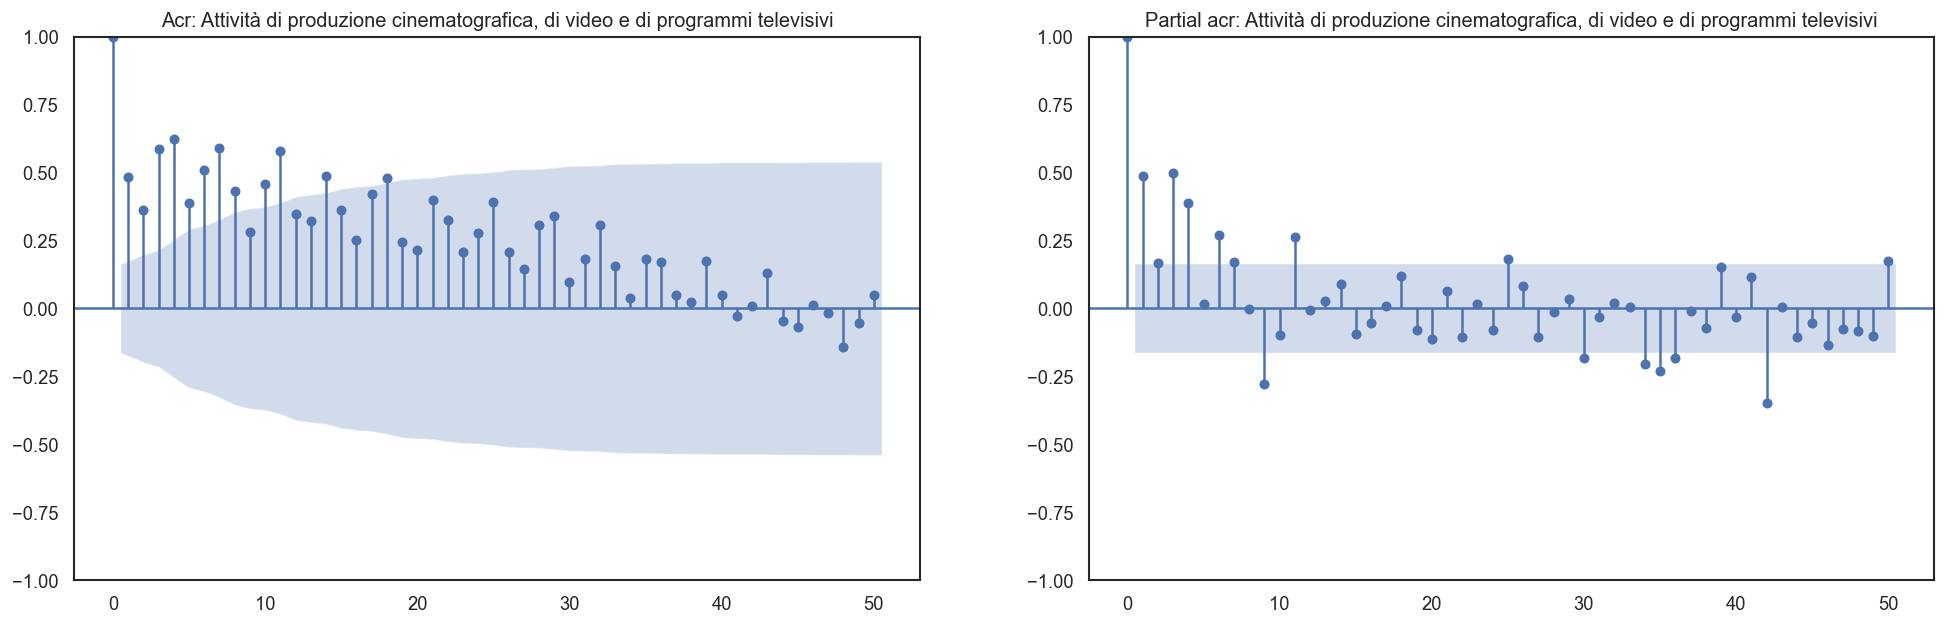

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


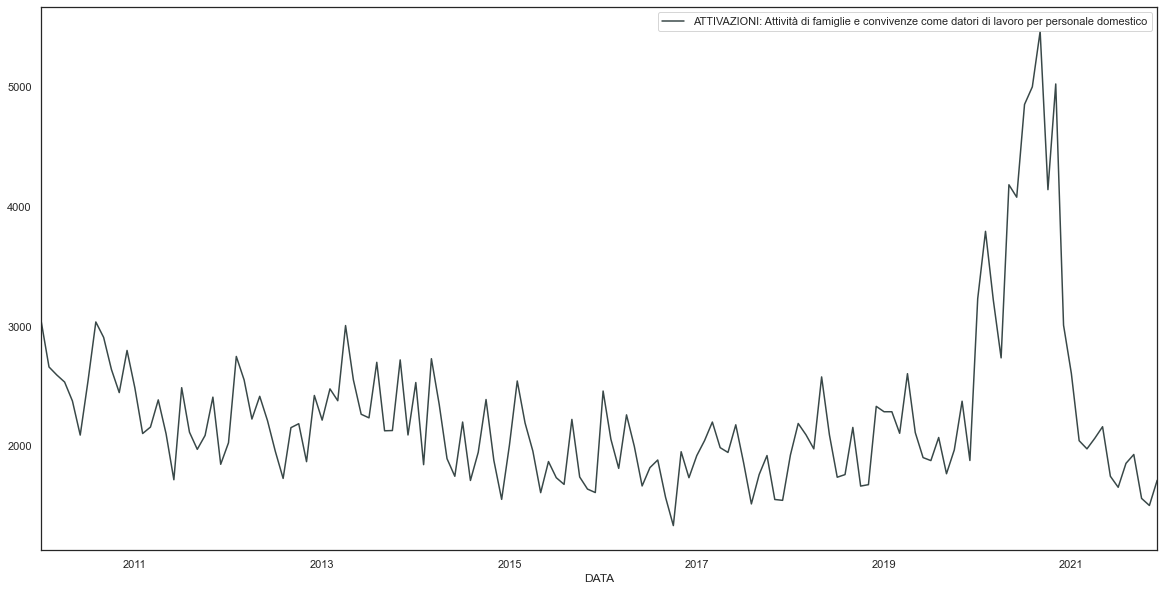

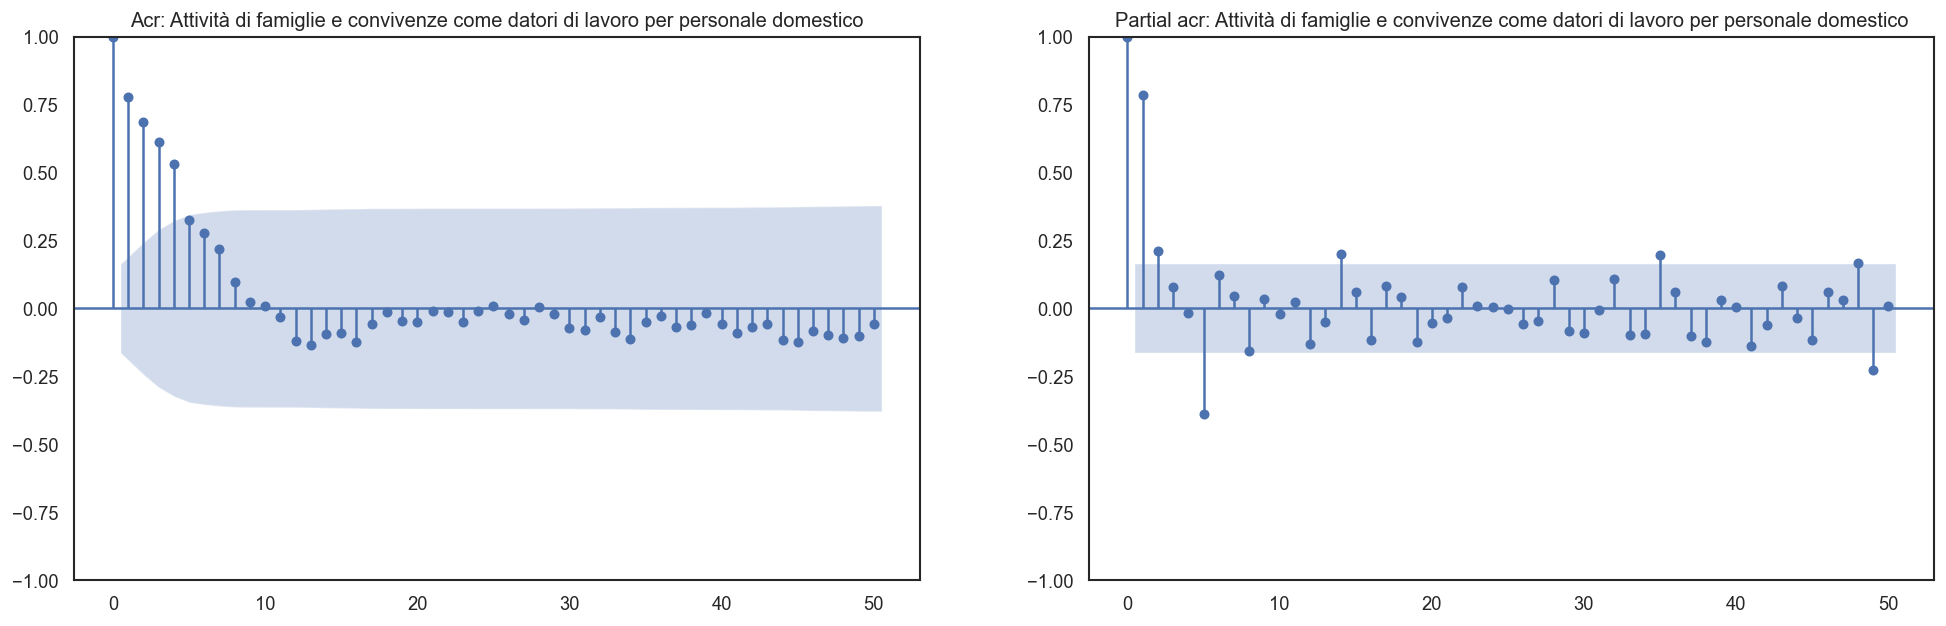

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


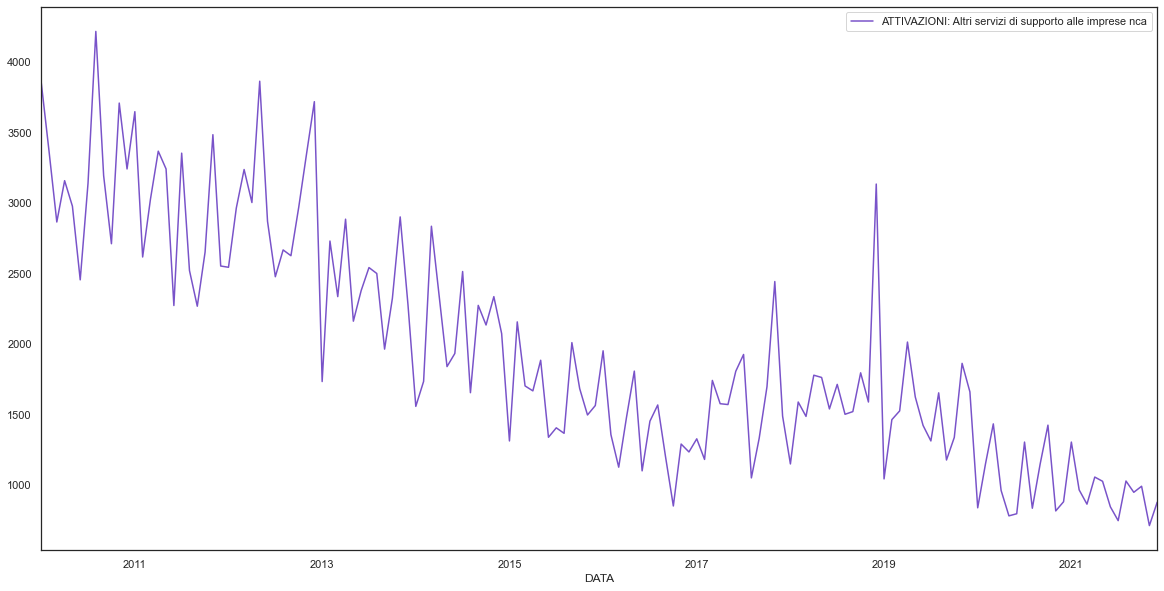

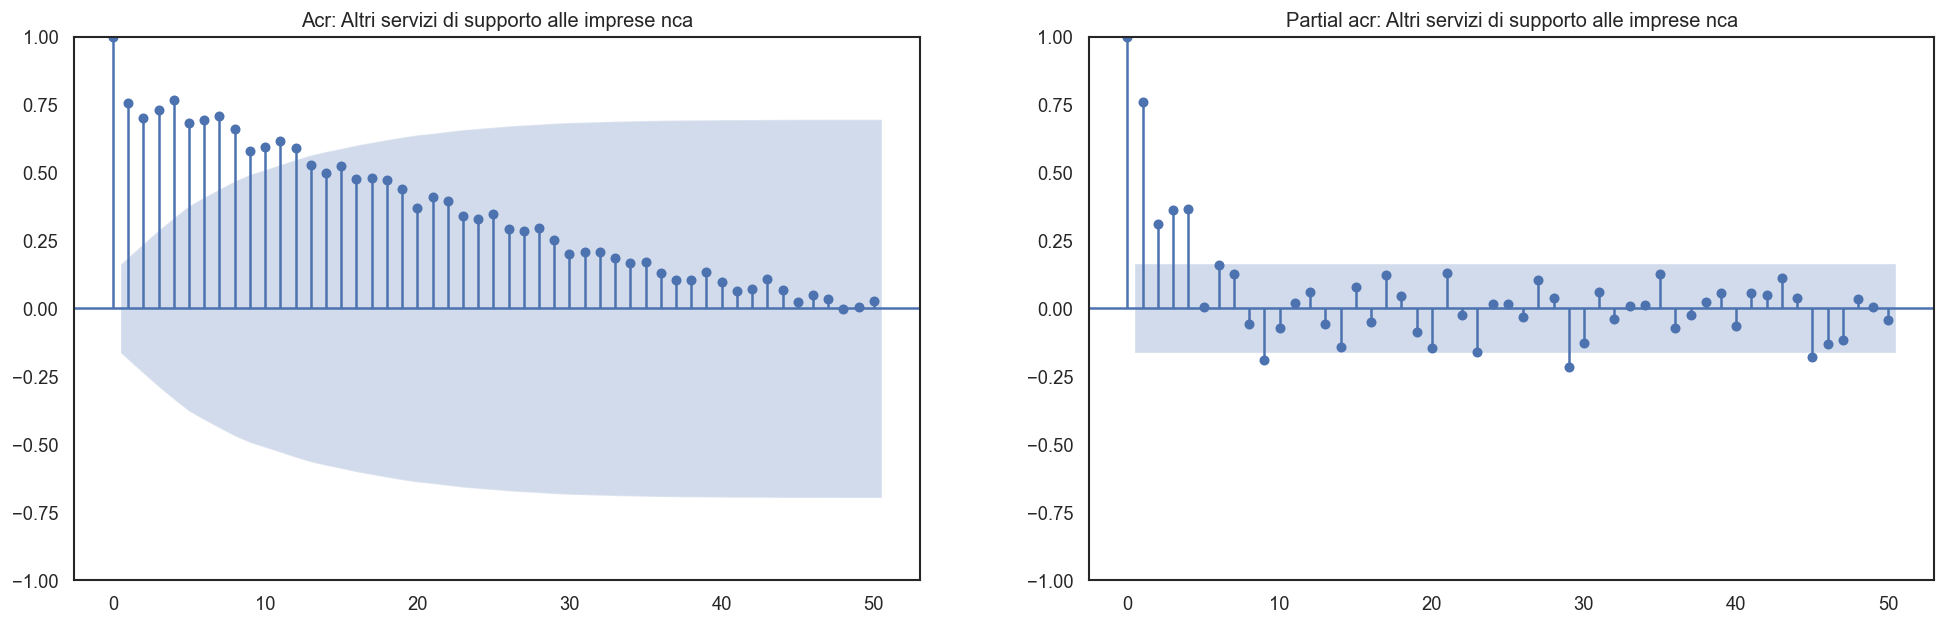

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


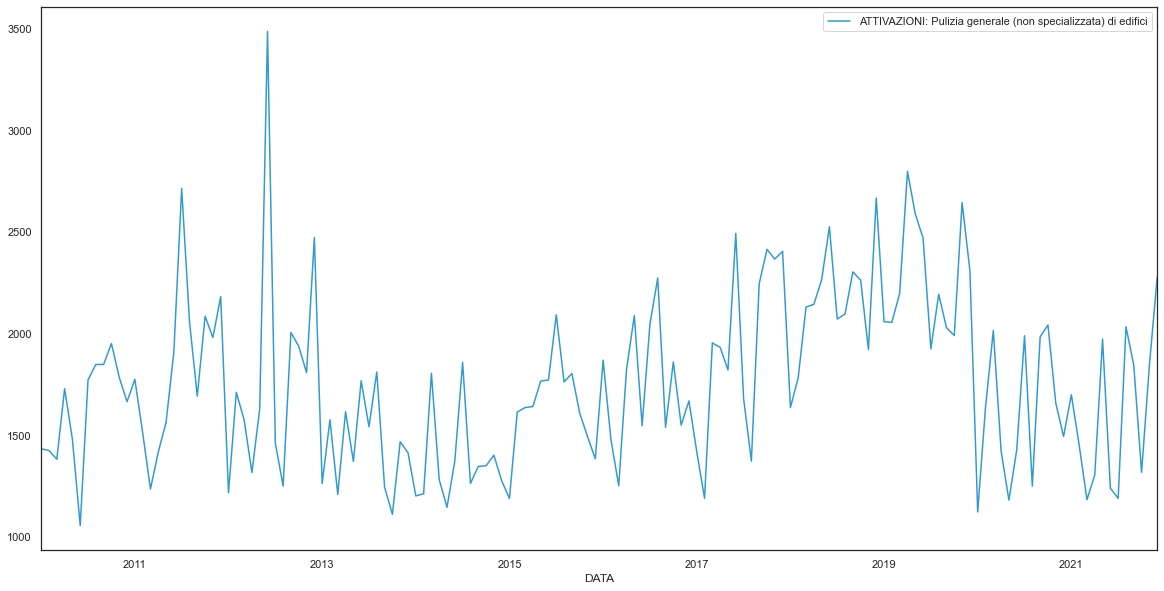

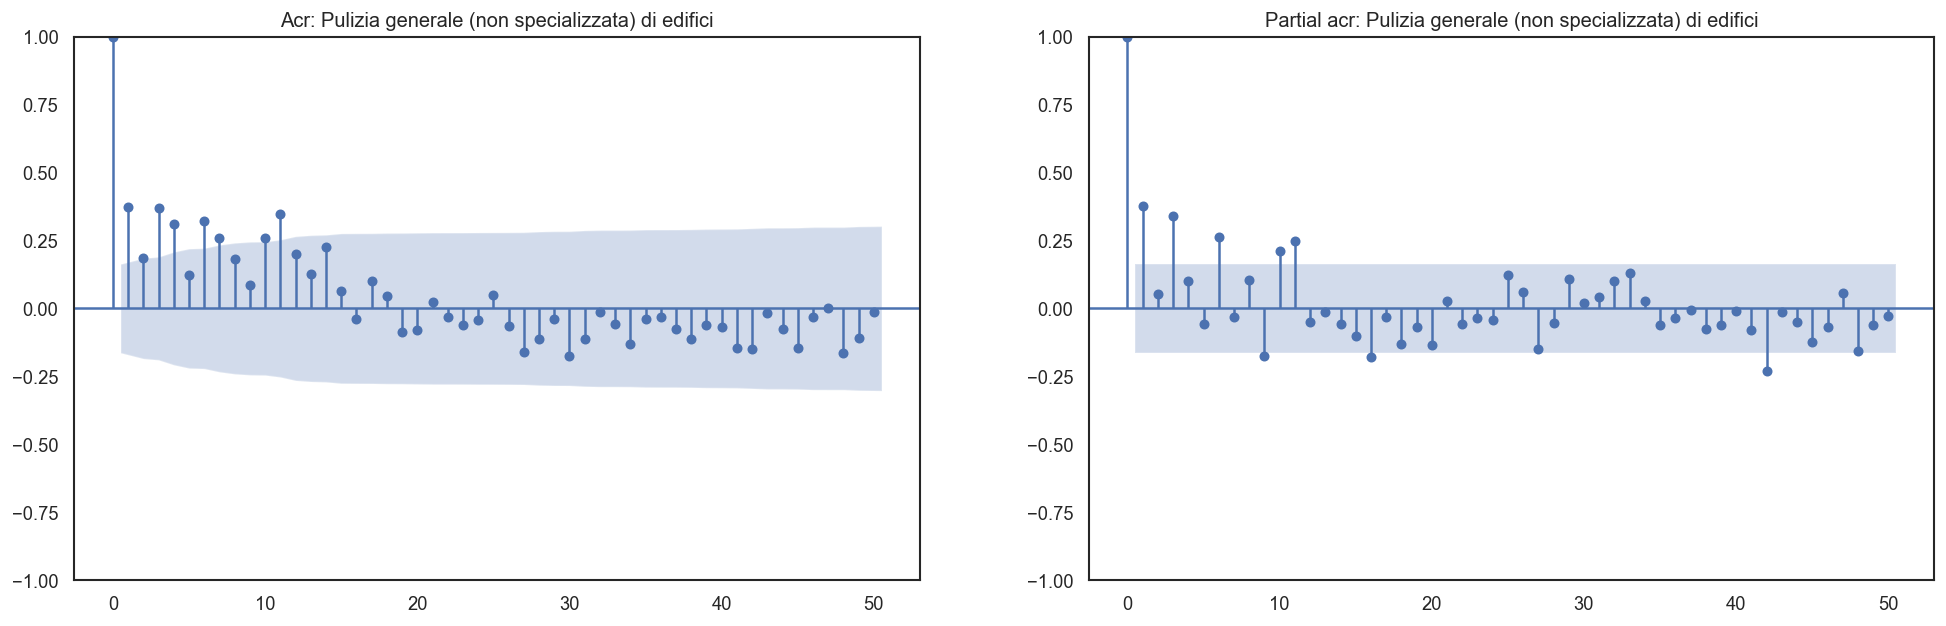

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


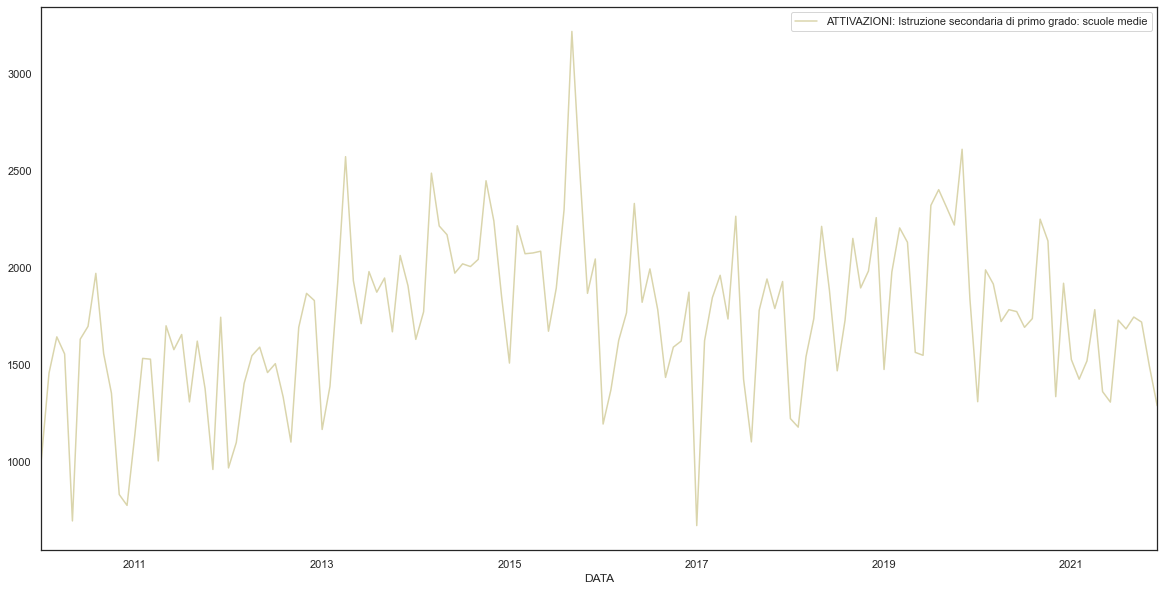

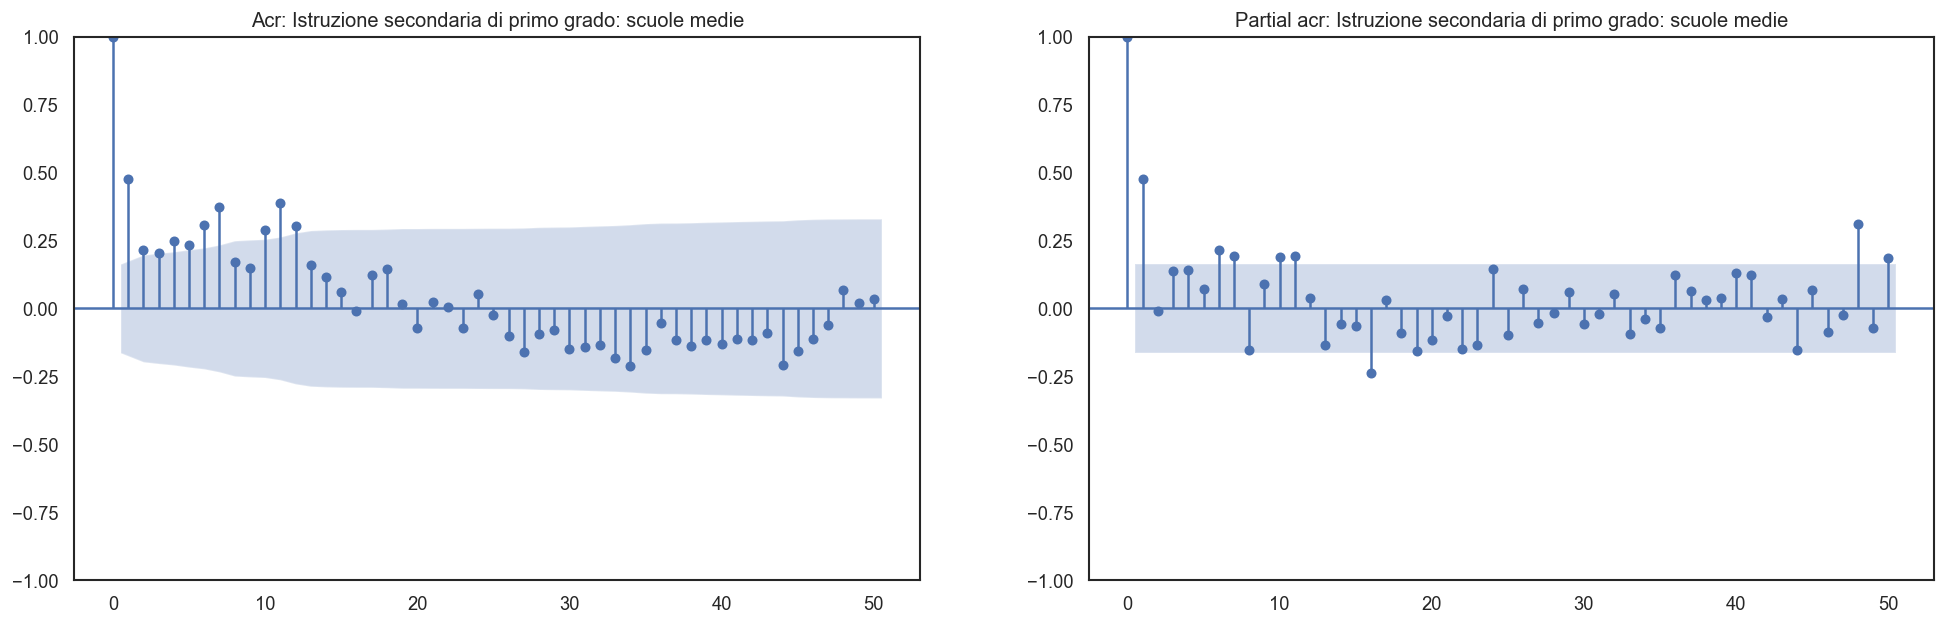

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


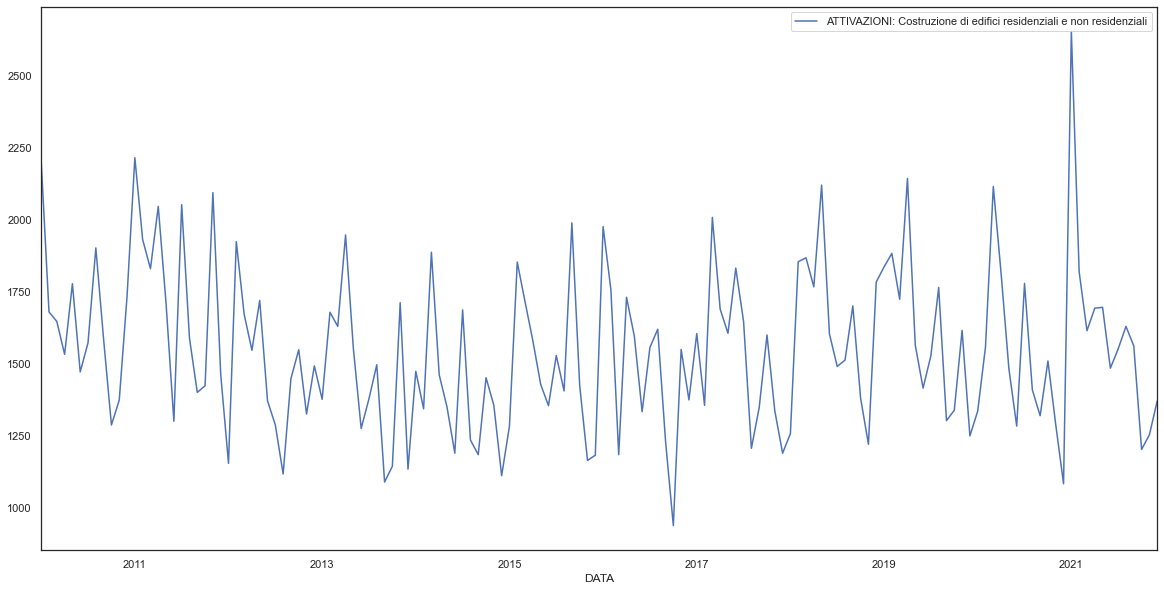

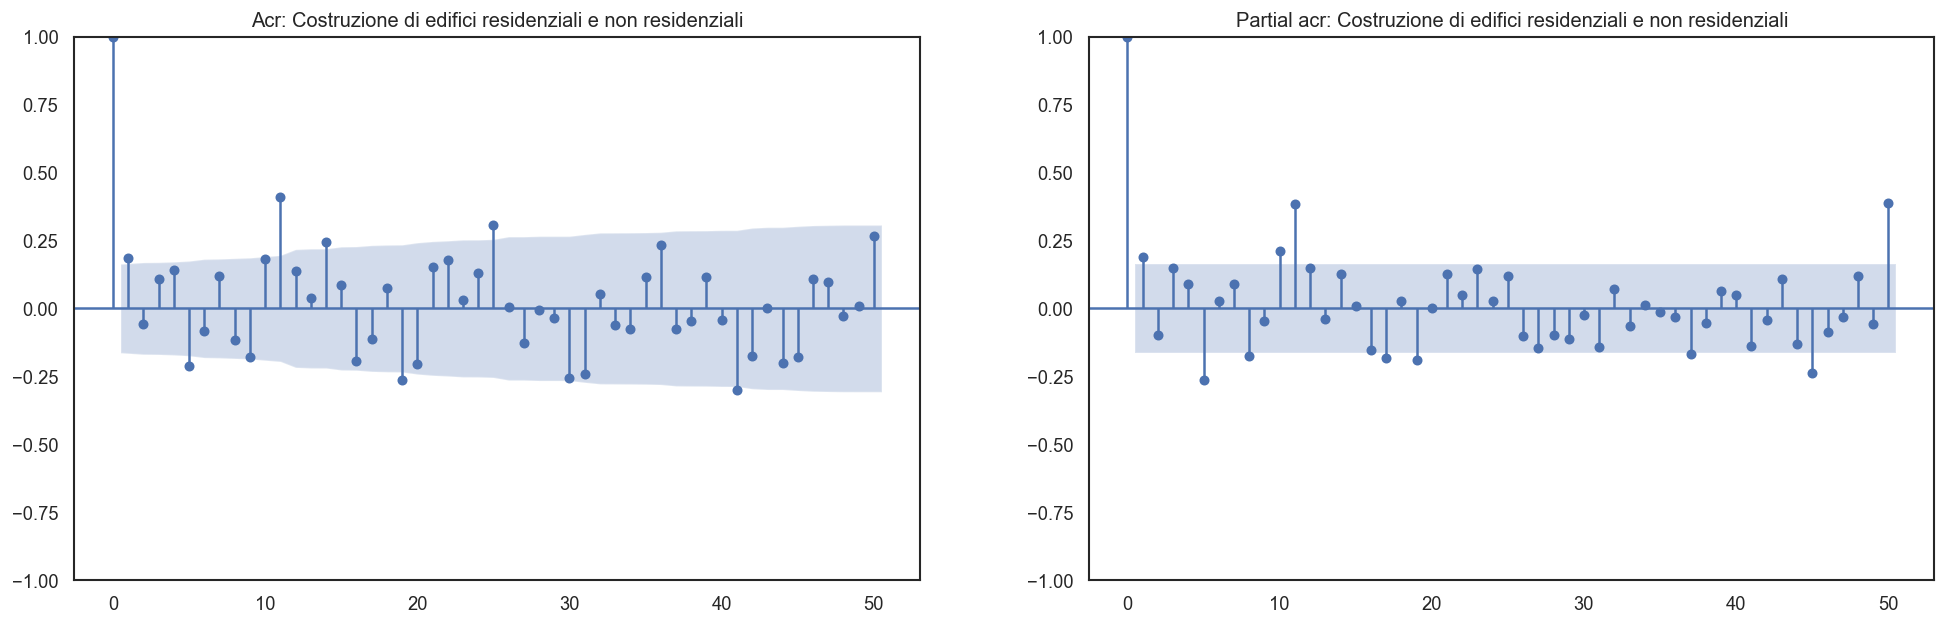

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


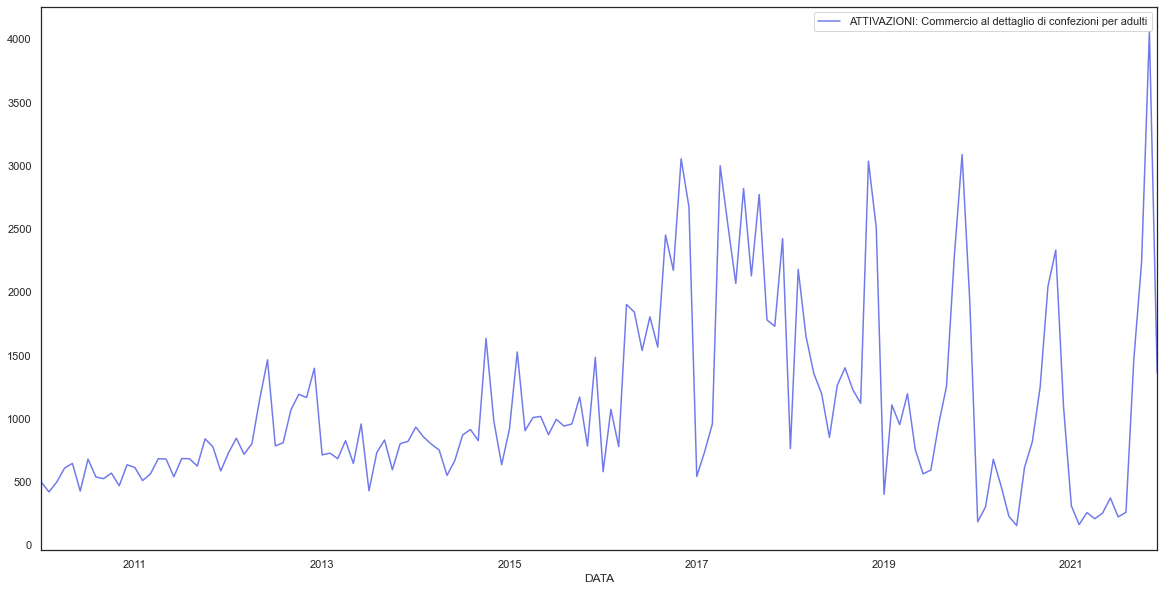

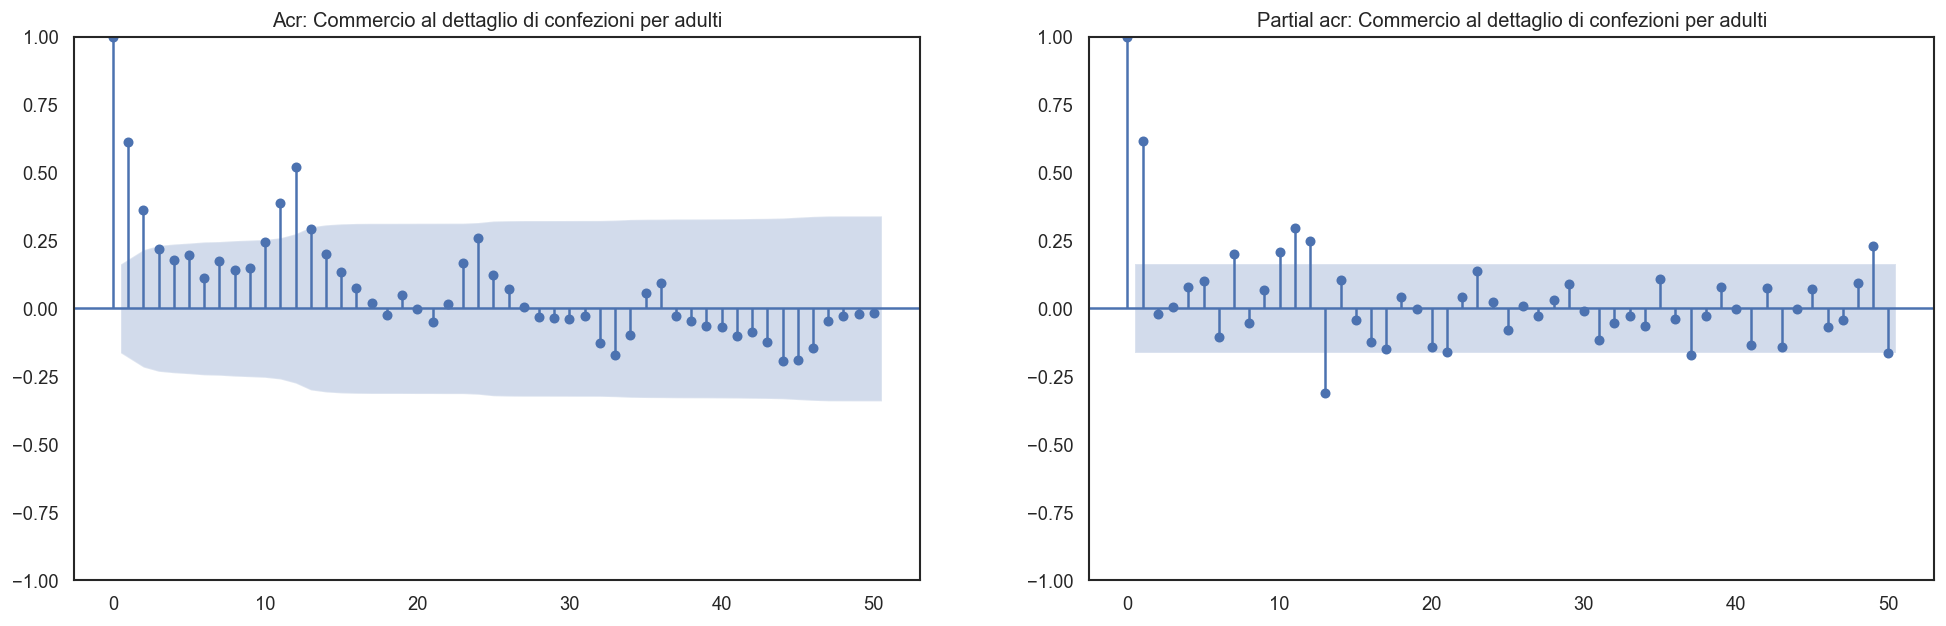

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


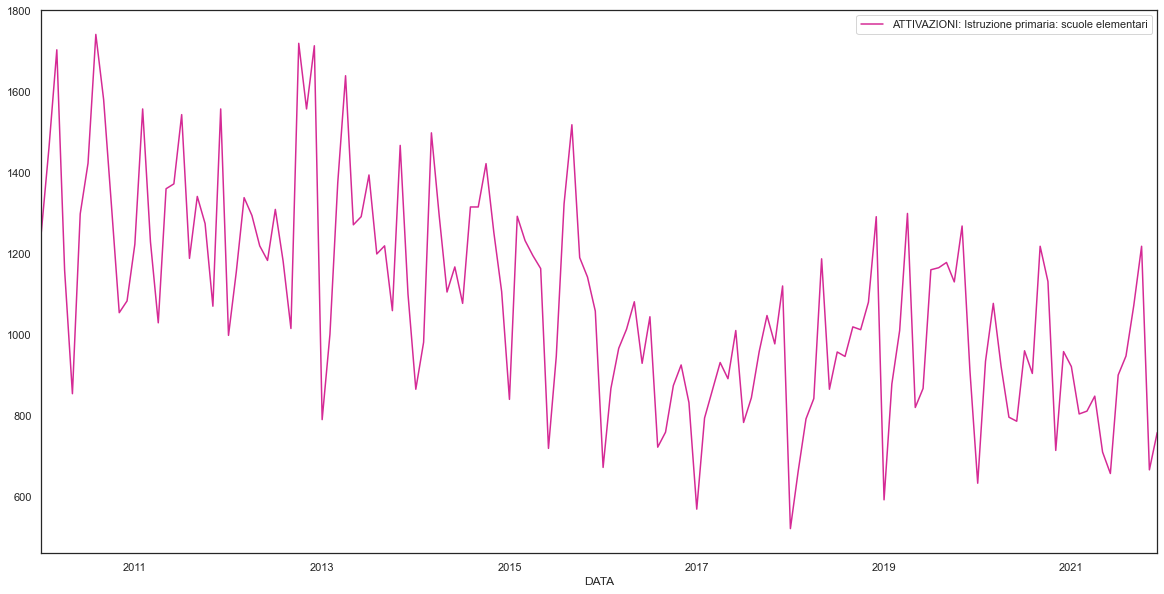

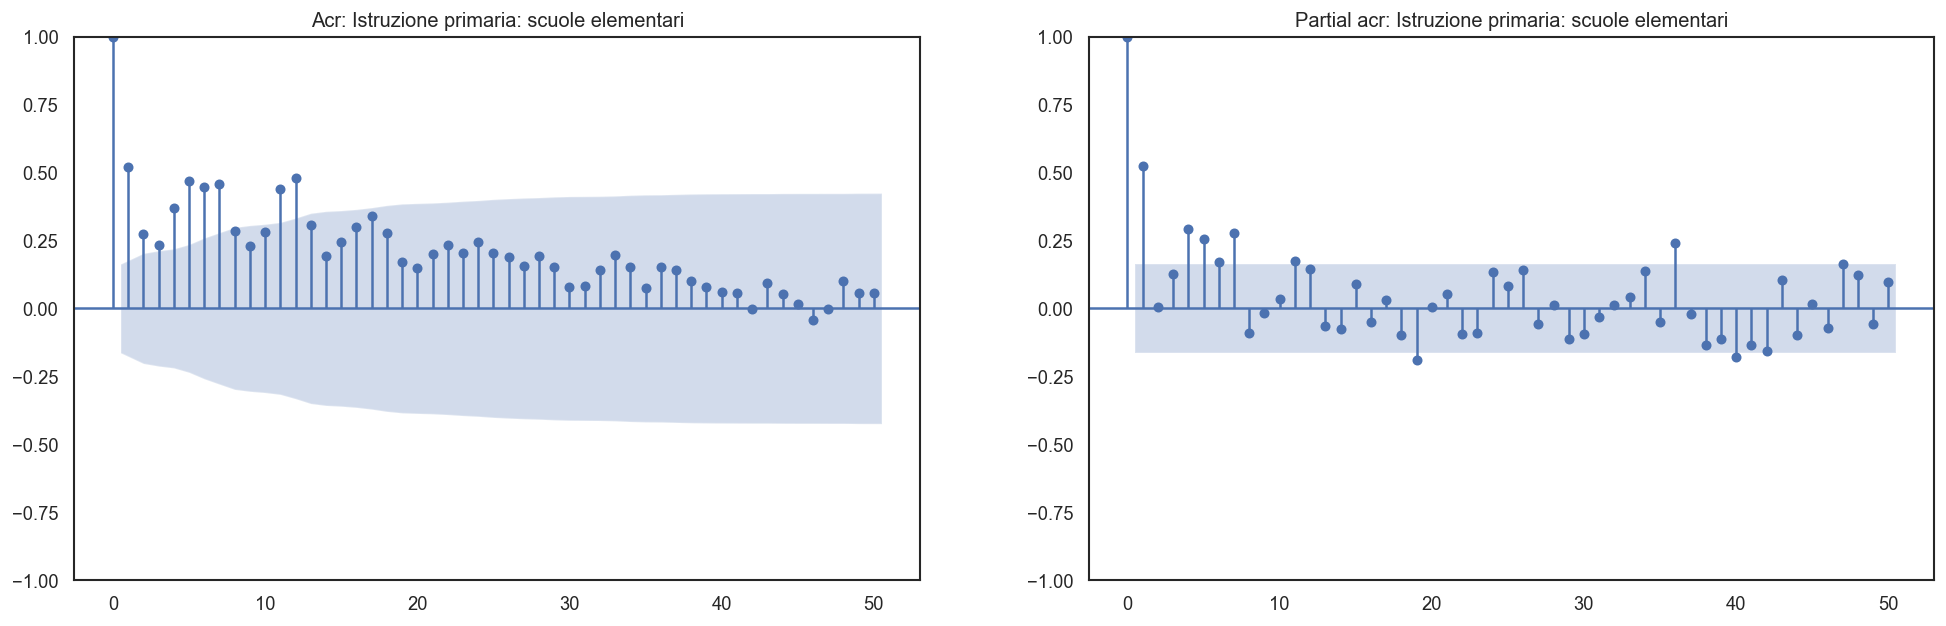

In [120]:

attFrames = []
for val in perAtt.index:  #visualize 
     na = attivHead.loc[(attivHead['SETTORE'] == val)]
     h = na.resample('M').count()
     attFrames.append(h)
     na2 = h.rename (columns = {'SETTORE' :
     ('ATTIVAZIONI: '+ val)}).loc[:, ['ATTIVAZIONI: '+ val,]]
     na2.plot(color=np.random.rand(3,), legend = val, figsize = (20,10))
     fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
     plot_acf(h.SETTORE.tolist(), lags=50, ax=axes[0],
     title =  'Acr: ' + val)
     plot_pacf(h.SETTORE.tolist(), lags=50, ax=axes[1],
     title = 'Partial acr: '+ val)
     plt.show()

In [121]:
attFrames

[            CONTRATTO  CONTR_N  SETTORE  SETT_ID  STATO   ETA  GENERE  DATE  \
 DATA                                                                          
 2010-01-31       3767     3767     3767     3767   3767  3767    3767  3767   
 2010-02-28       3592     3592     3592     3592   3592  3592    3592  3592   
 2010-03-31       3528     3528     3528     3528   3528  3528    3528  3528   
 2010-04-30       3293     3293     3293     3293   3293  3293    3293  3293   
 2010-05-31       3823     3823     3823     3823   3823  3823    3823  3823   
 ...               ...      ...      ...      ...    ...   ...     ...   ...   
 2021-08-31        789      789      789      789    789   789     789   789   
 2021-09-30       1174     1174     1174     1174   1174  1174    1174  1174   
 2021-10-31       1337     1337     1337     1337   1337  1337    1337  1337   
 2021-11-30        946      946      946      946    946   946     946   946   
 2021-12-31        782      782      782

In [122]:
len(attFrames[0])

144

5. - ANALISI TEMPORALE E PREPARAZIONE DEI DATI PER L'IMPLEMENTAZIONE DI UN MODELLO DI PREDITTIVITÀ CHE CONSIDERI ANDAMENTO DEL MERCATO LAVORATIVO SU ATTIVAZIONI E CESSAZIONI:  

         Visualizzazione dele serie temporali mensili per i dieci tipi di contratti cessati più frequentemente

  

CESSATI ORA

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


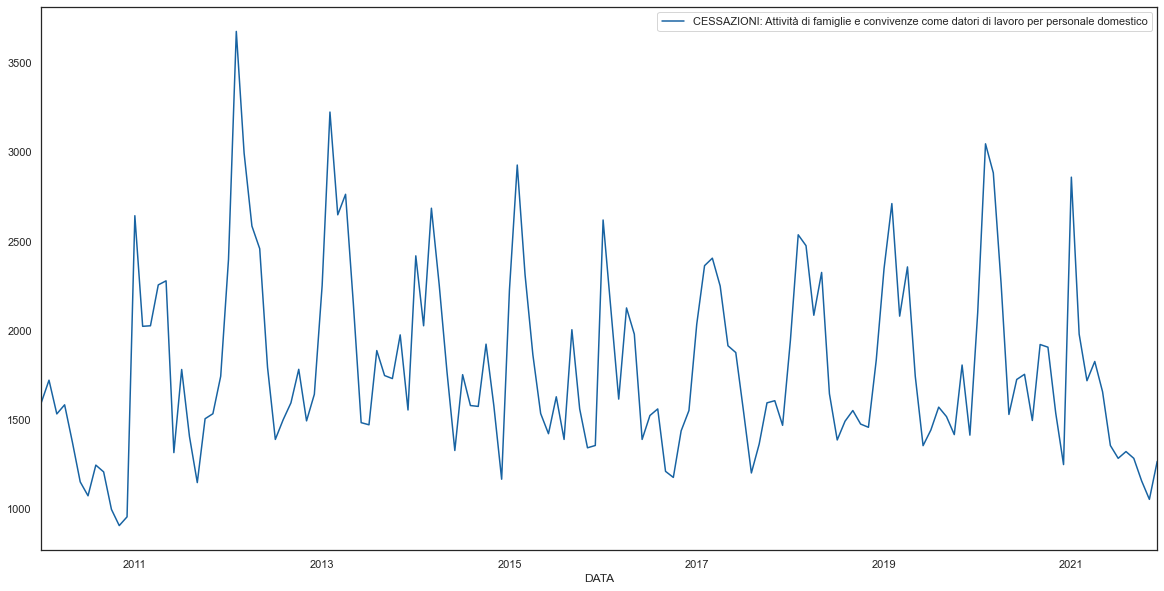

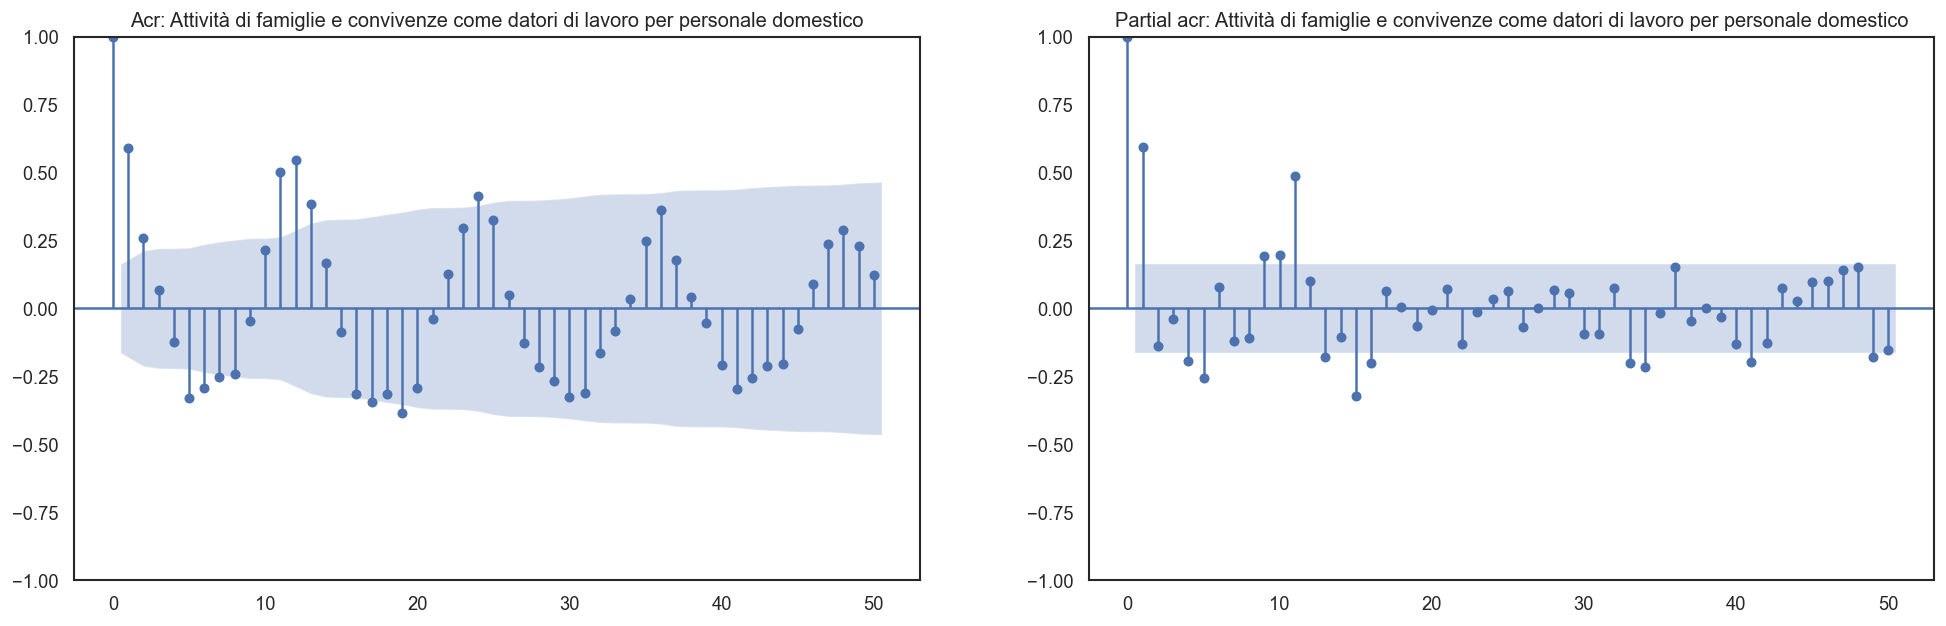

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


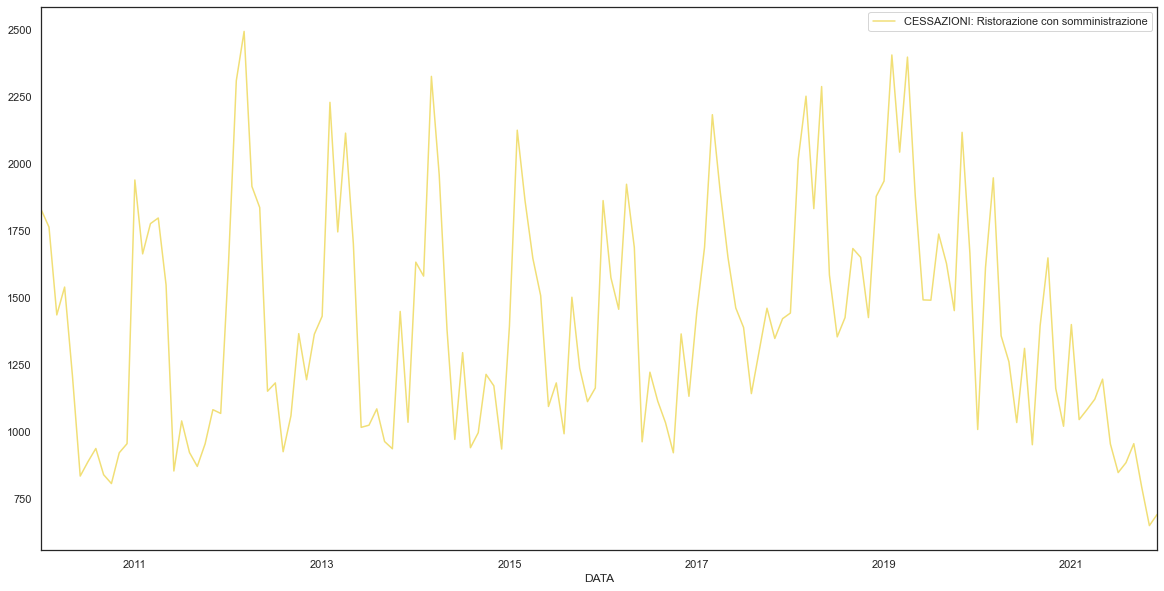

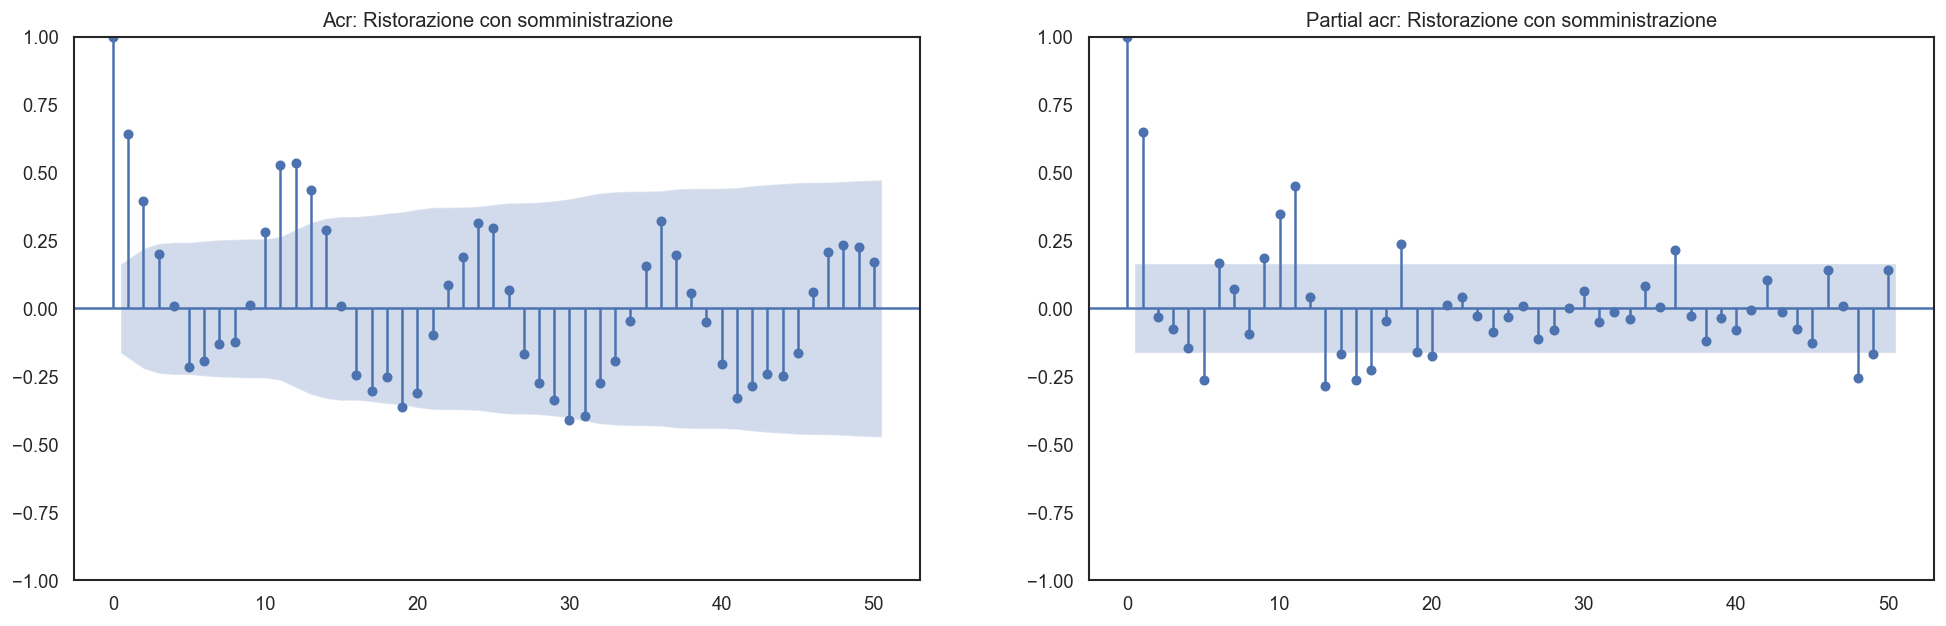

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


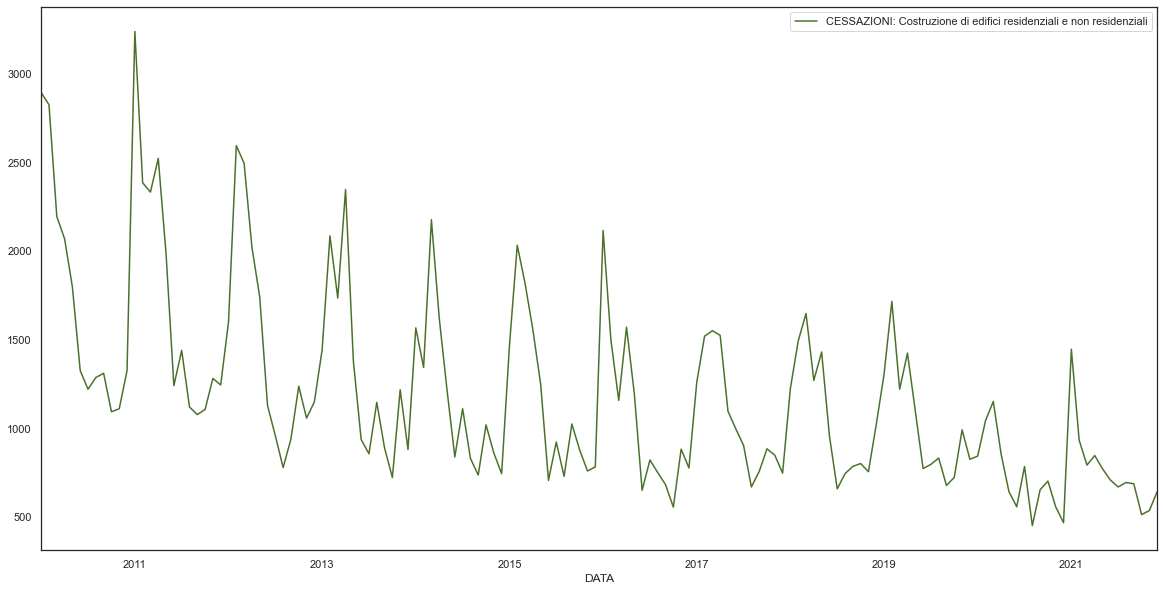

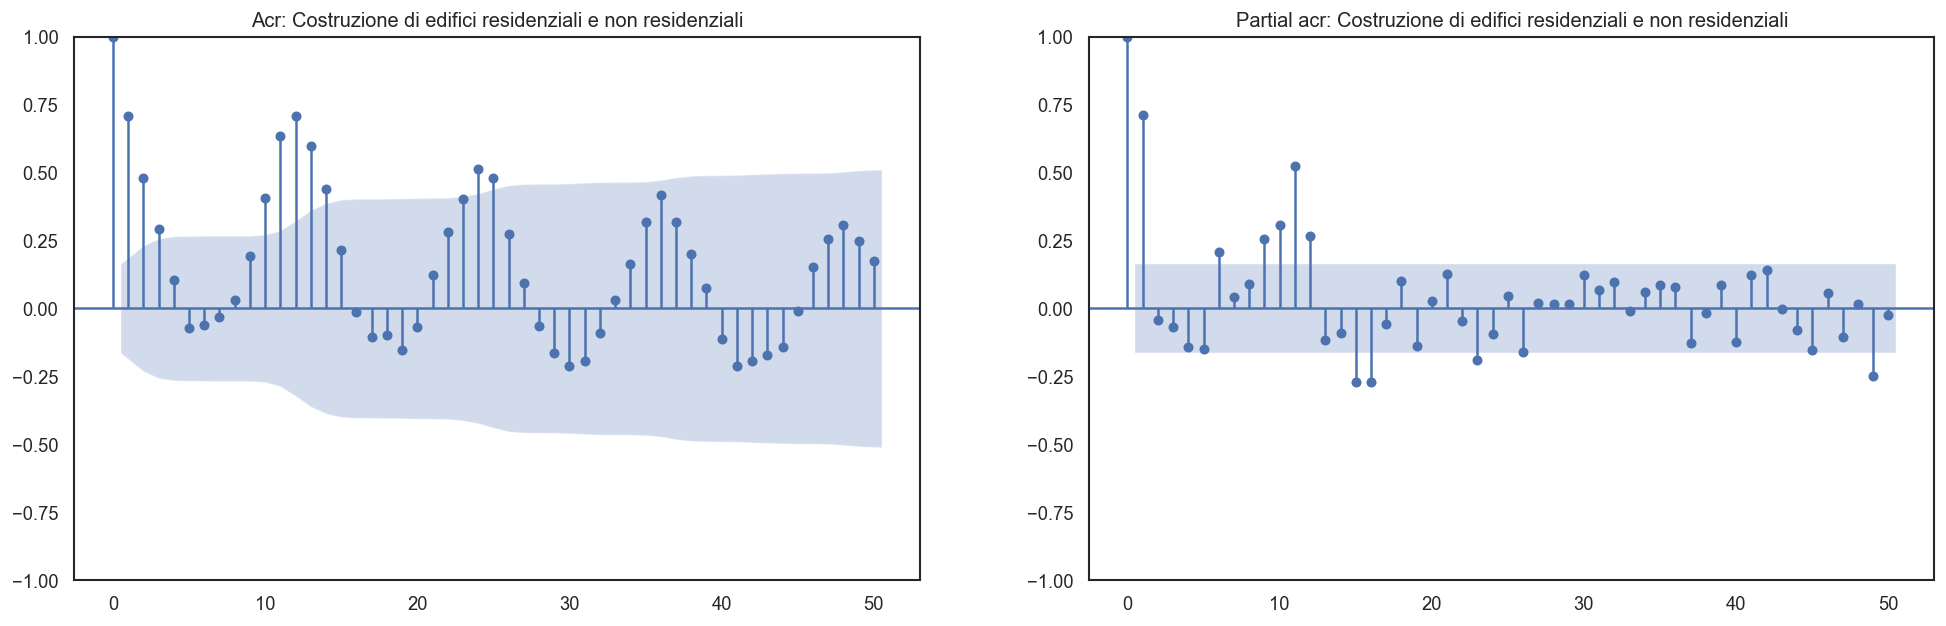

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


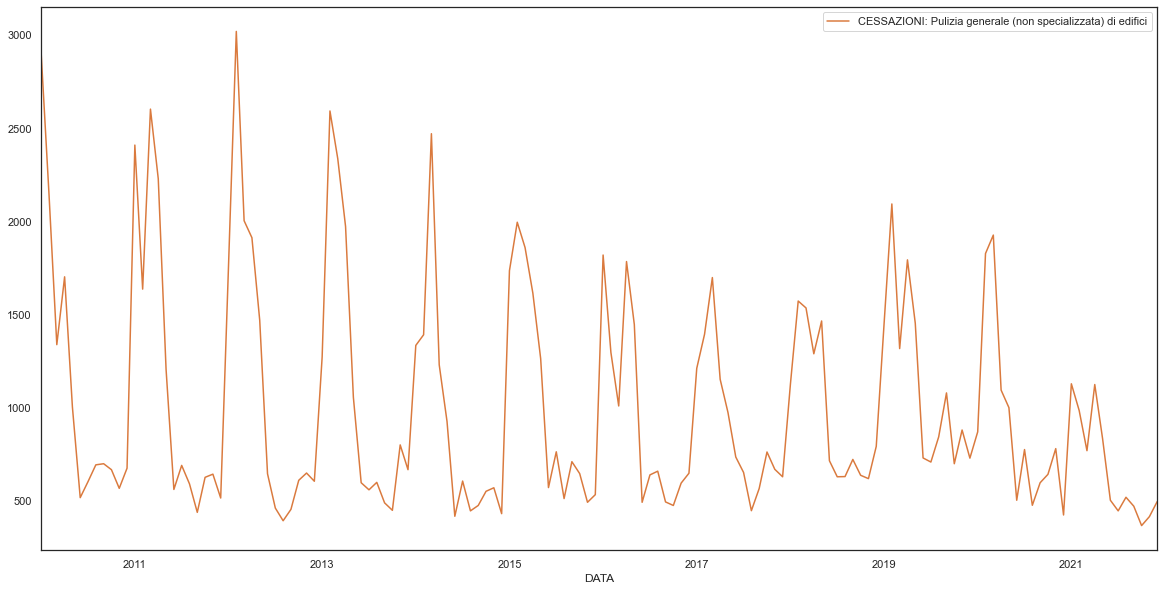

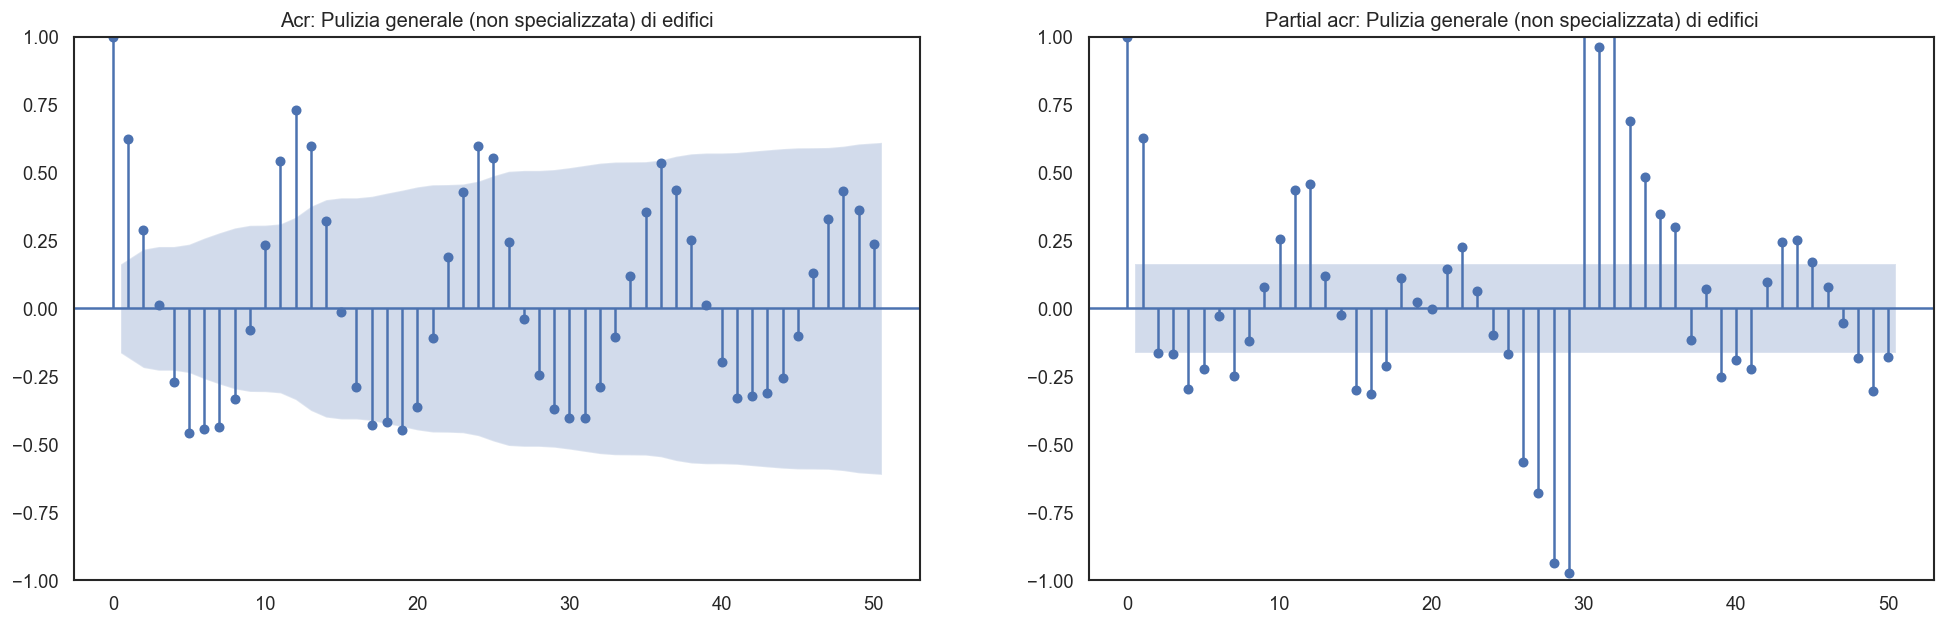

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


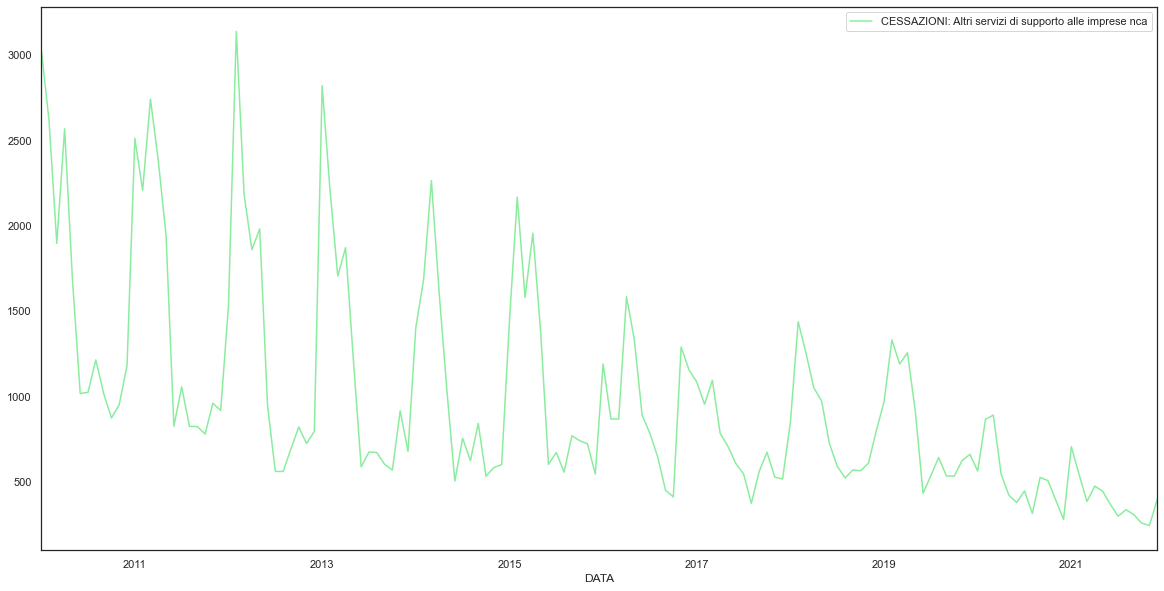

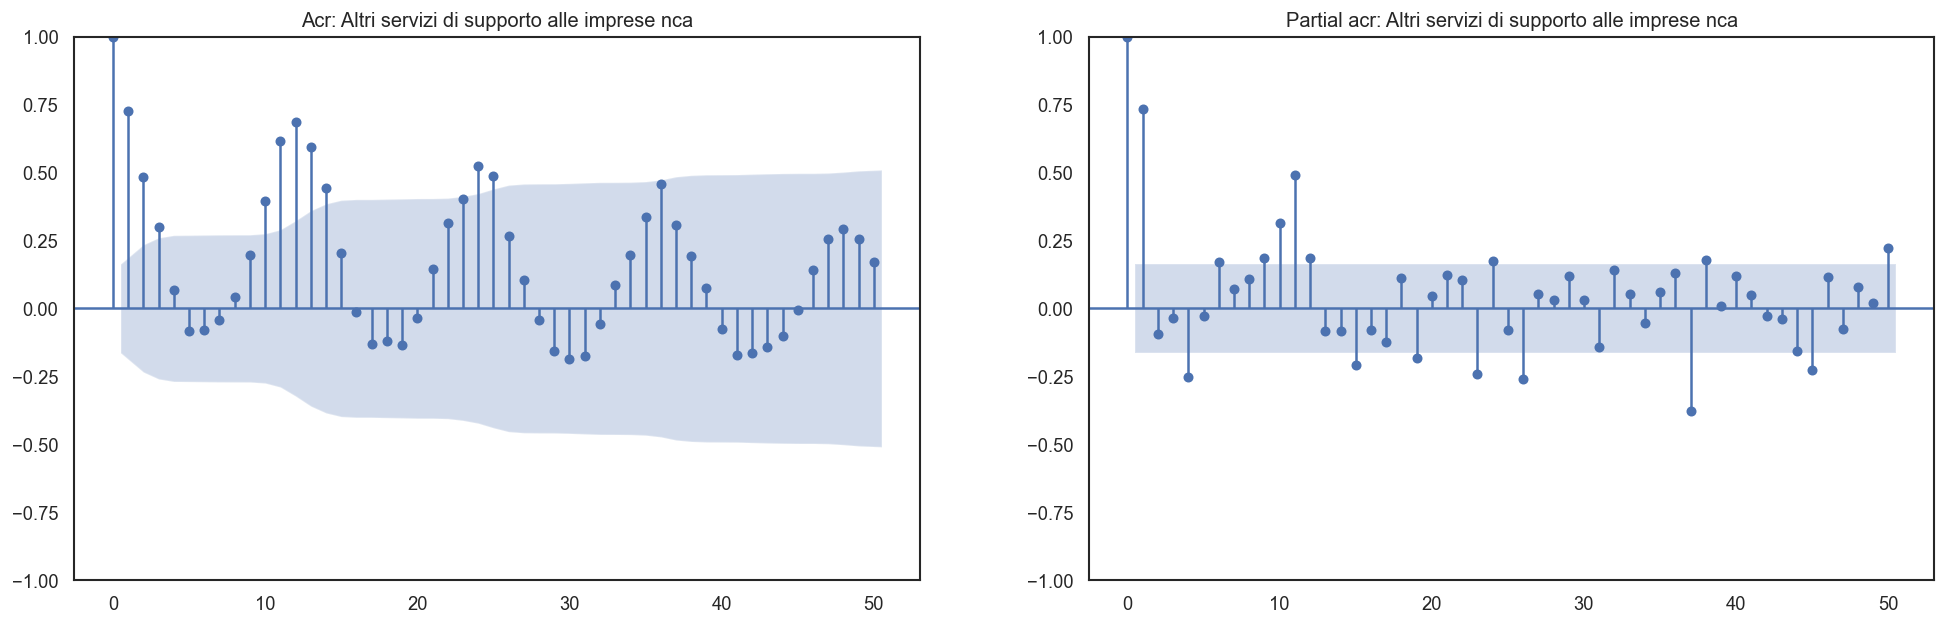

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


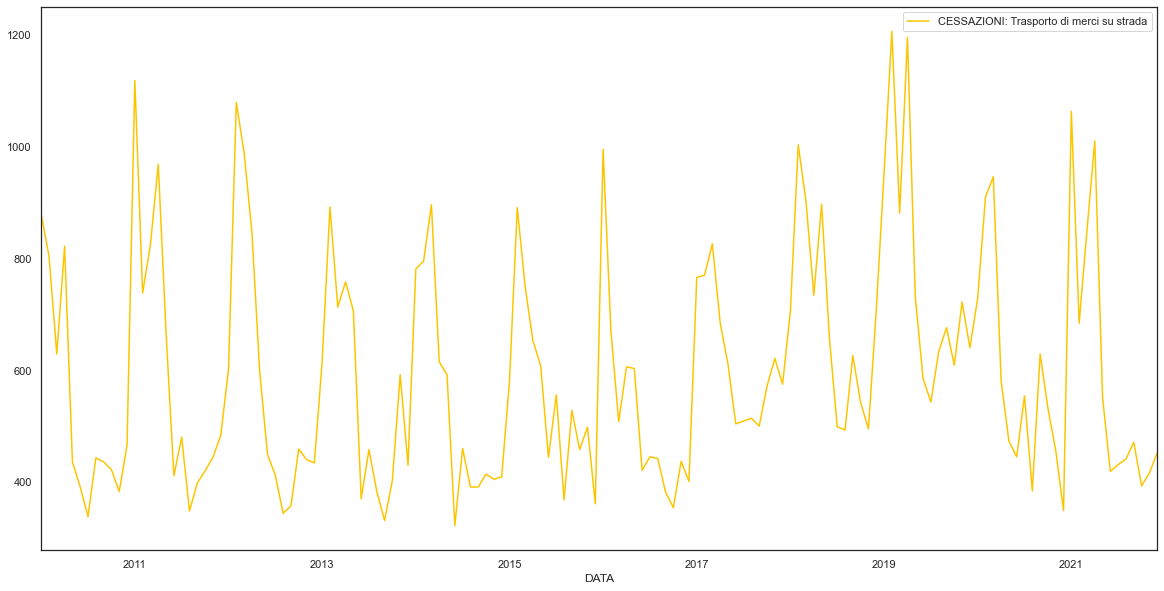

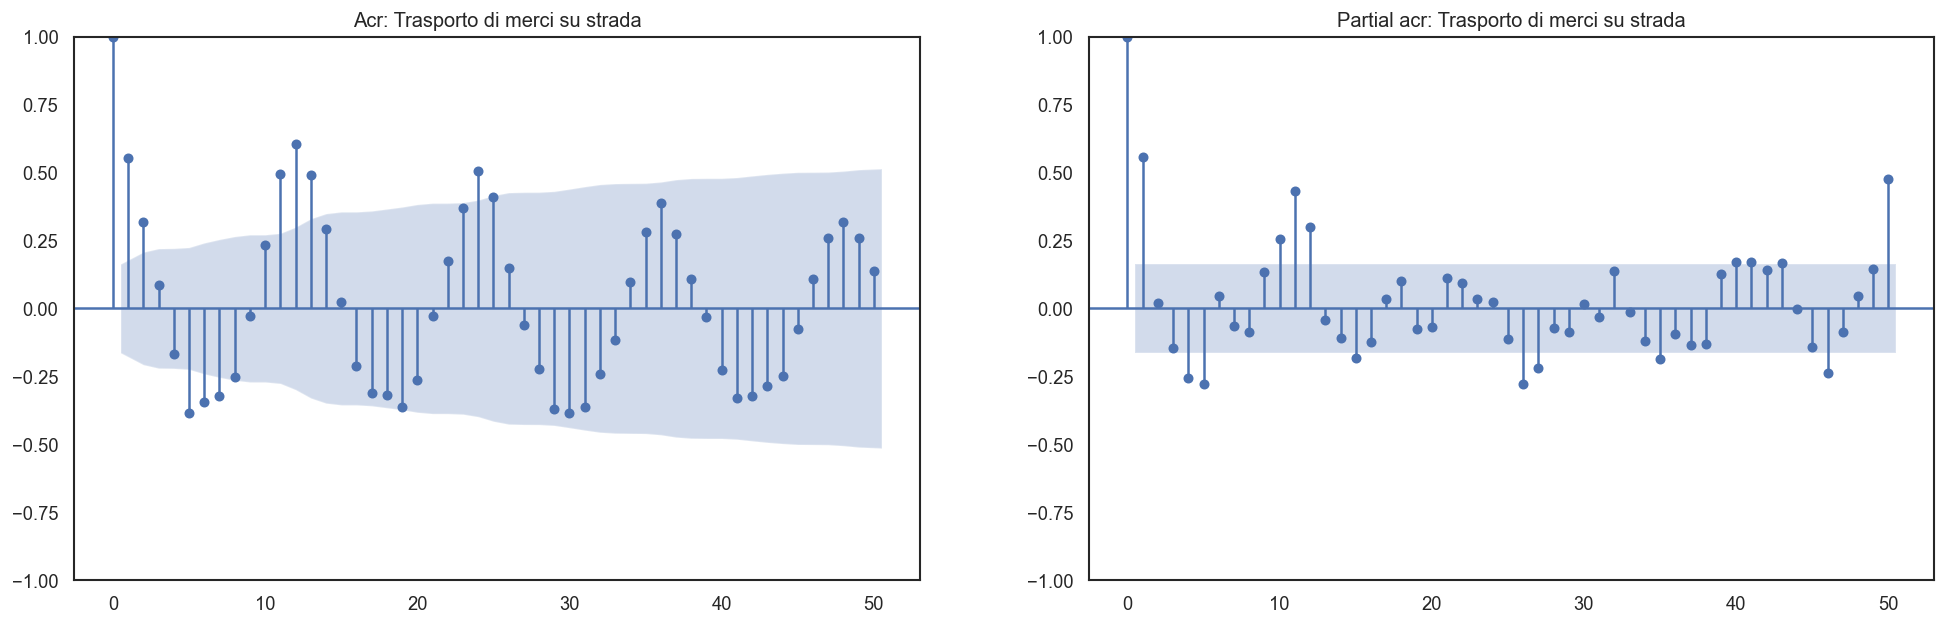

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


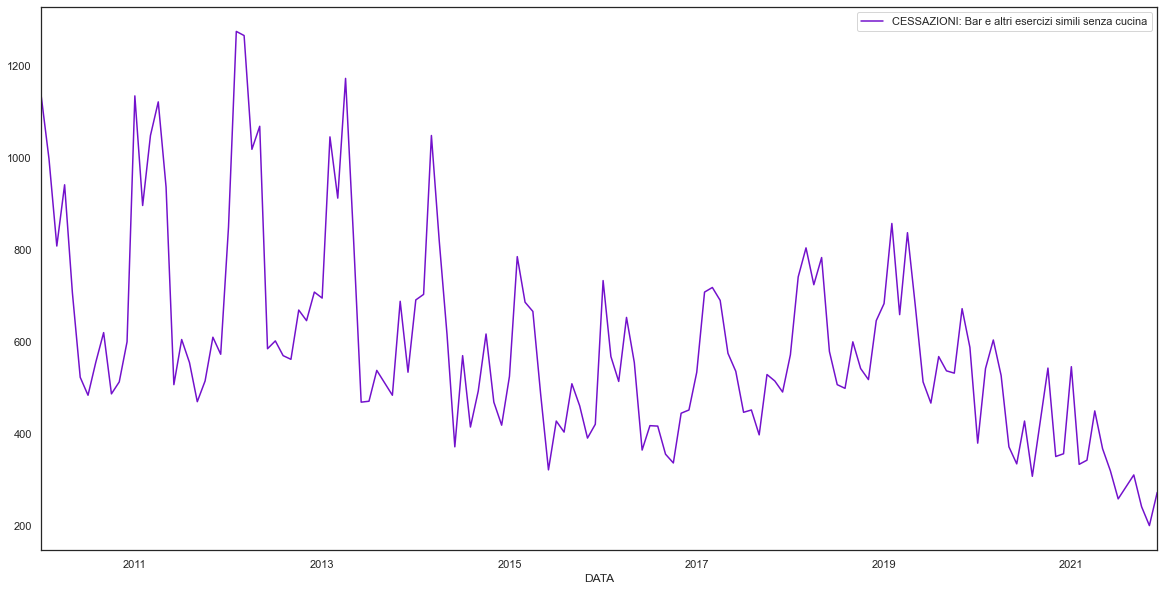

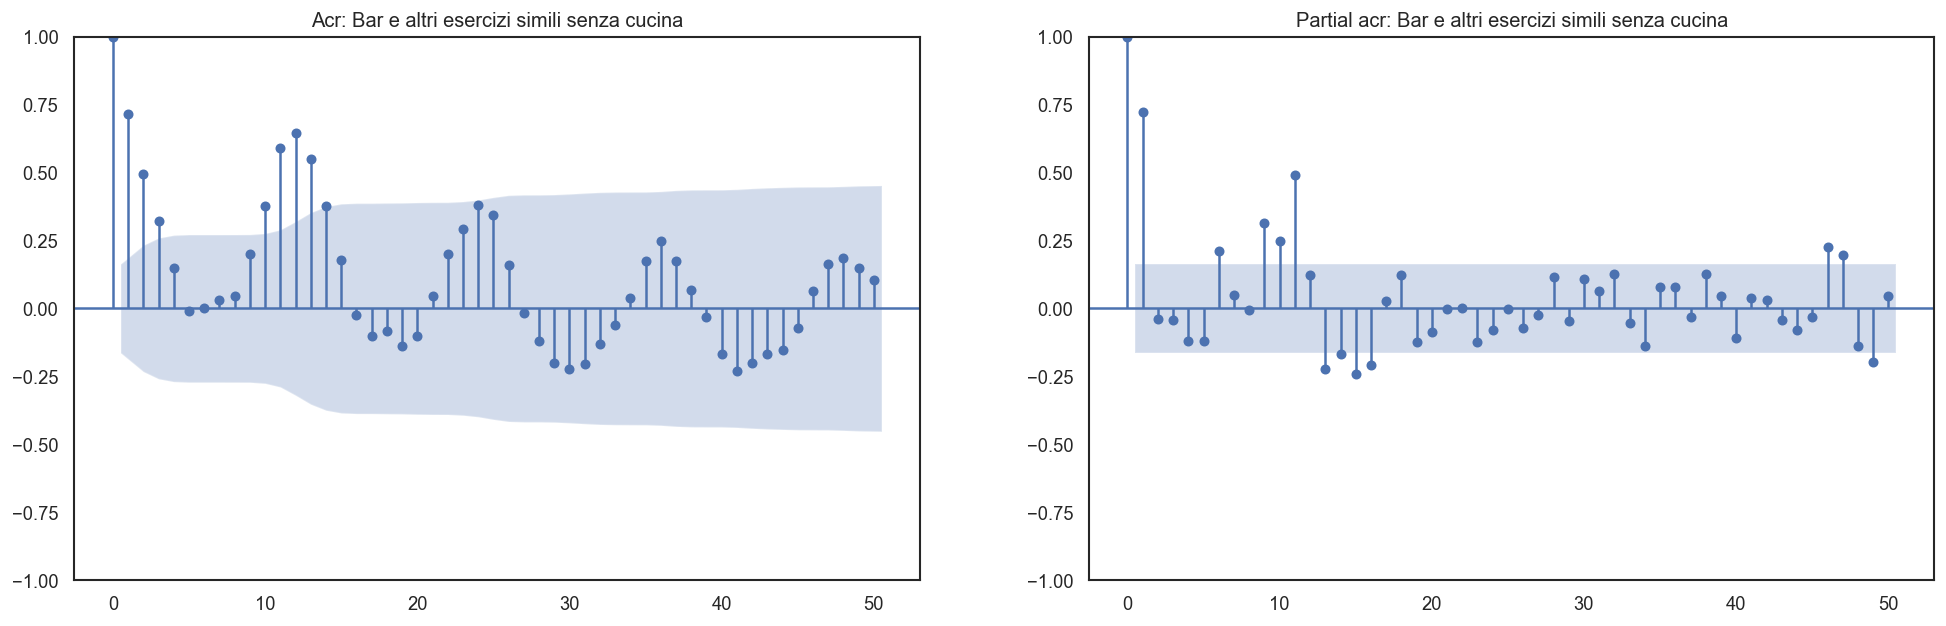

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


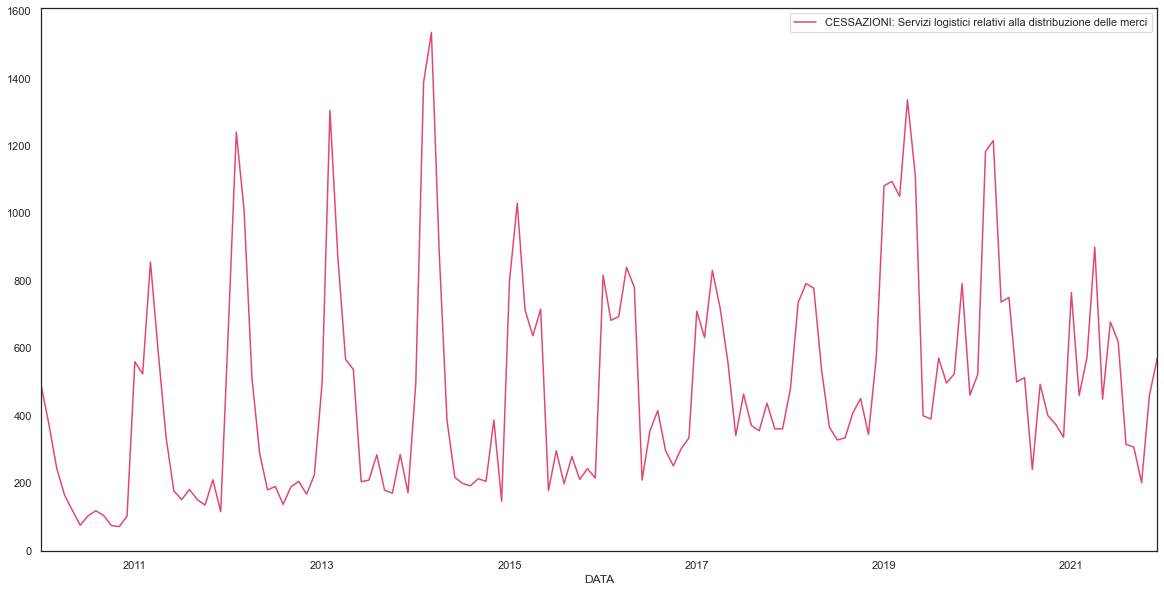

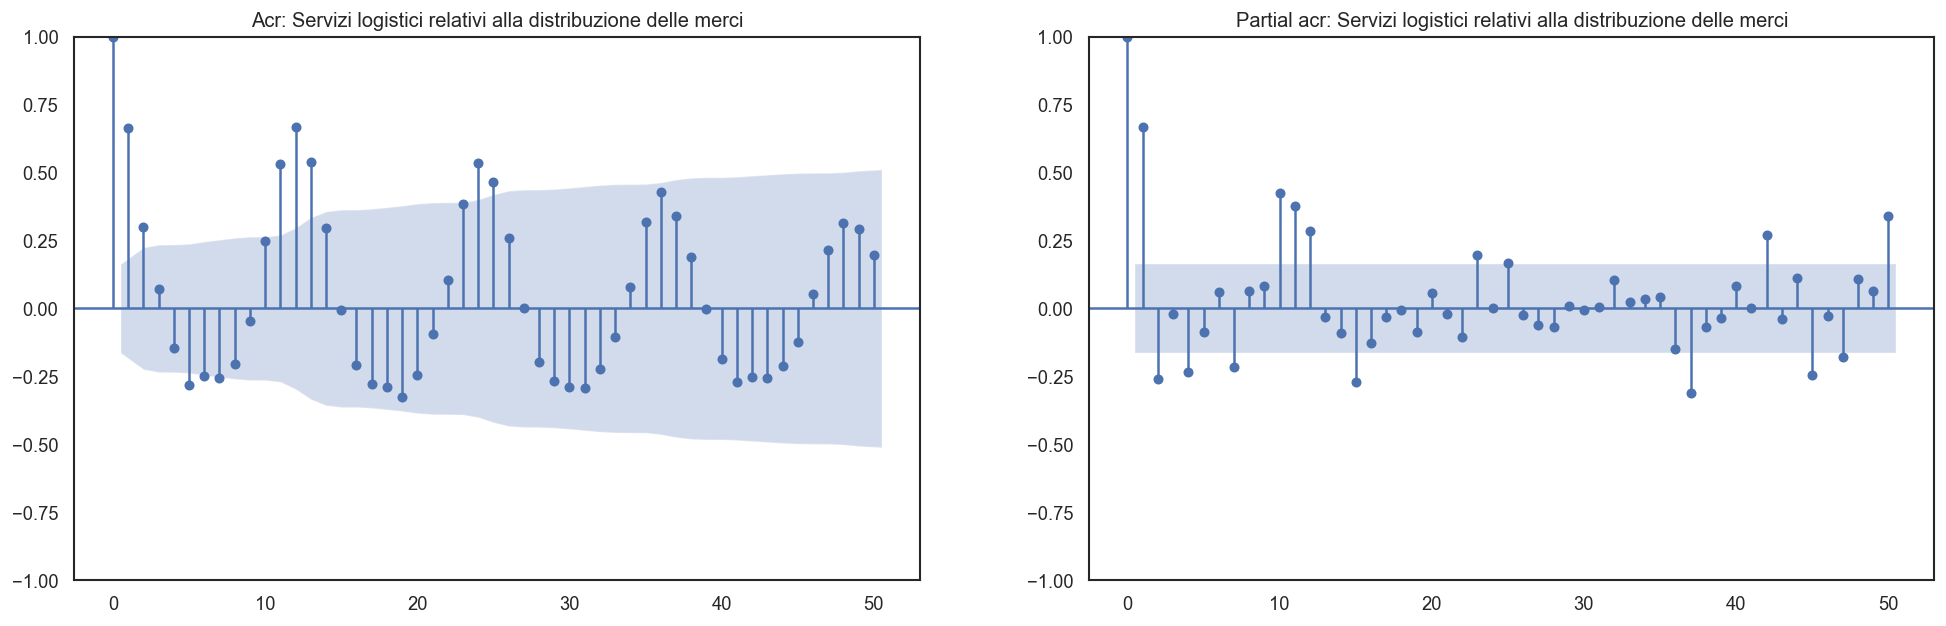

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


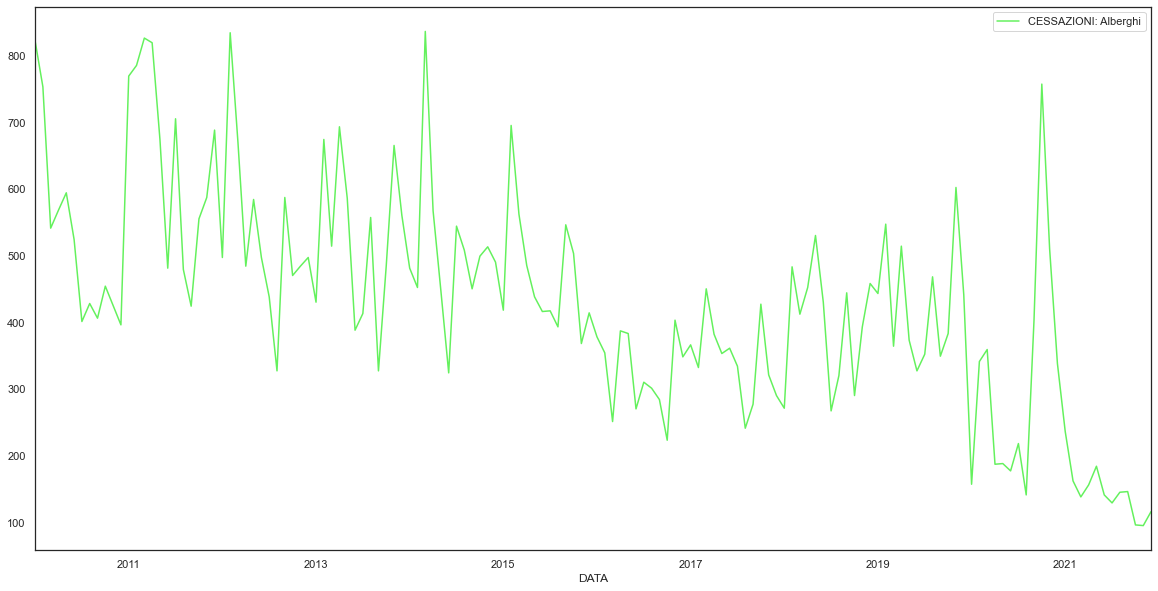

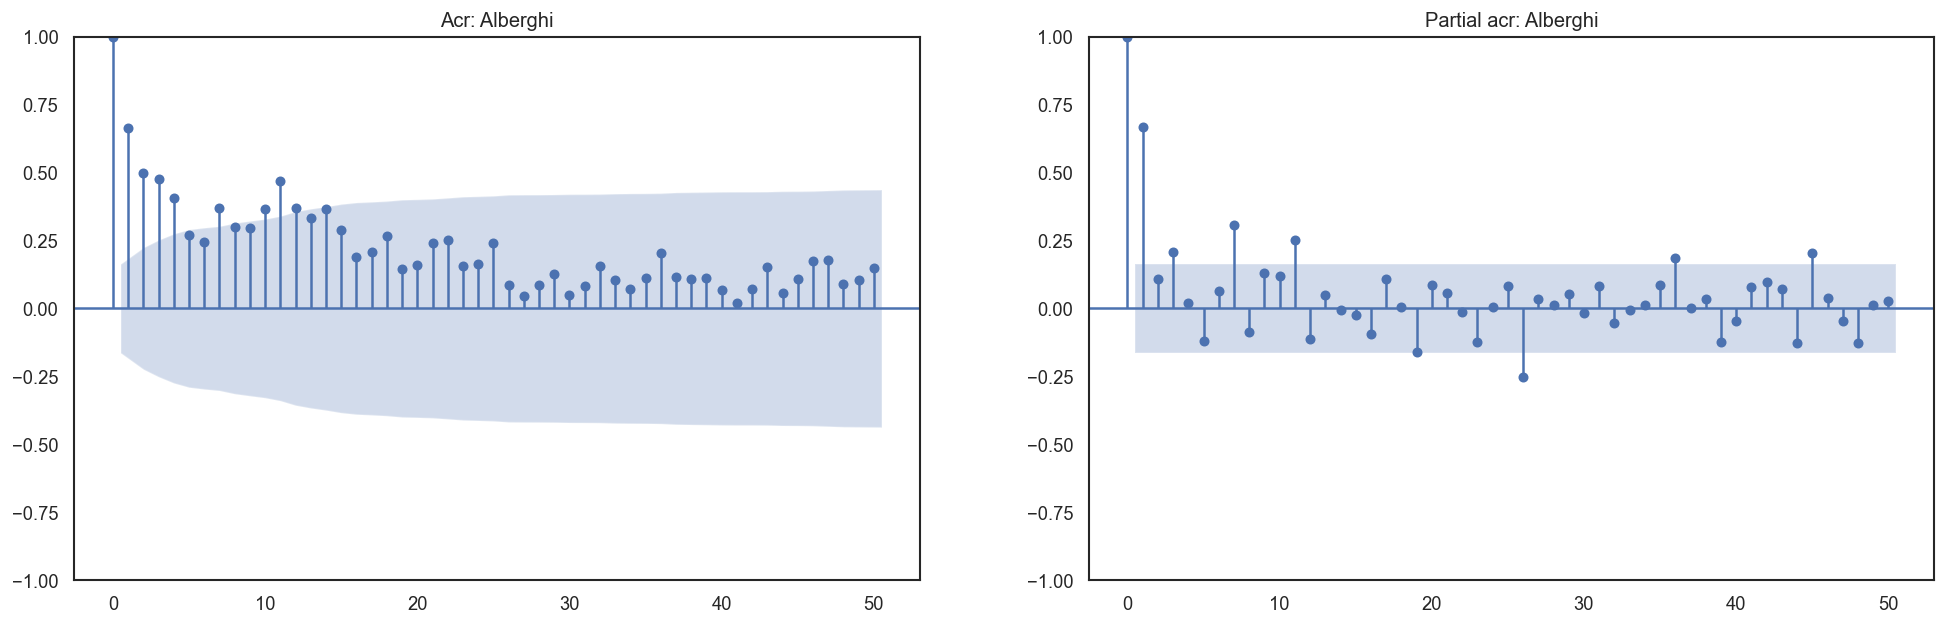

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


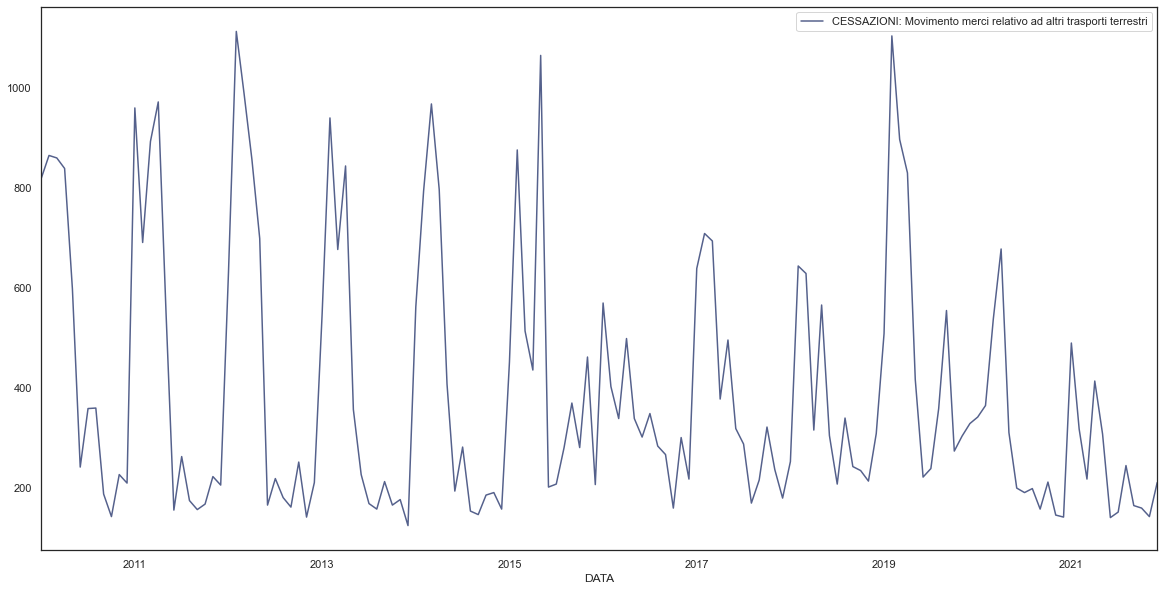

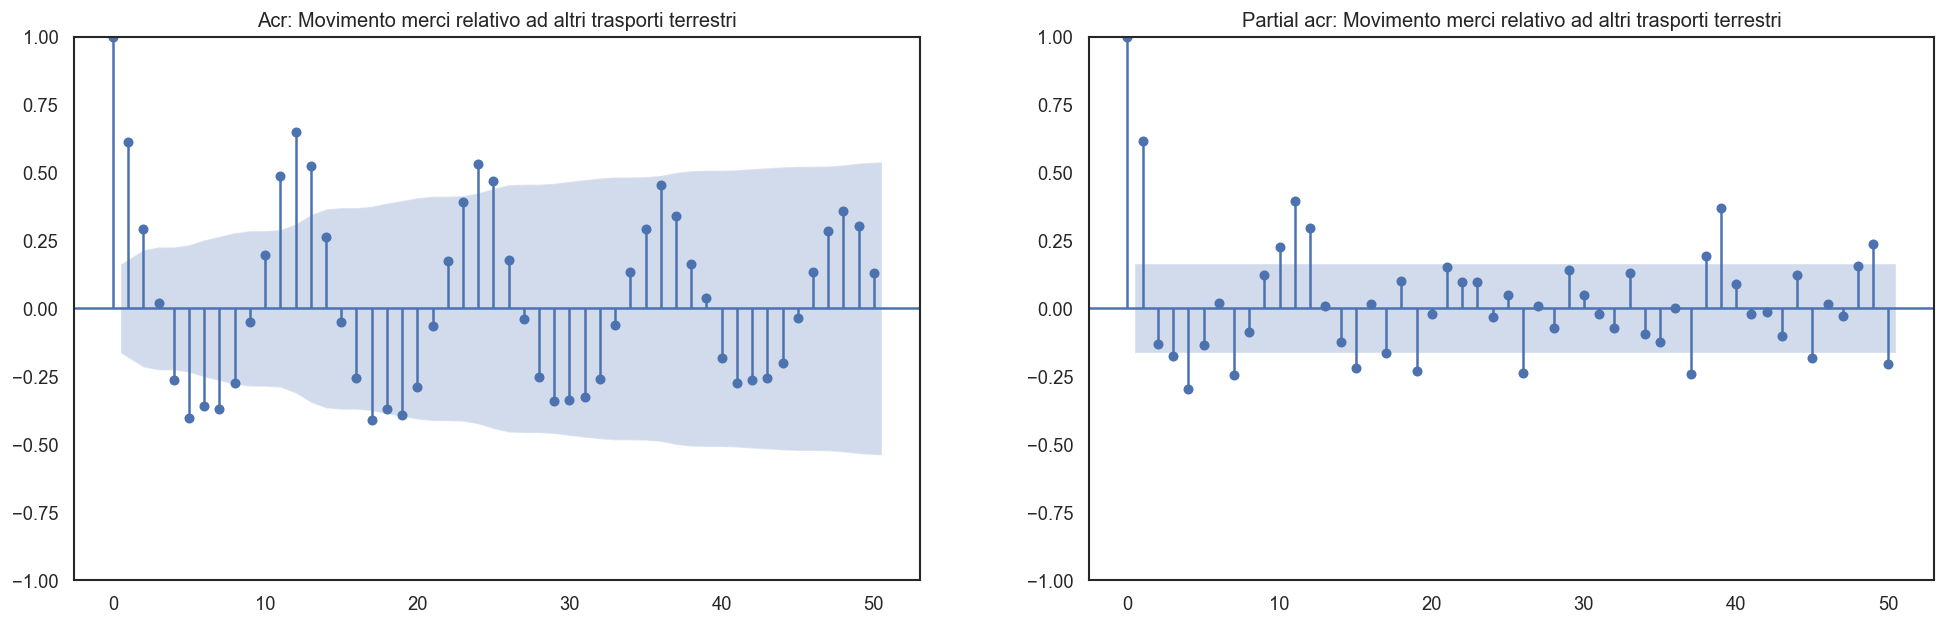

In [123]:
cessFrames = []
for val in perCess.index:
     na = cessHead.loc[(cessHead['SETTORE'] == val)]
     h = na.resample('M').count()
     cessFrames.append(h)
     na2 = h.rename (columns = {'SETTORE' :
     ('CESSAZIONI: '+ val)}).loc[:, ['CESSAZIONI: '+ val,]]
     na2.plot(color=np.random.rand(3,), legend = val, figsize = (20,10))
     fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
     plot_acf(h.SETTORE.tolist(), lags=50, ax=axes[0],
     title =  'Acr: ' + val)
     plot_pacf(h.SETTORE.tolist(), lags=50, ax=axes[1],
     title = 'Partial acr: '+ val)
     plt.show()

In [124]:
totaliAttivatiTs = dfOrdAtt.copy()

In [125]:
totaliCessatiTs = dfOrdCess.copy()

<AxesSubplot:xlabel='DATA'>

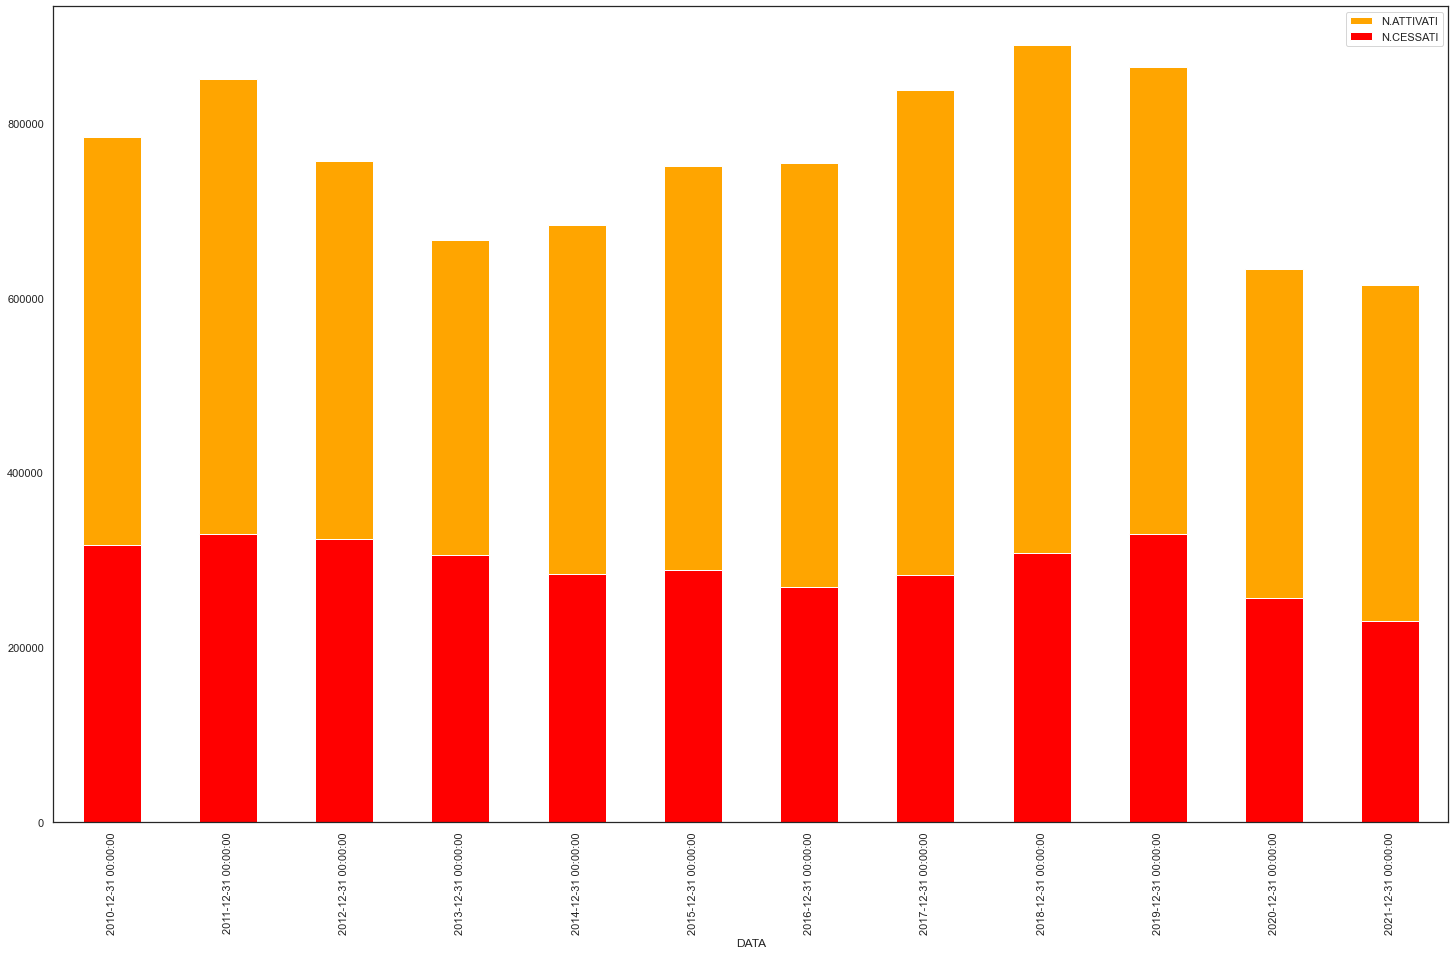

In [126]:
attAnnuali = totaliAttivatiTs.resample('Y').count().iloc[:, [2]]
cessAnnuali = totaliCessatiTs.resample('Y').count().iloc[:, [2]]
attAnnuali.rename(columns={'SETTORE': 'N.ATTIVATI'}, inplace=True)
cessAnnuali.rename(columns={'SETTORE': 'N.CESSATI'}, inplace=True)
ax = attAnnuali.plot(kind="bar", color = "orange")
cessAnnuali.plot( kind="bar", ax=ax, color="red")

In [128]:
attTimeSe = totaliAttivatiTs.resample('M').count().iloc[:, [2]]
cessTimeSe = totaliCessatiTs.resample('M').count().iloc[:, [2]]
attTimeSe.rename(columns={'SETTORE': 'N.ATTIVATI'}, inplace=True)
cessTimeSe.rename(columns={'SETTORE': 'N.CESSATI'}, inplace=True)

--------

6. - APPLICAZIONE DI MODELLI PREDITTIVI (AUTO ARIMA) SULLE TIME SERIES DI CONTRATTI ATTIVATI:  

         Analisi, scomposizione e test della stazionarità della serie di contratti attivati e implementazione del modello AUTO - ARIMA



<AxesSubplot:xlabel='DATA'>

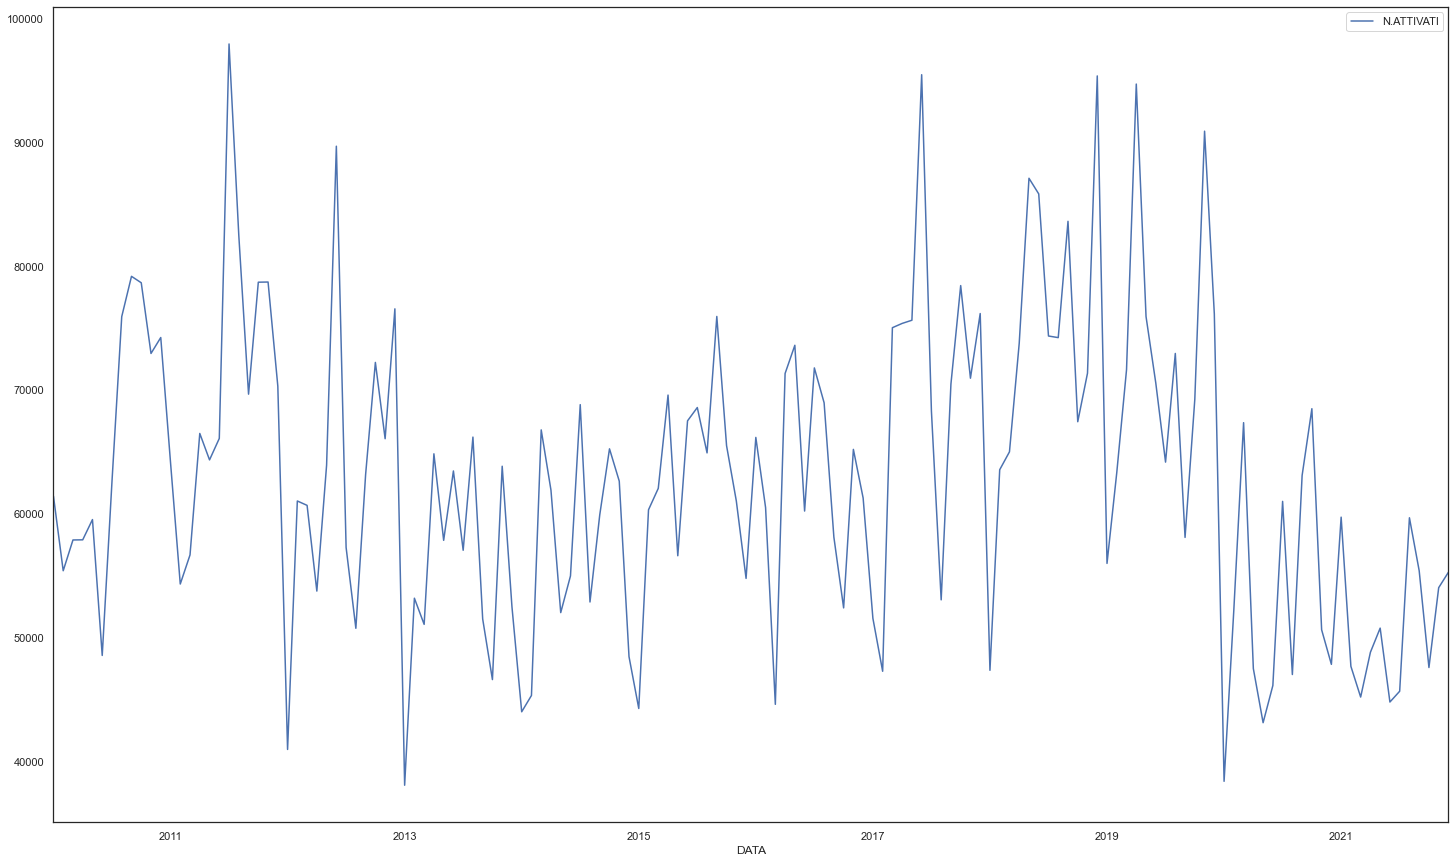

In [129]:
attTimeSe.plot()

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


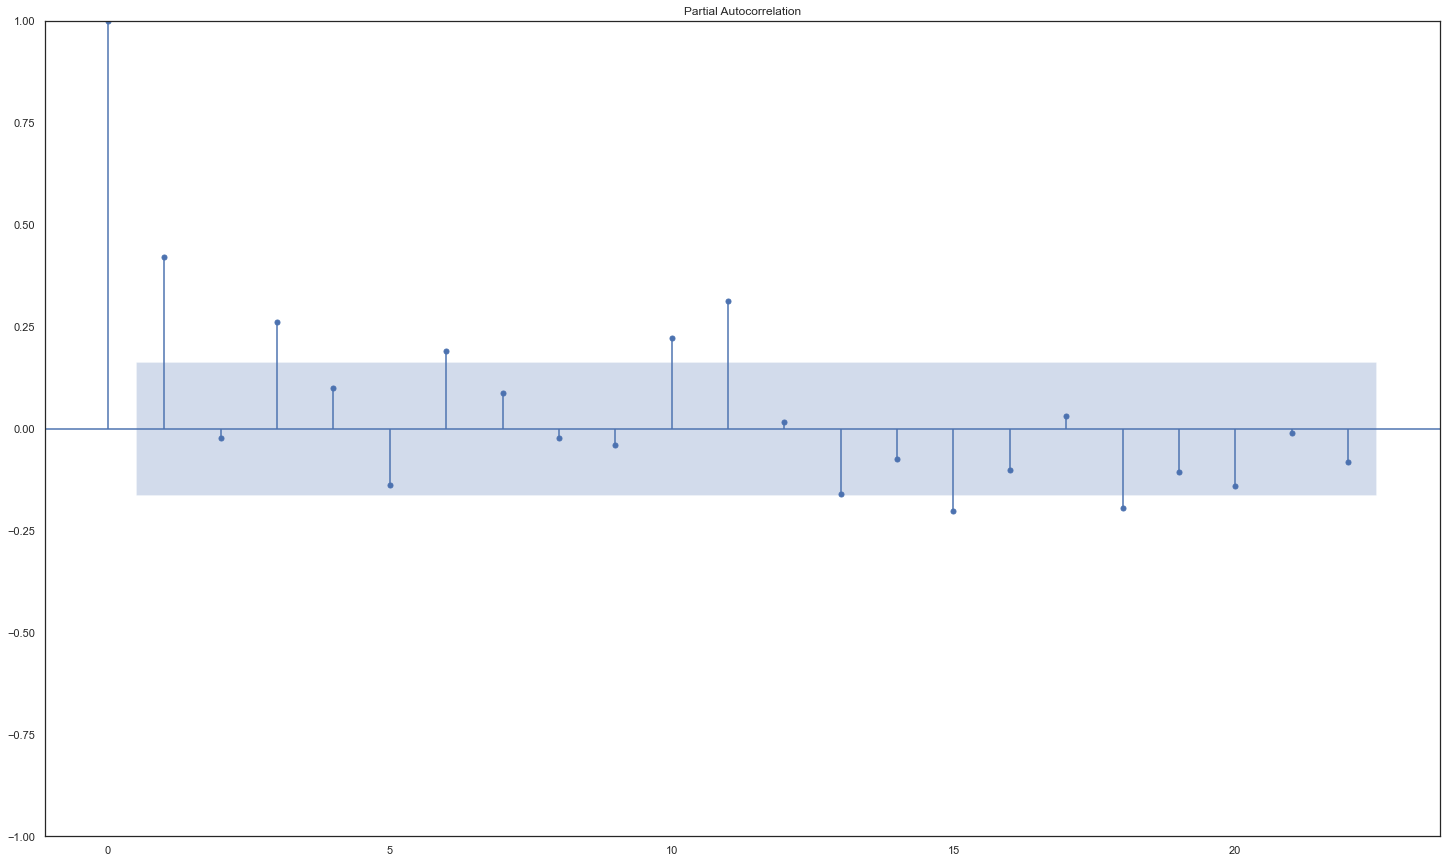

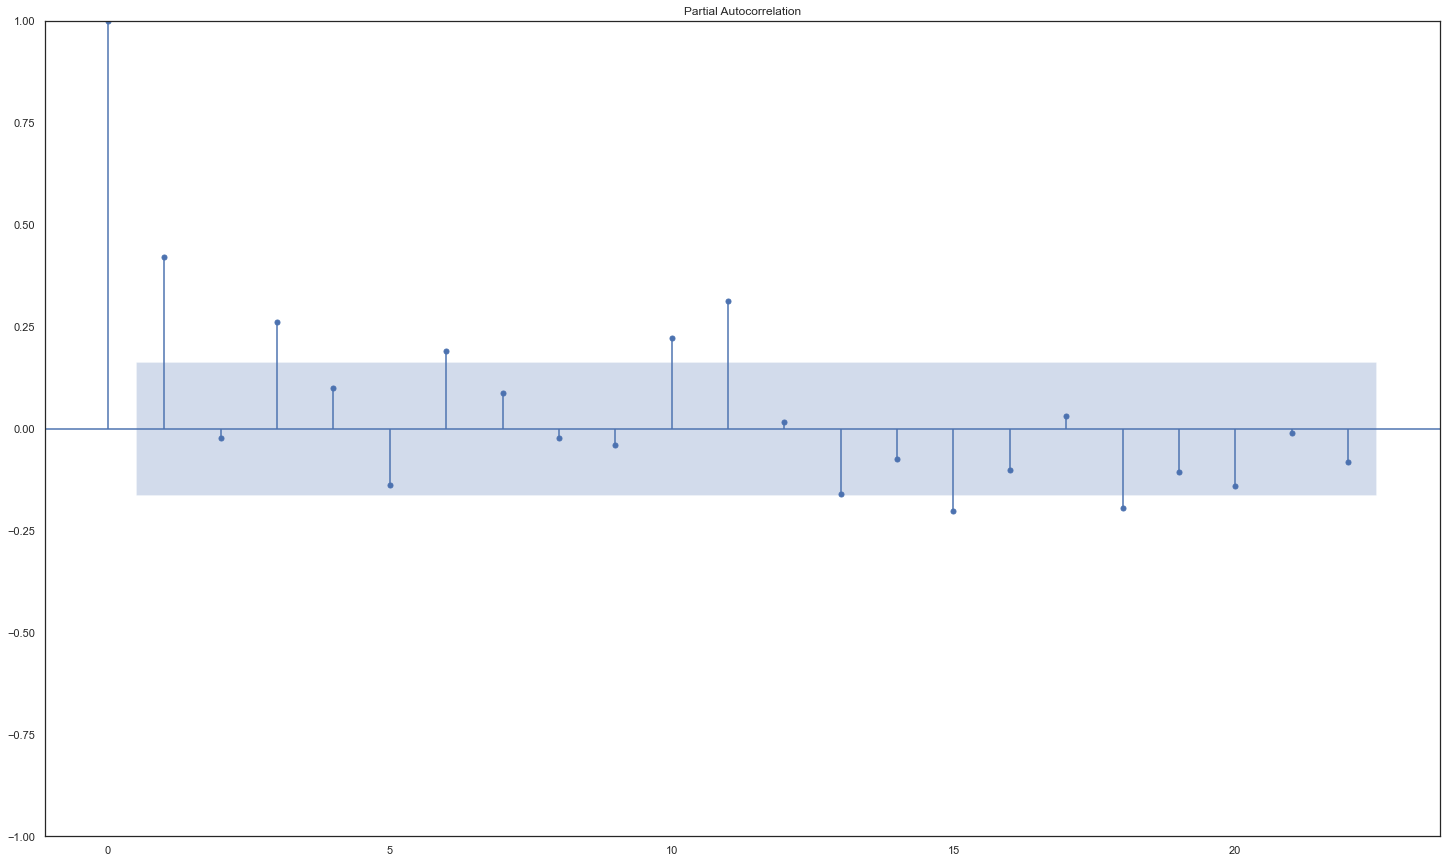

In [130]:
plot_pacf(attTimeSe)

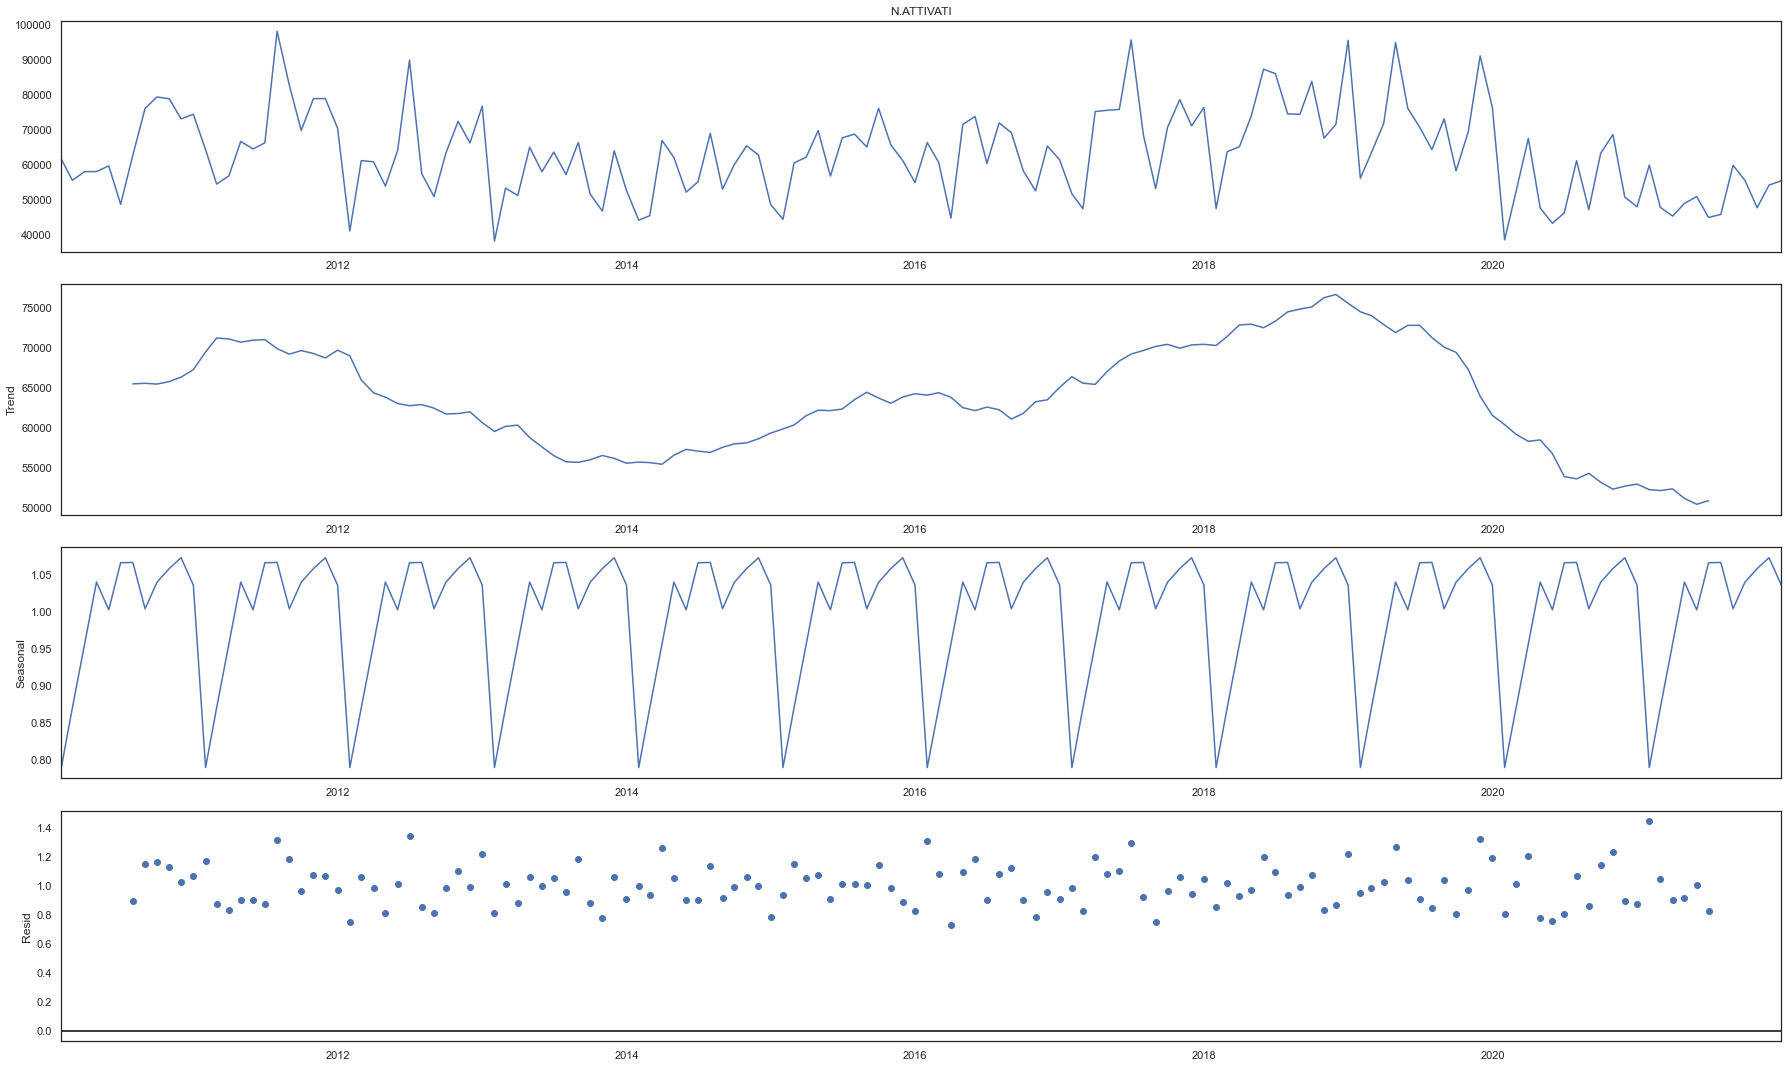

In [132]:
cgs =attTimeSe
analysis = cgs['N.ATTIVATI'].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

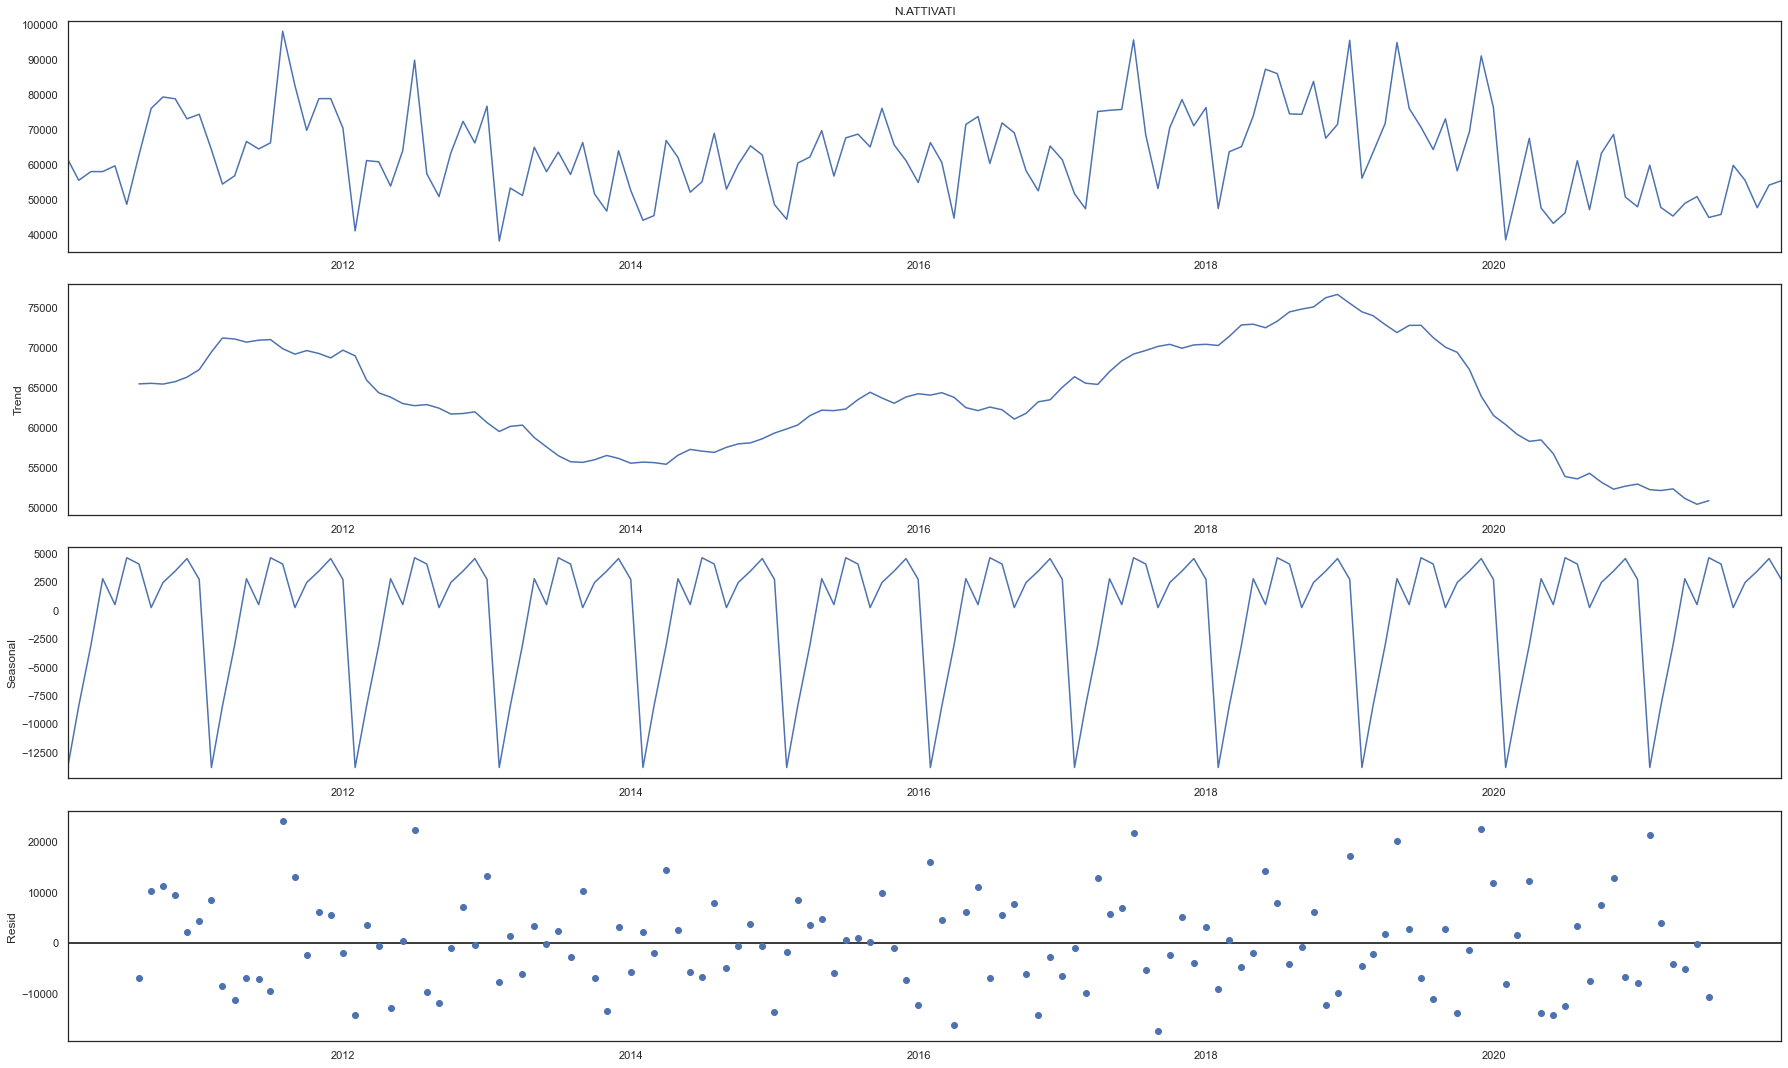

In [133]:

# Additive decomposition
decadd = seasonal_decompose(analysis, model="additive")
add = decadd.plot()
plt.show()

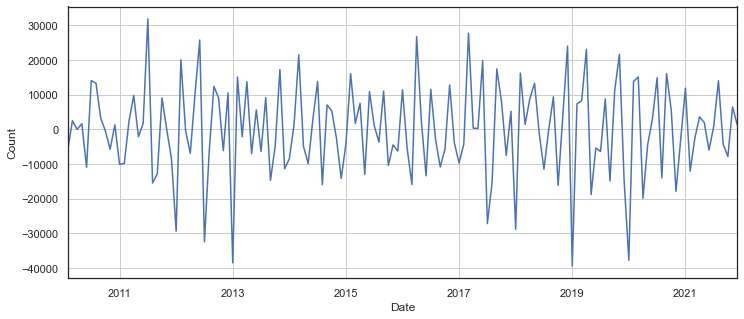

In [134]:
toStation = analysis.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = toStation.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
plt.grid(True)
plt.show()

6. - APPLICAZIONE DI MODELLI PREDITTIVI (AUTO ARIMA) SULLE TIME SERIES DI CONTRATTI ATTIVATI:  

         Adfuller test è utilizzato per verificare la stazionarità di una serie storica. Una serie è stazionaria quando la media dei valori rappresentati dalla funzione non dipende dal tempo, similmente la varianza della stessa non ha dipendenze con le osservazioni temporali. Pertanto se il p value calcolato dal test risulta maggiore a 0,05 prima e dopo il test di differenziazione possiamo affermare che la serie non presenta una componente stazionaria, ma ha delle dipendenze con il tempo. Questo implica automaticamente che esiste seppure talvolta non esplicita una stagionalità sulla serie.


In [135]:
test_result=adfuller(attTimeSe['N.ATTIVATI'])
def adfuller_test(vls):
    result=adfuller(vls)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if test_result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho),result < 0.05, reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis, result > 0,05, indicating it is non-stationary ")

adfuller_test(attTimeSe['N.ATTIVATI'])

weak evidence against null hypothesis, result > 0,05, indicating it is non-stationary 
ADF Test Statistic : -0.8645322360982132
p-value : 0.7994280243739811
#Lags Used : 10
Number of Observations : 133


In [136]:
attTimeSe['Difference'] = attTimeSe['N.ATTIVATI'] - attTimeSe['N.ATTIVATI'].shift(1)
attTimeSe['Seasonal First Difference']=attTimeSe['N.ATTIVATI']-attTimeSe['N.ATTIVATI'].shift(12)
attTimeSe.head()

N.ATTIVATI  Difference  Seasonal First Difference
DATA                                                         
2010-01-31       61434         NaN                        NaN
2010-02-28       55401     -6033.0                        NaN
2010-03-31       57889      2488.0                        NaN
2010-04-30       57900        11.0                        NaN
2010-05-31       59538      1638.0                        NaN

In [137]:
# Again testing if data is stationary
adfuller_test(attTimeSe['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.719896118345244
p-value : 0.07065819658515171
#Lags Used : 11
Number of Observations : 120


In [139]:
tfram2 = attTimeSe['N.ATTIVATI']

In [140]:
tfram2

DATA
2010-01-31    61434
2010-02-28    55401
2010-03-31    57889
2010-04-30    57900
2010-05-31    59538
              ...  
2021-08-31    59683
2021-09-30    55403
2021-10-31    47578
2021-11-30    54033
2021-12-31    55282
Freq: M, Name: N.ATTIVATI, Length: 144, dtype: int64

In [141]:

stepwise_model = auto_arima(tfram2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True, #non stationary ts requires seasonality capturing mechanism
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2876.339, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2963.621, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2925.239, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2876.769, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2919.553, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2878.262, Time=0.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2878.235, Time=1.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2897.925, Time=0.53 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=3.32 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2901.961, Time=0.17 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2859.754, Time=0.33 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=2906.863, Time=0.13 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=2860.501, Time=0.44 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=2860.152, Time=0.85 sec
 ARIMA(2,1,1)(1,1,0)[12]

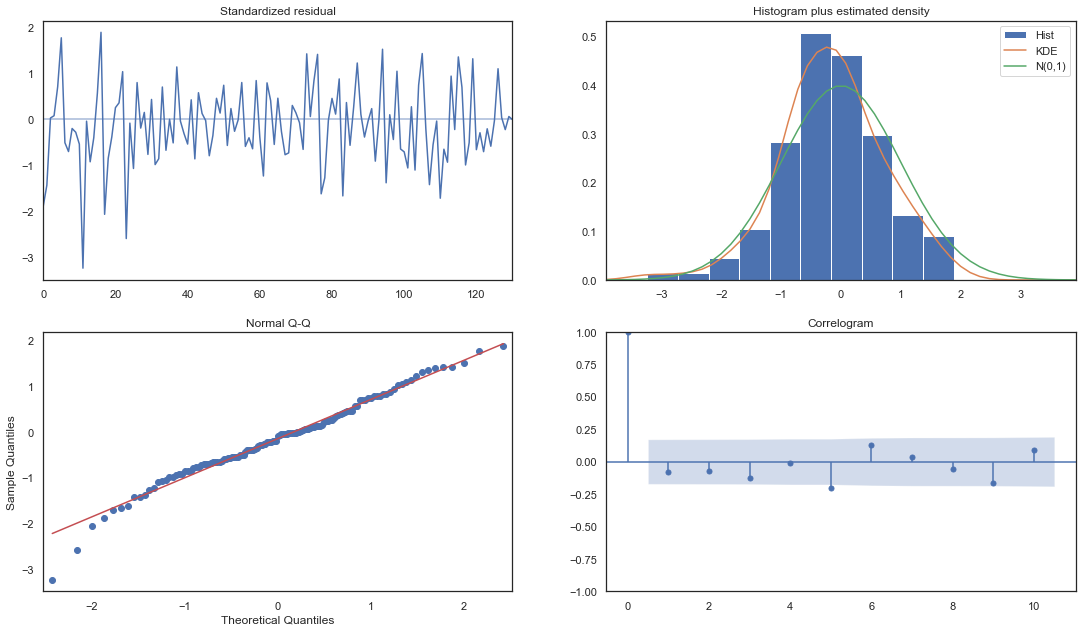

In [142]:
fig = stepwise_model.plot_diagnostics()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

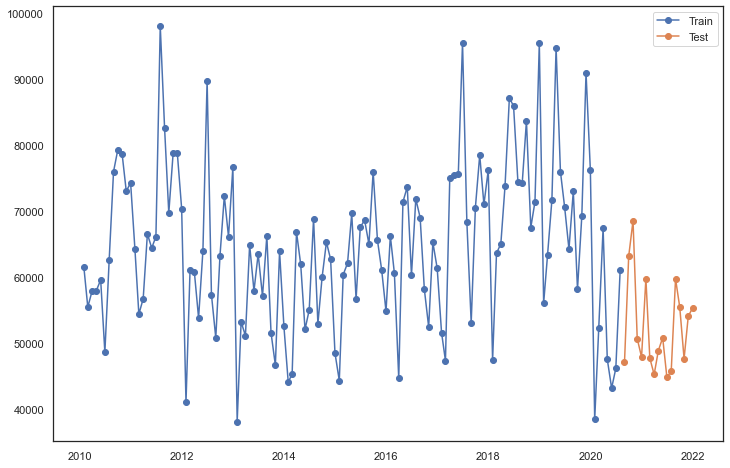

In [143]:
# Train Test Split Index
train_size = 0.88
split_idx = round(len(tfram2)* train_size)
split_idx

# Split
train = tfram2.iloc[:split_idx]
test = tfram2.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [144]:
stepwise_model.fit(train)

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [145]:
future_forecast, cf = stepwise_model.predict(n_periods=17, return_conf_int=True)

In [146]:
future_forecast = pd.DataFrame(future_forecast,index = test.index, columns=['Prediction'])

<AxesSubplot:xlabel='DATA'>

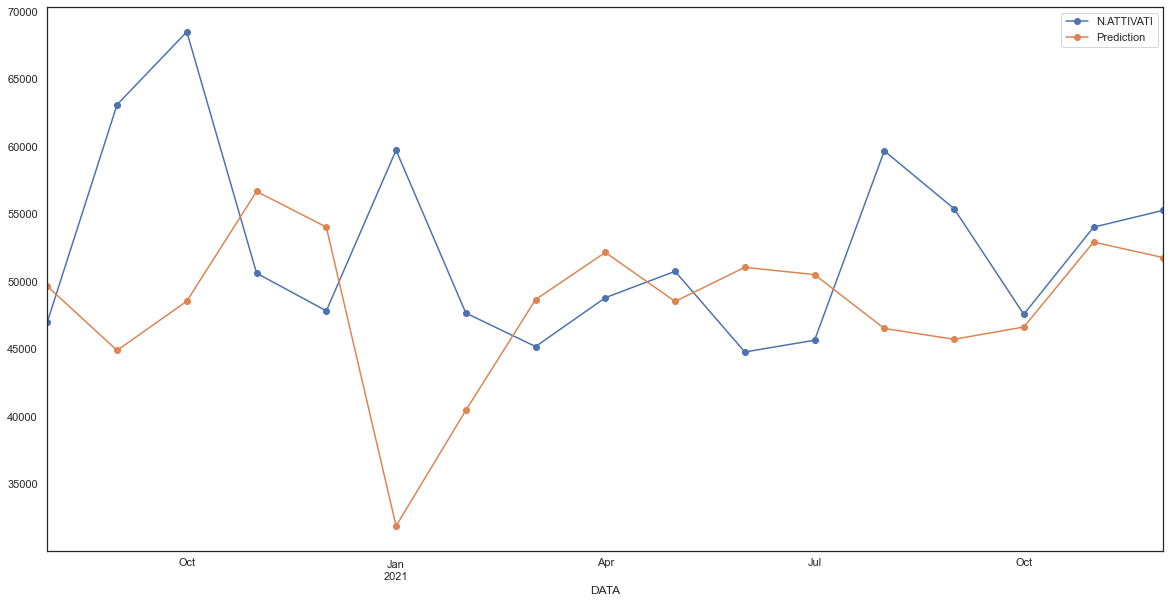

In [147]:
kwsnep = dict(marker='o')
cc = pd.concat([test,future_forecast],axis=1)
cc.plot(**kwsnep, figsize=(20, 10))

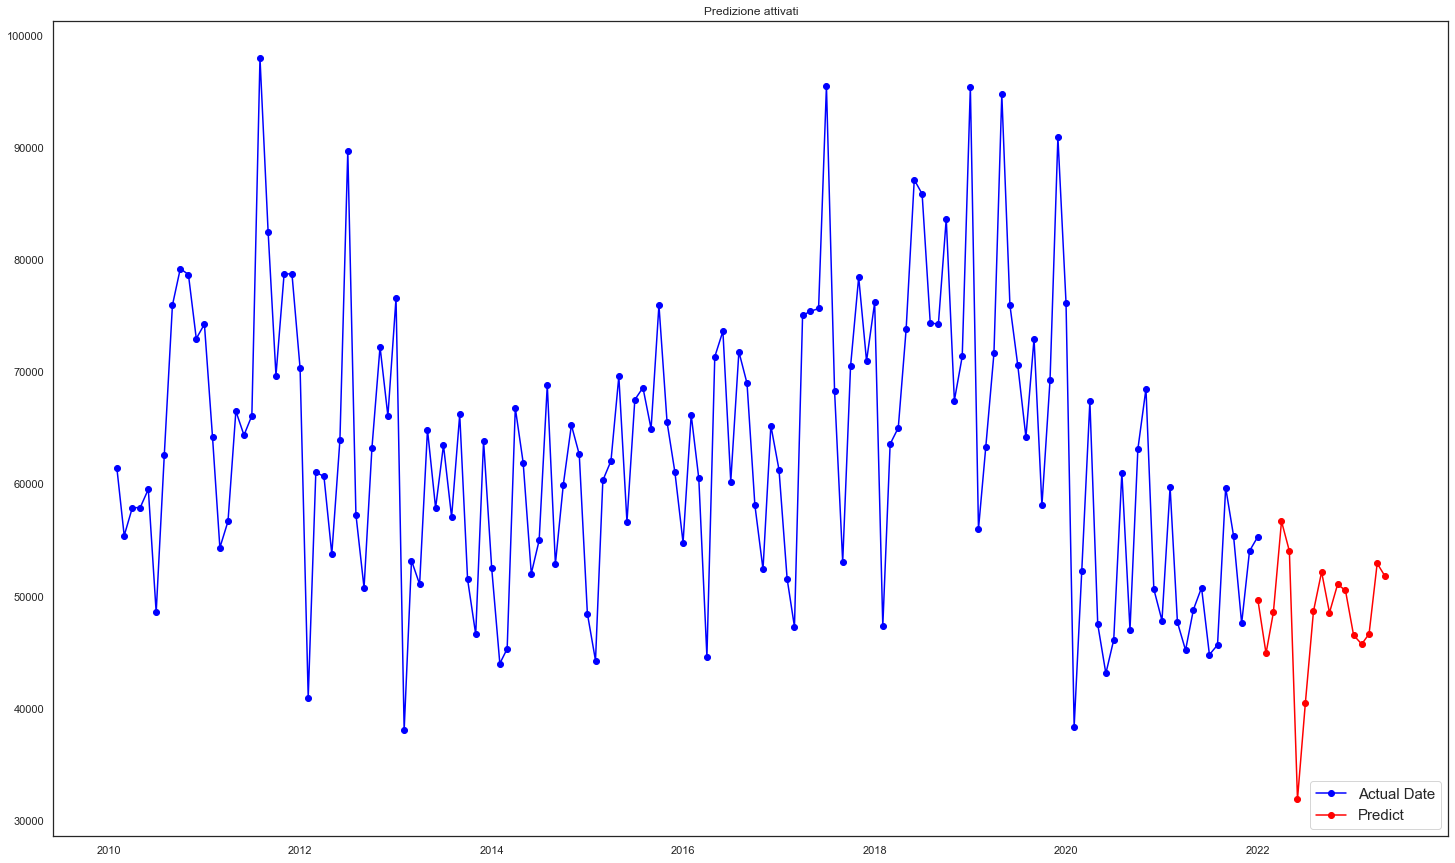

In [148]:
index_of_fc = pd.date_range(tfram2.index[-1], periods = 17, freq='MS')

future_forecast_3 = future_forecast
future_forecast_3 = future_forecast_3.set_index(index_of_fc)

# Plot Della prediction 
plt.figure(figsize=(25, 15))
kwsn = dict(marker='o')
plt.plot(tfram2, color='blue', label='Actual Date', **kwsn)
plt.plot(future_forecast_3, color='red', label='Predict', **kwsn)
plt.legend(loc='lower right', fontsize=15)
plt.title("Predizione attivati")
plt.show()


6. - APPLICAZIONE DI MODELLI PREDITTIVI (AUTO ARIMA) SULLE TIME SERIES DI CONTRATTI ATTIVATI:  

         Considerazioni: Il test rivela che non è presente stazionarità, ovvero che la media e la varianza della funzione temporale sono dipendenti dal tempo. Abbiamo applicato il modello di predizione AUTO-ARIMA con stagionalità (ovvero AUTO - SARIMA).
         La stagionalità a giudicare dal grafico di autocorrelazione non è eccessivamente marcata. Una implementazione alternativa che potrebbe garantire risultati migliori potrebbe essere quella di convertire la funzione in logaritmica ed effettuare una differenziazione per ridurre la componente stagionale e applicare il classico modello ARIMA.


In [263]:
mape = mean_absolute_percentage_error(test, future_forecast_3.Prediction)
print(mape)

0.1433354671416055


In [268]:
MSE = mean_squared_error(test, future_forecast_3)
RMSE = math.sqrt(MSE)
print('The mean square error is: ', MSE)
print('The Root Mean Square error is: ', RMSE)

The mean square error is:  118219597.59521176
The Root Mean Square error is:  10872.883591541471


6. - APPLICAZIONE DI MODELLI PREDITTIVI (AUTO ARIMA) SULLE TIME SERIES DI CONTRATTI CESSATI:  

         Analisi, scomposizione e test della stazionarità della serie di contratti cessati e implementazione del modello AUTO - ARIMA



<AxesSubplot:xlabel='DATA'>

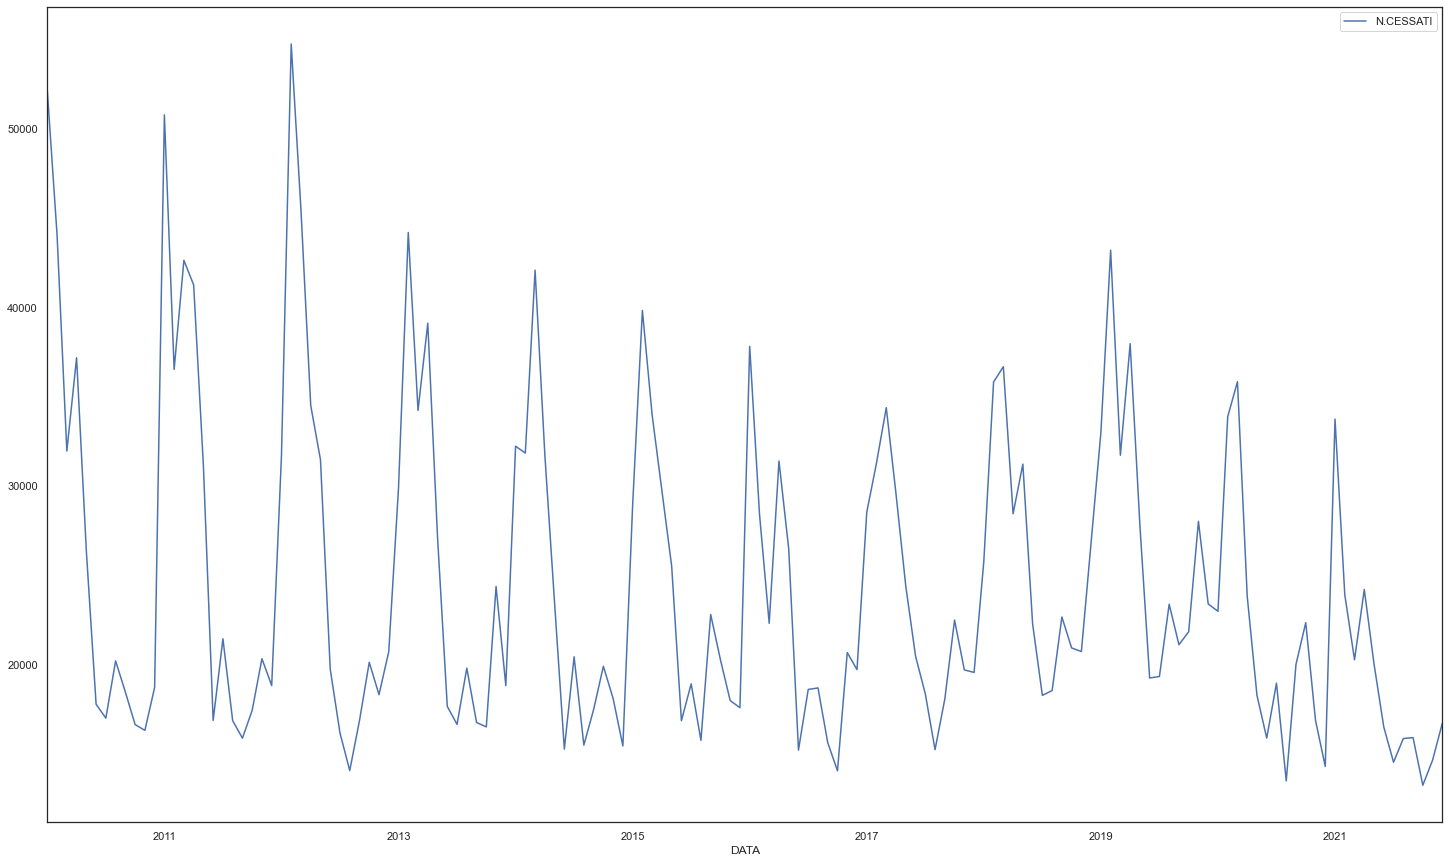

In [149]:
cessTimeSe.plot()

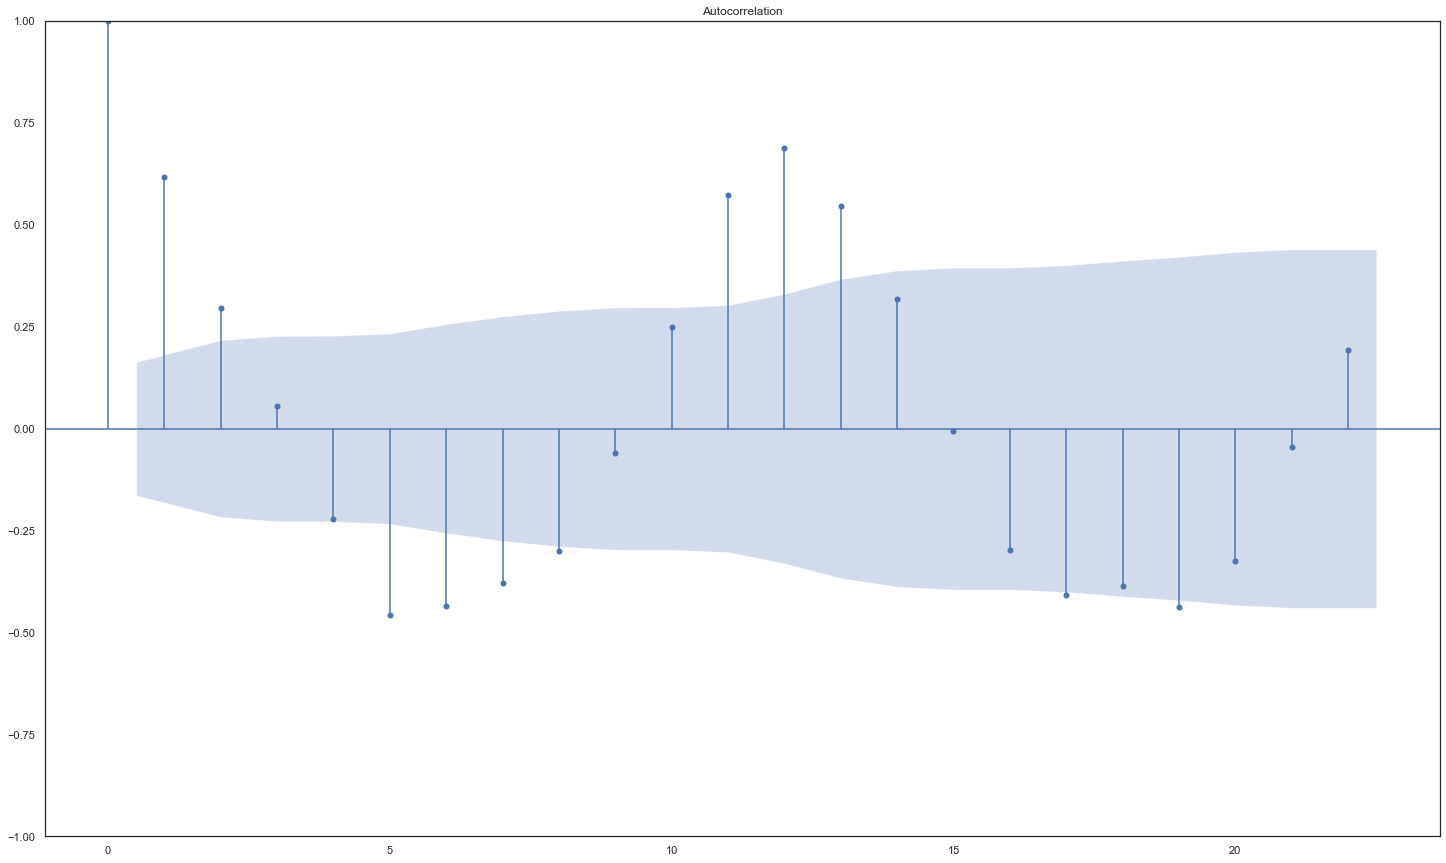

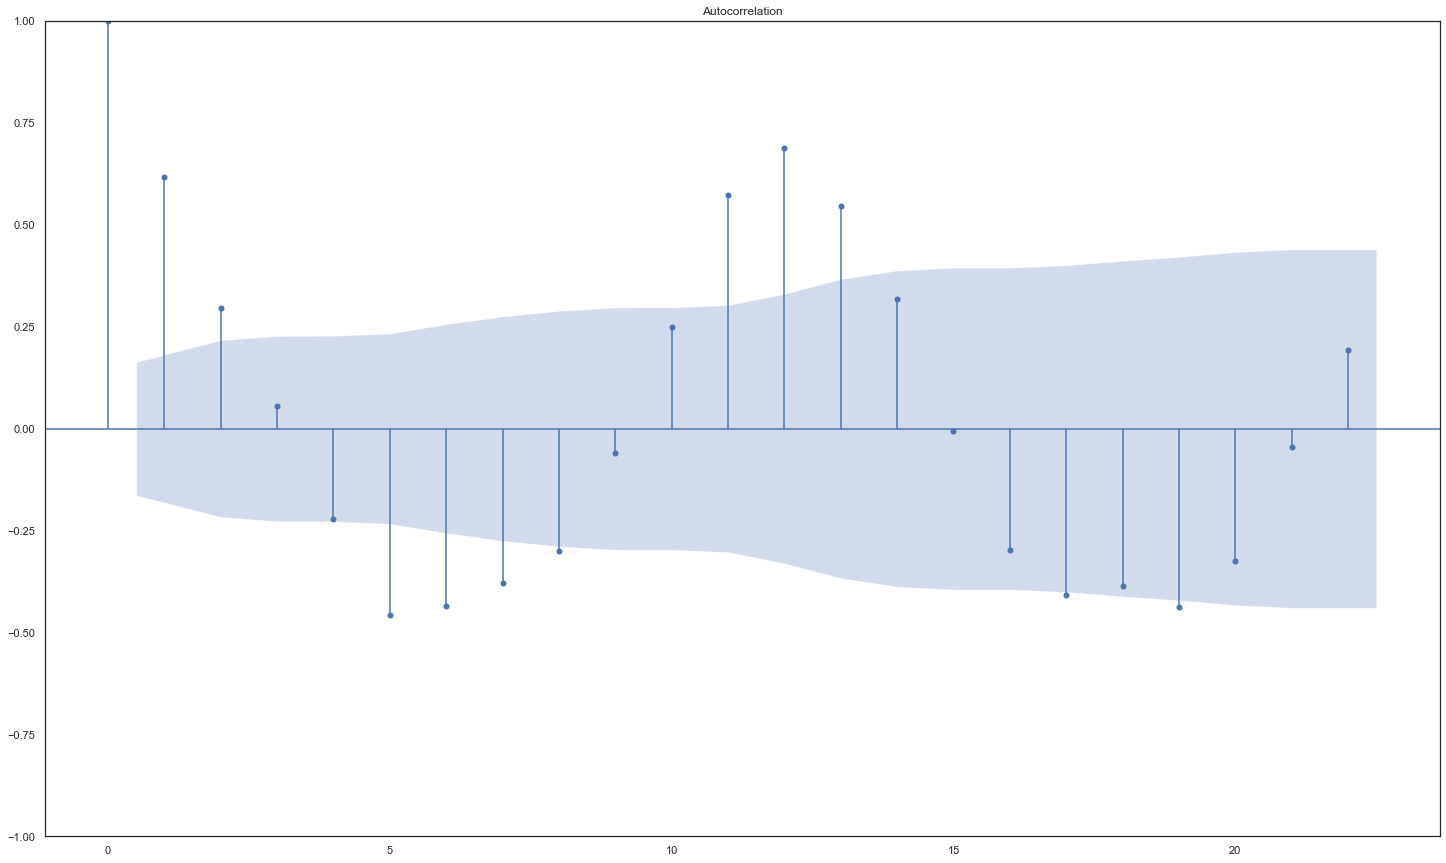

In [150]:
plot_acf(cessTimeSe)

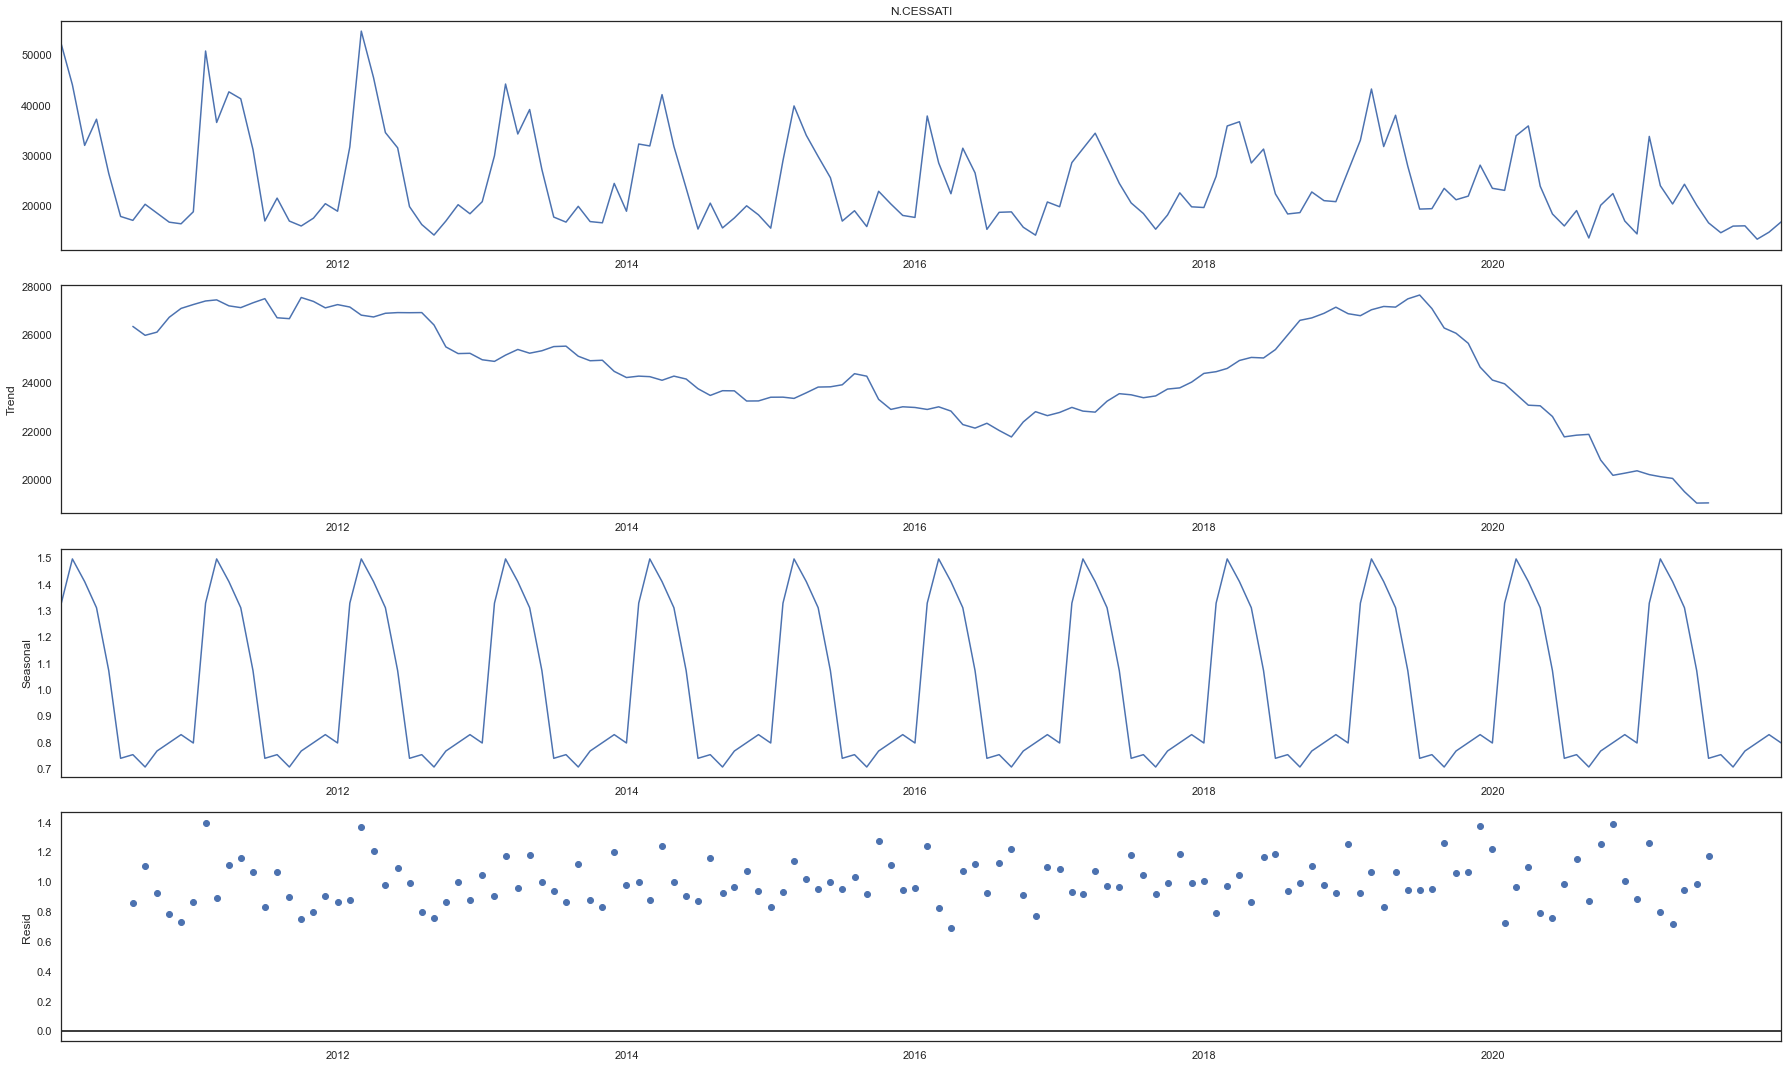

In [151]:

analysis = cessTimeSe['N.CESSATI'].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

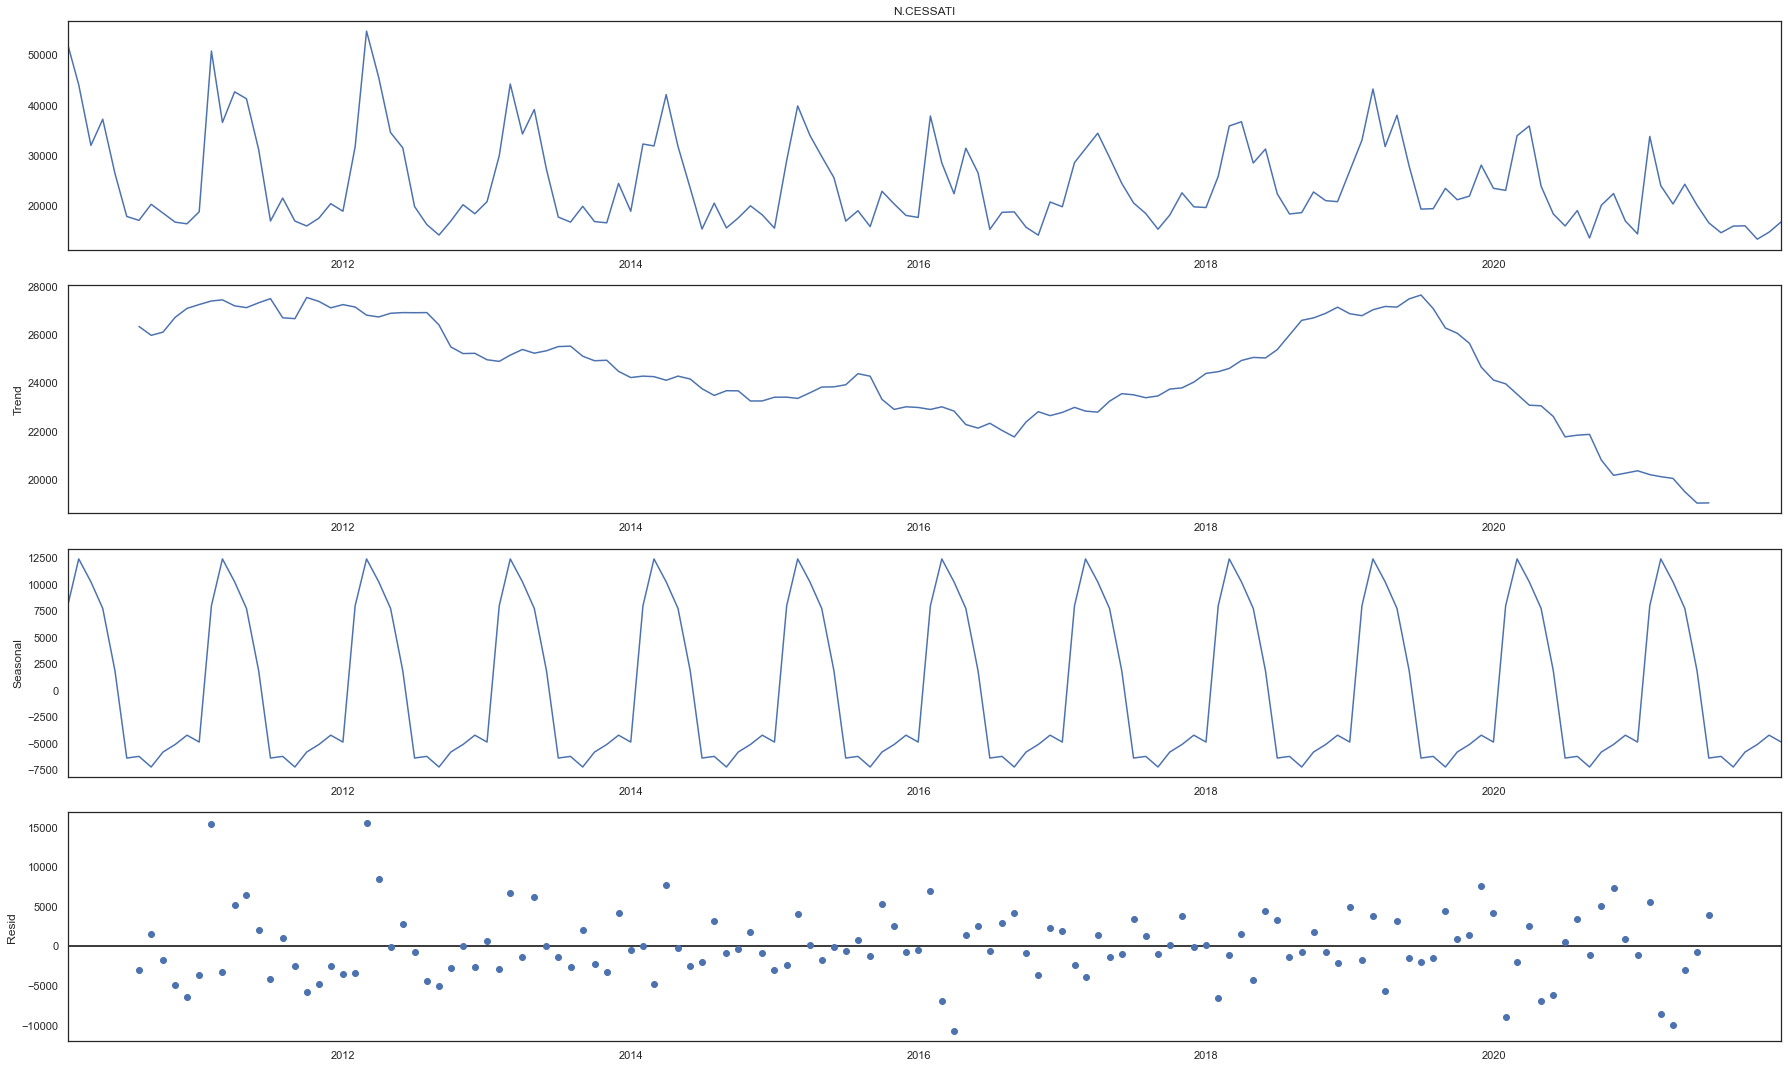

In [152]:

# Additive decomposition
decadd = seasonal_decompose(analysis, model="additive")
add = decadd.plot()
plt.show()

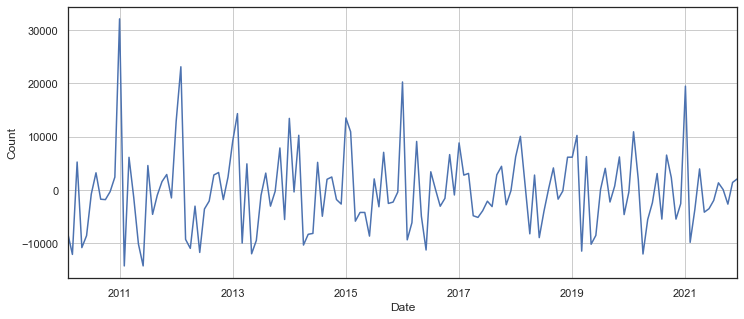

In [153]:
toStation = analysis.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = toStation.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
plt.grid(True)
plt.show()

6. - APPLICAZIONE DI MODELLI PREDITTIVI (AUTO ARIMA) SULLE TIME SERIES DI CONTRATTI CESSATI:  

         Adfuller test è utilizzato per verificare la stazionarità di una serie storica. Una serie è stazionaria quando la media dei valor rappresentati dalla funzione non dipende dal tempo, similmente la varianza della stessa non ha dipendenze con le osservazioni temporali. Pertanto se il p value calcolato dall test risulta maggiore a 0,05 prima e dopo il test di differenziazione possiamo affermare che la serie non presenta una componente stazionaria, ma ha delle dipendenze con il tempo. Questo implica automaticamente che esiste seppure talvolta non esplicita una stagionalità sulla serie.

In [154]:
test_result=adfuller(cessTimeSe['N.CESSATI'])
adfuller_test(cessTimeSe['N.CESSATI'])


ADF Test Statistic : 0.29783007172434917
p-value : 0.9772447120881198
#Lags Used : 11
Number of Observations : 132


In [155]:
cessTimeSe['Difference'] = cessTimeSe['N.CESSATI'] - cessTimeSe['N.CESSATI'].shift(1)
cessTimeSe['Seasonal First Difference']=cessTimeSe['N.CESSATI']-cessTimeSe['N.CESSATI'].shift(12)
cessTimeSe.head()

N.CESSATI  Difference  Seasonal First Difference
DATA                                                        
2010-01-31      52120         NaN                        NaN
2010-02-28      44051     -8069.0                        NaN
2010-03-31      31956    -12095.0                        NaN
2010-04-30      37181      5225.0                        NaN
2010-05-31      26362    -10819.0                        NaN

In [156]:
adfuller_test(cessTimeSe['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.1073010143852637
p-value : 0.2415889796826256
#Lags Used : 11
Number of Observations : 120


In [157]:
tfram3 = cessTimeSe['N.CESSATI']

In [158]:

stepwise_model2 = auto_arima(tfram3, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model2.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2640.572, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2752.956, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2699.760, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2637.125, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2677.337, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2641.473, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2641.425, Time=1.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2657.064, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2639.874, Time=1.18 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2652.470, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2678.273, Time=0.16 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2629.745, Time=1.07 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=2668.670, Time=0.33 sec
 ARIMA(1,1,2)(1,1,1)[12]

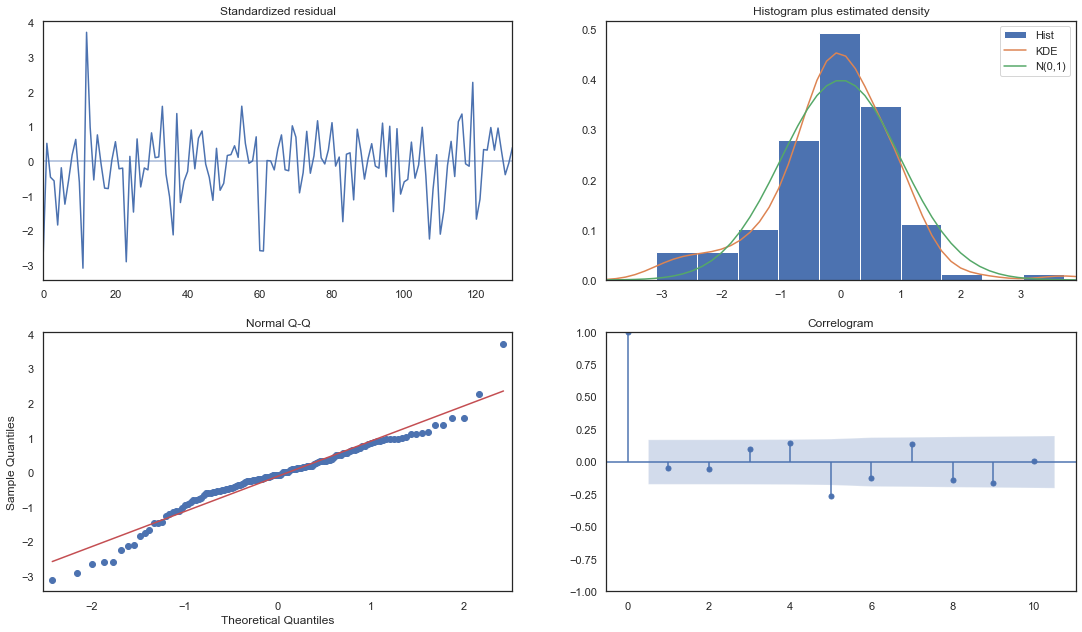

In [159]:
fig = stepwise_model2.plot_diagnostics()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

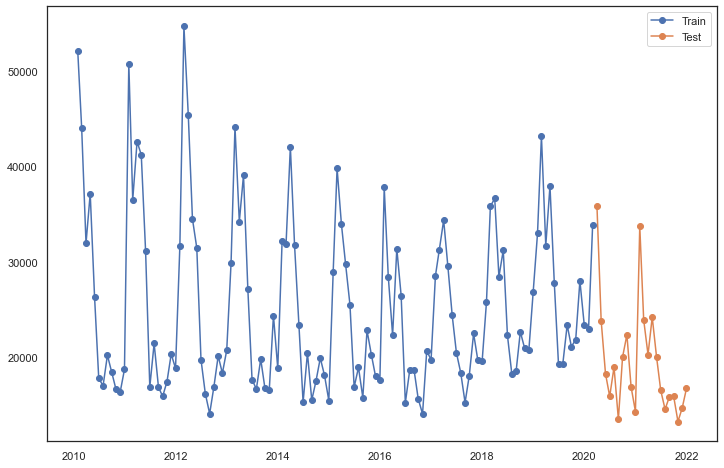

In [160]:
# Train Test Split Index
train_size = 0.85
split_idx = round(len(tfram3)* train_size)
split_idx

# Split
train2 = tfram3.iloc[:split_idx]
test2 = tfram3.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train2, label='Train', **kws)
plt.plot(test2, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [161]:
stepwise_model2.fit(train2)

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [162]:
future, cf2 = stepwise_model2.predict(n_periods=22, return_conf_int=True)

In [163]:
future = pd.DataFrame(future,index = test2.index, columns=['Prediction'])

<AxesSubplot:xlabel='DATA'>

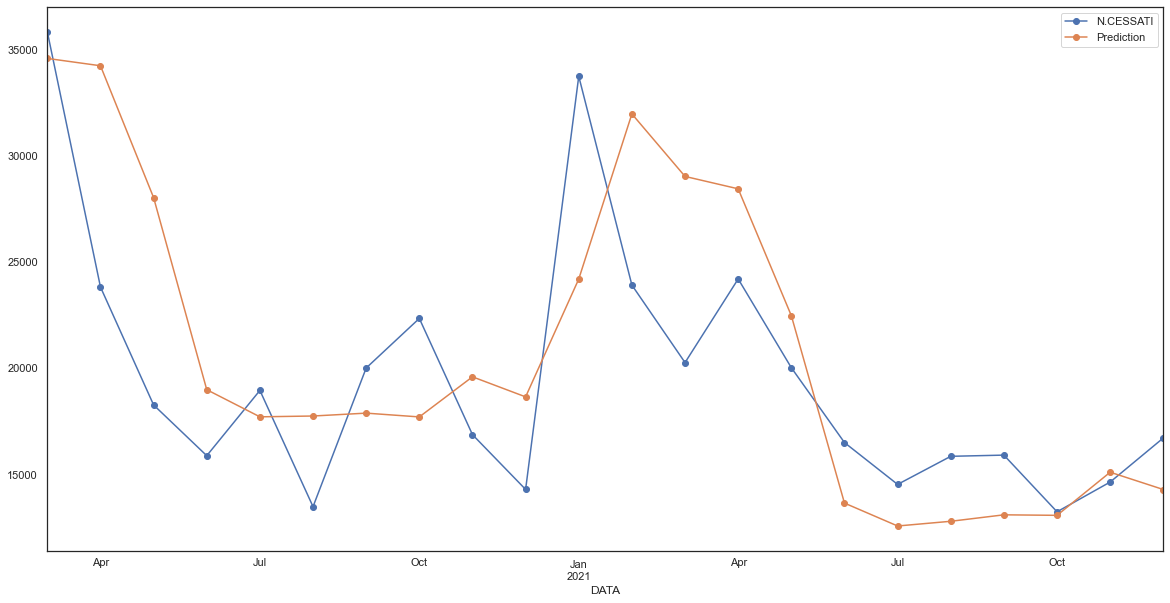

In [164]:
cc = pd.concat([test2,future],axis=1)
cc.plot(**kwsnep, figsize=(20, 10))

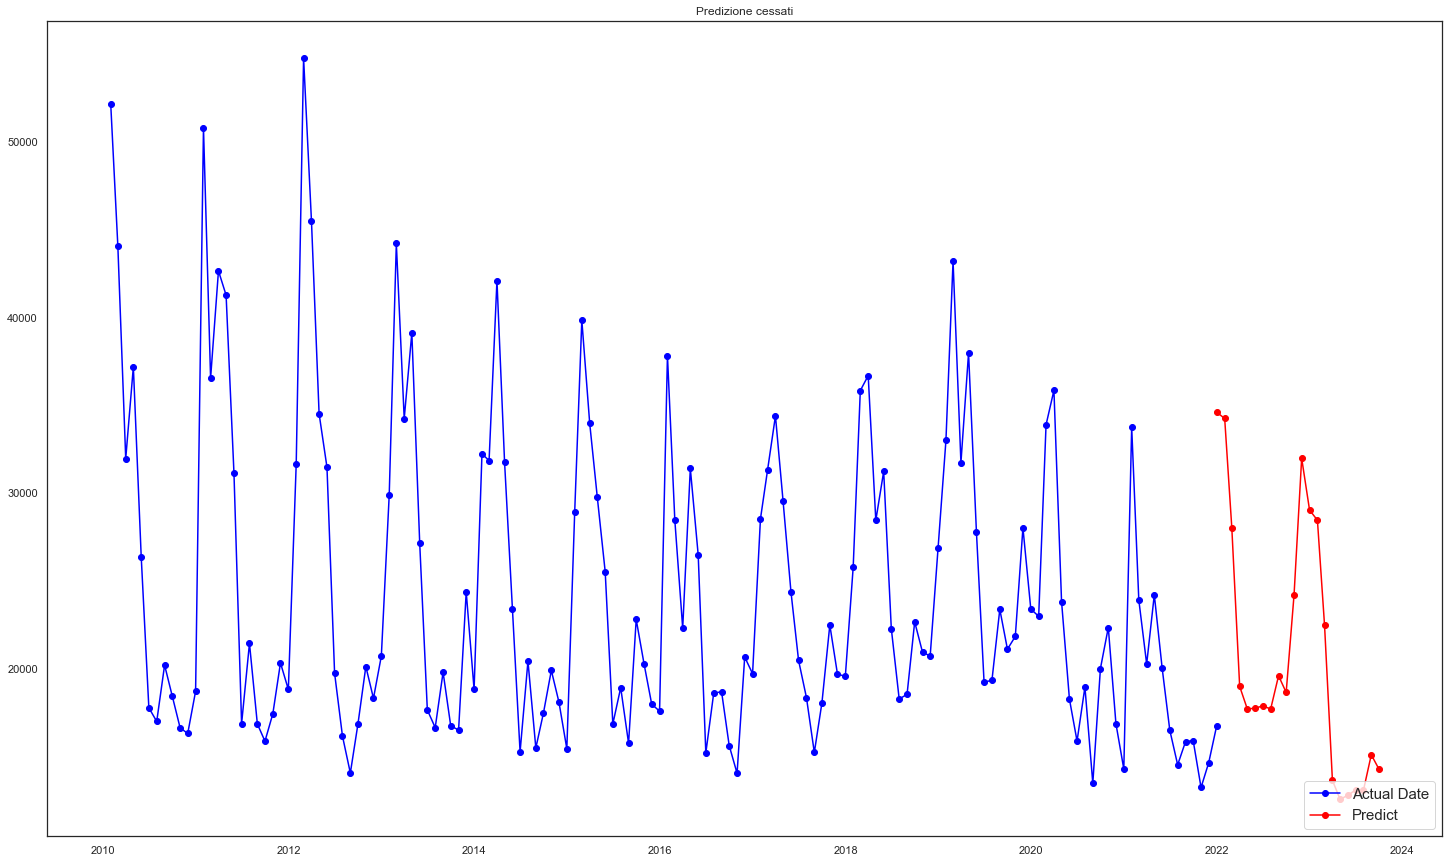

In [165]:
index_of = pd.date_range(tfram3.index[-1], periods = 22, freq='MS')

future_forecast_4 = future
future_forecast_4 = future_forecast_4.set_index(index_of)

# Plot Della prediction 
plt.figure(figsize=(25, 15))
plt.plot(tfram3, color='blue', label='Actual Date', **kwsn)
plt.plot(future_forecast_4, color='red', label='Predict', **kwsn)
plt.legend(loc='lower right', fontsize=15)
plt.title("Predizione cessati")
plt.show()

In [269]:
mape = mean_absolute_percentage_error(test2, future_forecast_4.Prediction)
print(mape)

0.2081571585254859


In [270]:
MSE = mean_squared_error(test2, future_forecast_4)
RMSE = math.sqrt(MSE)
print('The mean square error is: ', MSE)
print('The Root Mean Square error is: ', RMSE)

The mean square error is:  26336112.14437239
The Root Mean Square error is:  5131.872187065105


------

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  

          Il settore della ristorzione ha un turnover considerevole,ed è in seconda posizione per quanto riguarda le attivazioni dei contratti e cessazioni.
          Osservando i due grafici, rispettivamente la predizione delle attivazioni e quella delle cessazioni notiamo che la crisi relativa al COVID ha causato un decremento importante nel pil della lombradia e un calo delle attivazioni di contratti nel generale. Le cessazioni seguono un andamento stagionale, previsto dal modello utilizzato e impostato in modo da tener conto della stagionalità.
          Nonostante la crisi da covid abbia impattato molto sul settore della ristorazione, dimostrato dalla concavità della funizione temporale delle attivazioni dei contratti in ambito ristorazione, abbiamo ancora poche inofrmazioni utili per la previsione dell'andamento del settore. Studiamo dunque l'evoluzione del settore ristorazione con somministrazione per le attivazioni nel dettaglio:



In [166]:
attFrames[1].sum()

CONTRATTO            424929
CONTR_N              424929
SETTORE              424929
SETT_ID              424929
STATO                424929
ETA                  424929
GENERE               424929
DATE                 424929
MESE                 424929
ANNO                 424929
PIL MLN EUR ANNUO    424929
dtype: int64

In [167]:
#raggruppo per giorno le attivazioni del settore ristorazione

In [168]:
ristorazioneDaily = dfOrdAtt.loc[dfOrdAtt['SETTORE'] == 'Ristorazione con somministrazione']

In [169]:
ristorazioneDaily = ristorazioneDaily.resample('D').count().iloc[:, [2]]
ristorazioneDaily.rename(columns={'SETTORE': 'VALUES'}, inplace=True)

<AxesSubplot:xlabel='DATA'>

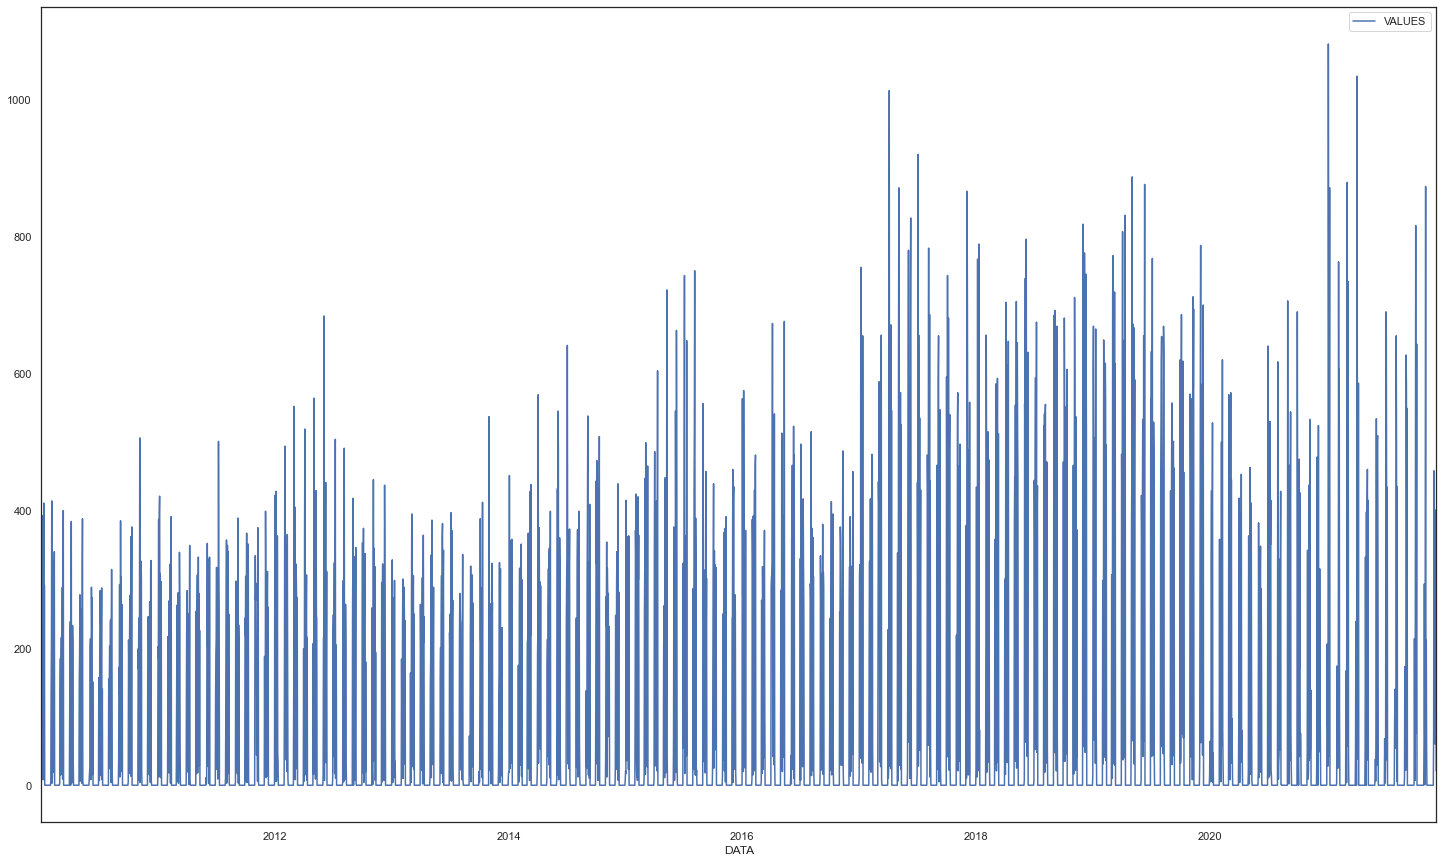

In [170]:
ristorazioneDaily.plot()

In [172]:
resultsDict = {}
predictionsDict = {}

split_date = '2020-08-30'
df_training = ristorazioneDaily.loc[ristorazioneDaily.index <= split_date]
df_test = ristorazioneDaily.loc[ristorazioneDaily.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")


3894 days of training data 
 466 days of testing data 


7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    
         Single esponential smoothing (SES)
         Il metodo Simple Exponential Smoothing (SES) modella il passo temporale successivo come una funzione lineare ponderata esponenzialmente sulle osservazioni dei passi temporali precedenti. Questo metodo prevede che le nostre serie temporali siano stazionarie per poter funzionare in modo adeguato (nessun trend o stagionalità).


In [174]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.VALUES))):
    temp_train = ristorazioneDaily[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.VALUES)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.VALUES, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 466/466 [00:12<00:00, 37.04it/s]


7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    
         Holt Winter’s Exponential Smoothing (HWES)
         Il metodo Simple Exponential Smoothing (SES) è derivato dal single esponential smoothing ma tiene conto della componente stagionale della serie e del trend



In [175]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.VALUES))):
    temp_train = ristorazioneDaily[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.VALUES)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.VALUES, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 466/466 [00:12<00:00, 36.15it/s]


ARIMA

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    



          Autoregressive integrated moving average (ARIMA)
          In un modello ARIMA ci sono 3 parametri che vengono utilizzati per modellare gli aspetti principali di una serie temporale: stagionalità, tendenza e rumore. Questi parametri sono contrassegnati dalle lettere p, d e q.

          Numero di termini AR (autoregressivi) (p): p è il parametro associato all'aspetto autoregressivo del modello, che incorpora i valori passati, ossia i lag della variabile dipendente. Ad esempio, se p è 5, i predittori per x(t) saranno x(t-1)....x(t-5).
          Numero di differenze (d): d è il parametro associato alla parte integrata del modello, che influisce sulla quantità di differenze da applicare a una serie temporale.
          Numero di termini MA (Moving Average) (q): q è la dimensione della finestra della parte media mobile del modello, ovvero degli errori di previsione laggati nell'equazione di previsione. Ad esempio, se q è 5, i predittori per x(t) saranno e(t-1)....e(t-5) dove e(i) è la differenza tra la media mobile all'iesimo istante e il valore effettivo.

          Regolazione dei parametri ARIMA

          Le serie non stazionarie richiedono un livello di differenziazione (d) >0 in ARIMA 

          Nota: un problema dell'ARIMA è che non supporta i dati stagionali. Cioè una serie temporale con un ciclo che si ripete. ARIMA prevede che i dati non siano stagionali o che la componente stagionale sia stata rimossa, ad esempio destagionalizzata con metodi quali la differenziazione stagionale.



In [177]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.VALUES))):
    temp_train = ristorazioneDaily[:len(df_training)+t]
    model = ARIMA(temp_train.VALUES, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.VALUES, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 466/466 [02:24<00:00,  3.23it/s]


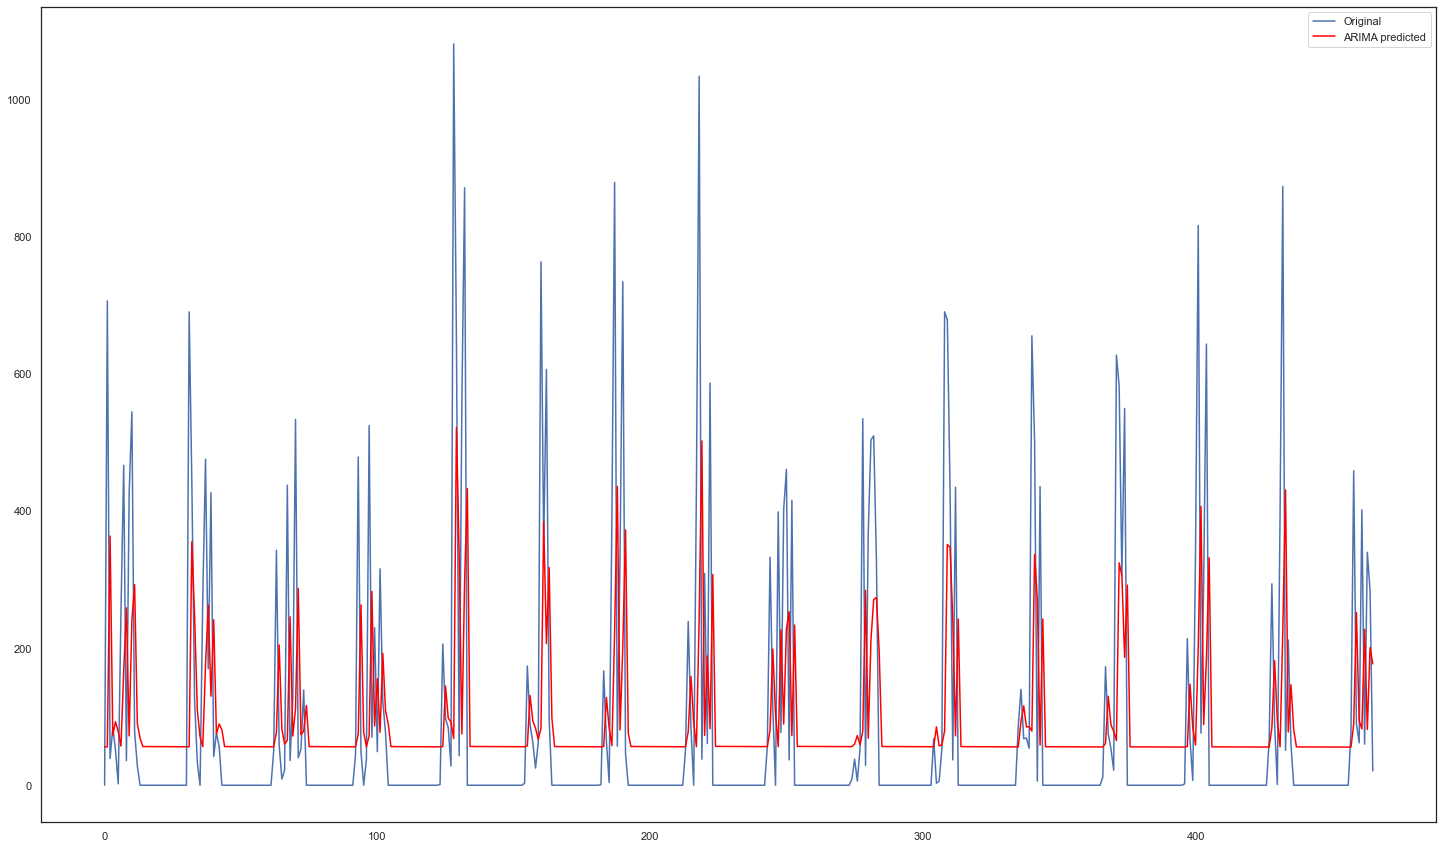

In [178]:
plt.plot(df_test.VALUES.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

AUTO ARIMA

In [179]:
autoModel = pm.auto_arima(df_training.VALUES, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.VALUES)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=50357.270, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51832.790, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51038.821, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50536.689, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51830.790, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50462.312, Time=1.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50416.693, Time=1.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=50357.102, Time=3.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.98 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=50344.113, Time=4.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=50346.996, Time=3.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=50346.064, Time=9.60 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=50346.013, Time=6.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=50353.639, Time=6.93 sec
 ARIMA(5,1,1)(0,0,0)[0] i

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [181]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.VALUES))):
    temp_train = ristorazioneDaily[:len(df_training)+t]
    model = ARIMA(temp_train.VALUES, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.VALUES, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 466/466 [18:47<00:00,  2.42s/it]


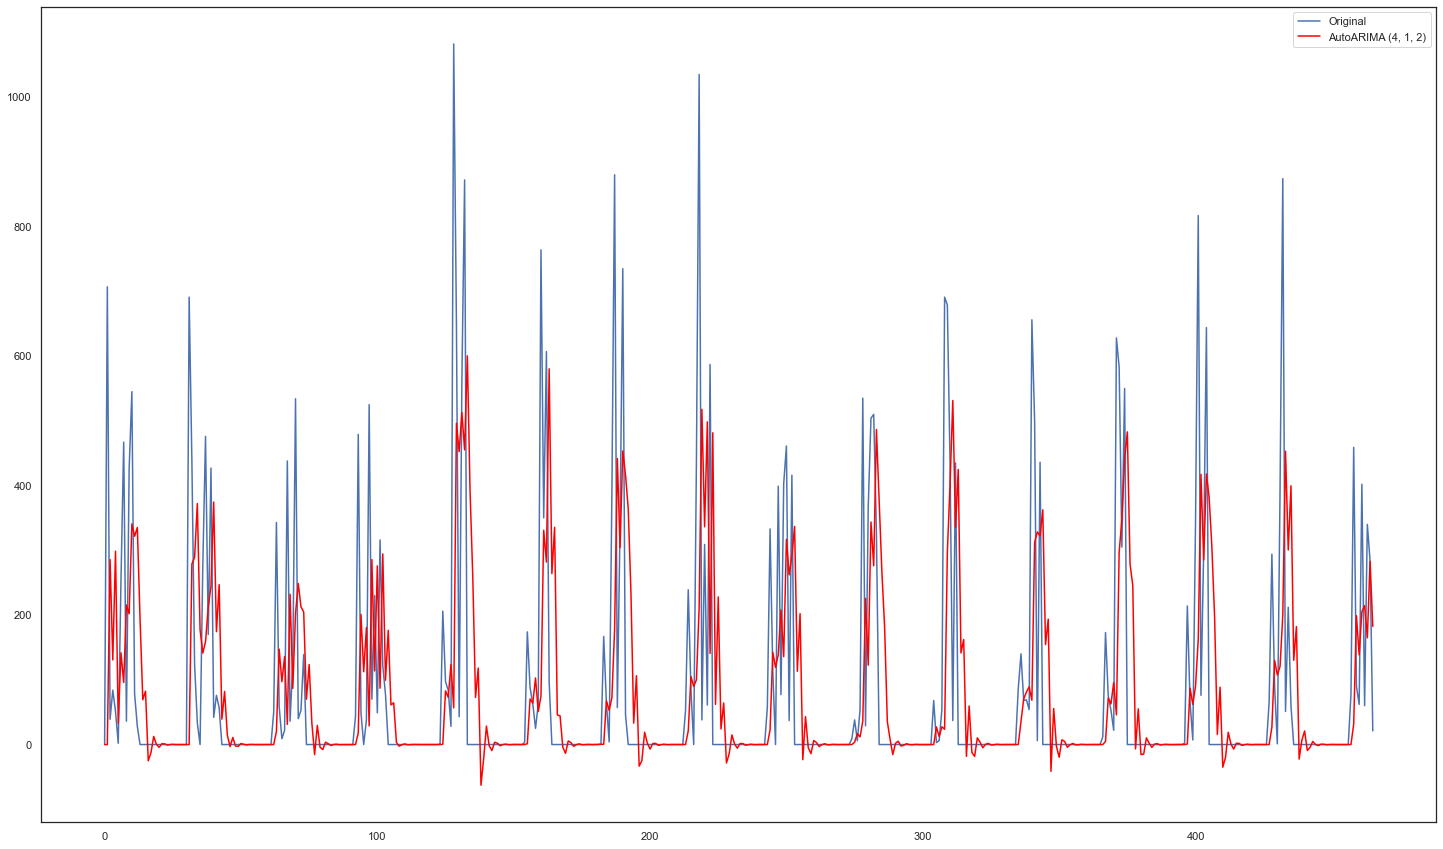

In [182]:
plt.plot(df_test.VALUES.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    
         Seasonal Autoregressive Integrated Moving-Average (SARIMA)
         Seasonal Autoregressive Integrated Moving Average, SARIMA o ARIMA stagionale, è un'estensione di ARIMA che supporta esplicitamente dati di serie temporali univariate con una componente stagionale.

         Aggiunge tre nuovi iperparametri per specificare l'autoregressione (AR), la differenziazione (I) e la media mobile (MA) per la componente stagionale della serie, oltre a un parametro aggiuntivo per il periodo della stagionalità.

         Elementi di tendenza:

         Sono tre gli elementi di trend che richiedono una configurazione. Sono gli stessi del modello ARIMA, in particolare:

         p: Ordine di autoregressione del trend.
         d: Ordine di differenza del trend.
         q: ordine della media mobile del trend.
         Elementi stagionali:

         Sono quattro gli elementi stagionali che non fanno parte dell'ARIMA e che devono essere configurati:

         P: ordine autoregressivo stagionale.
         D: Ordine di differenza stagionale.
         Q: ordine di media mobile stagionale.
         m: Il numero di passi temporali per un singolo periodo stagionale. Ad esempio, una S di 12 per i dati mensili suggerisce un ciclo stagionale annuale.
         Notazione SARIMA: SARIMA(p,d,q)(P,D,Q,m)


In [183]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.VALUES))):
    temp_train = ristorazioneDaily[:len(df_training)+t]
    model = SARIMAX(temp_train.VALUES, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.VALUES, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 466/466 [00:56<00:00,  8.18it/s]


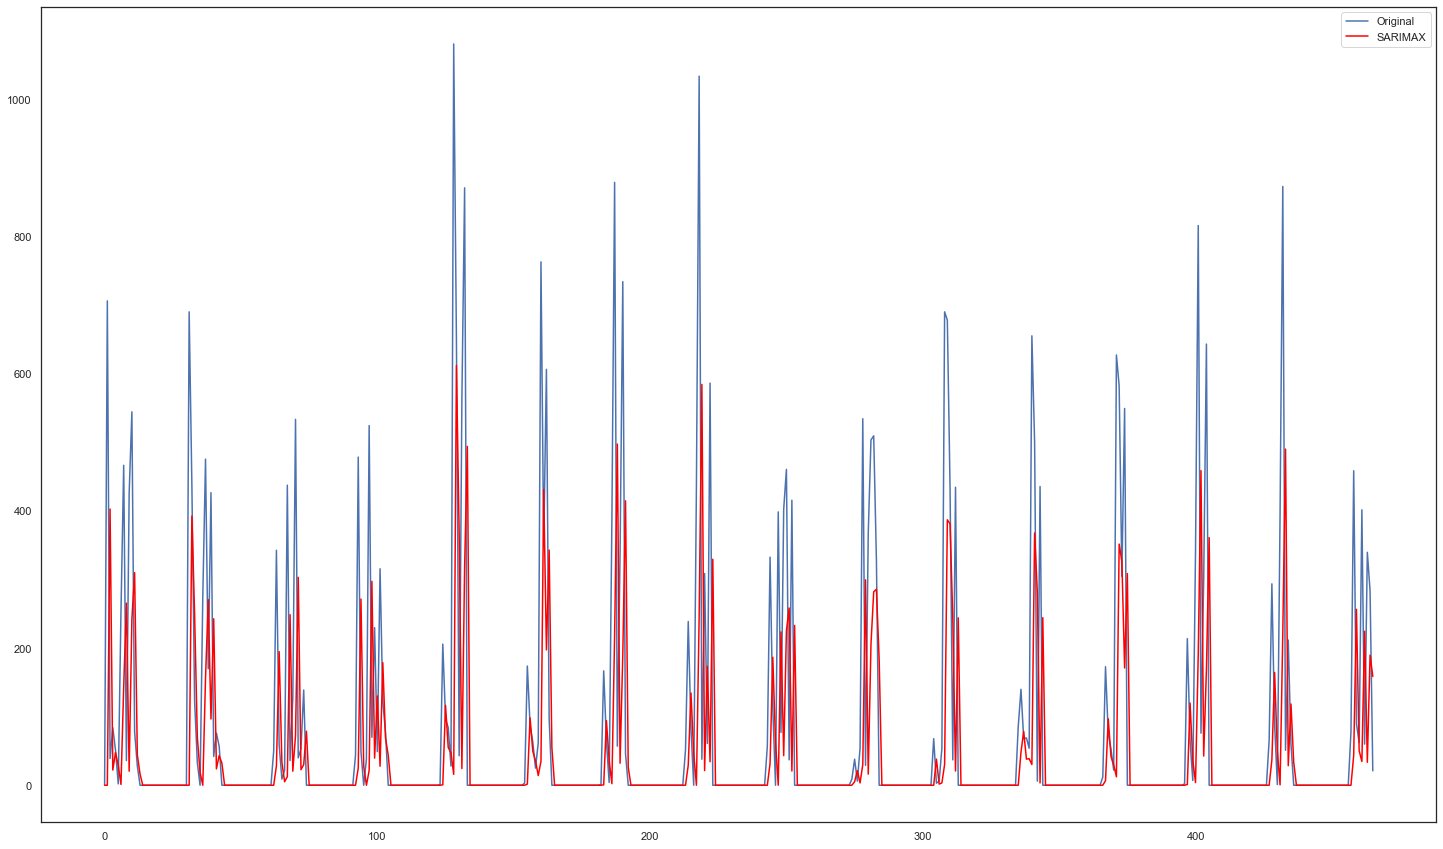

In [184]:
plt.plot(df_test.VALUES.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
      
      
        
             Prophet è un modello rilasciato da Facebook. Si tratta essenzialmente di un approccio di curve fitting,
             ma utilizza modelli additivi generalizzati invece di una rappresentazione dello spazio degli stati per descrivere ogni componente.


In [185]:
# Prophet needs some specifics data stuff
prophet_training = df_training.rename(
    columns={'VALUES': 'y'})  
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'VALUES': 'y'})  
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [186]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    weekly_seasonality=False,
    daily_seasonality= True,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='Italy')

In [187]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test.VALUES, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\ggudy\anaconda3\envs\ProgettoUni\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


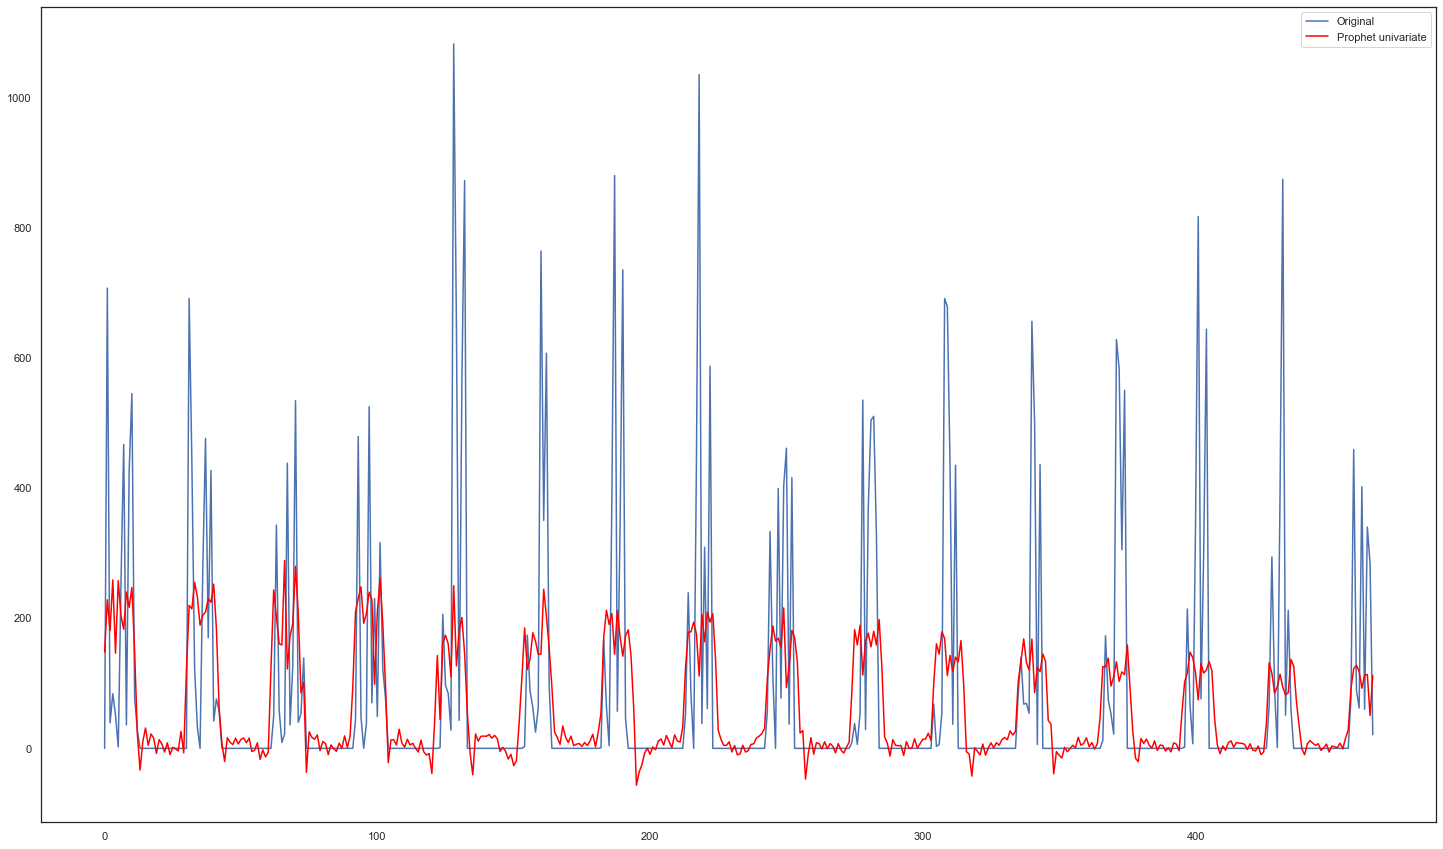

In [188]:
plt.plot(df_test.VALUES.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    
         Costruzione di un dataset multivariato per la time series


In [190]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [191]:
X_train_df, y_train = create_time_features(
    df_training, target='VALUES')
X_test_df, y_test = create_time_features(df_test, target='VALUES')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

C:\Users\ggudy\AppData\Local\Temp\ipykernel_6396\2000014208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
C:\Users\ggudy\AppData\Local\Temp\ipykernel_6396\2000014208.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df['date'].dt.quarter
C:\Users\ggudy\AppData\Local\Temp\ipykernel_6396\2000014208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

MODELLI AD ALBERO

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  

RANDOM FOREST
    
         Il random forest è un metodo di apprendimento collettivo per la classificazione o la regressione che opera costruendo una moltitudine di alberi decisionali al momento dell'addestramento. Per i compiti di classificazione, l'output del random forest è la classe selezionata dalla maggior parte degli alberi. Per i compiti di regressione, viene restituita la previsione media dei singoli alberi. Molto utile perchè gli alberi decisionali non trasmettono l'errore relativo nella valutazione


In [193]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.VALUES, yhat)
predictionsDict['Randomforest'] = yhat


7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  

XGBOOST
    
         Metodo di regressione che utilizza gli alberi di valutazione come il random forest, ma implementando una componente di boosting.
         Il boosting è un metodo d'insieme, ovvero un modo per combinare le previsioni di diversi modelli in uno solo.
         Lo fa prendendo ogni predittore in sequenza e modellandolo in base all'errore del suo predecessore (dando più peso ai predittori che hanno prestazioni migliori):

         1.Adatta un primo modello utilizzando i dati originali
         2.Adatta un secondo modello utilizzando i residui del primo modello.
         3.Crea un terzo modello utilizzando la somma dei modelli 1 e 2.
         Il Gradient Boosting è un tipo specifico di boosting, chiamato così perché minimizza la funzione di perdita utilizzando un algoritmo di gradient descent.






In [194]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.VALUES, yhat)
predictionsDict['XGBoost'] = yhat

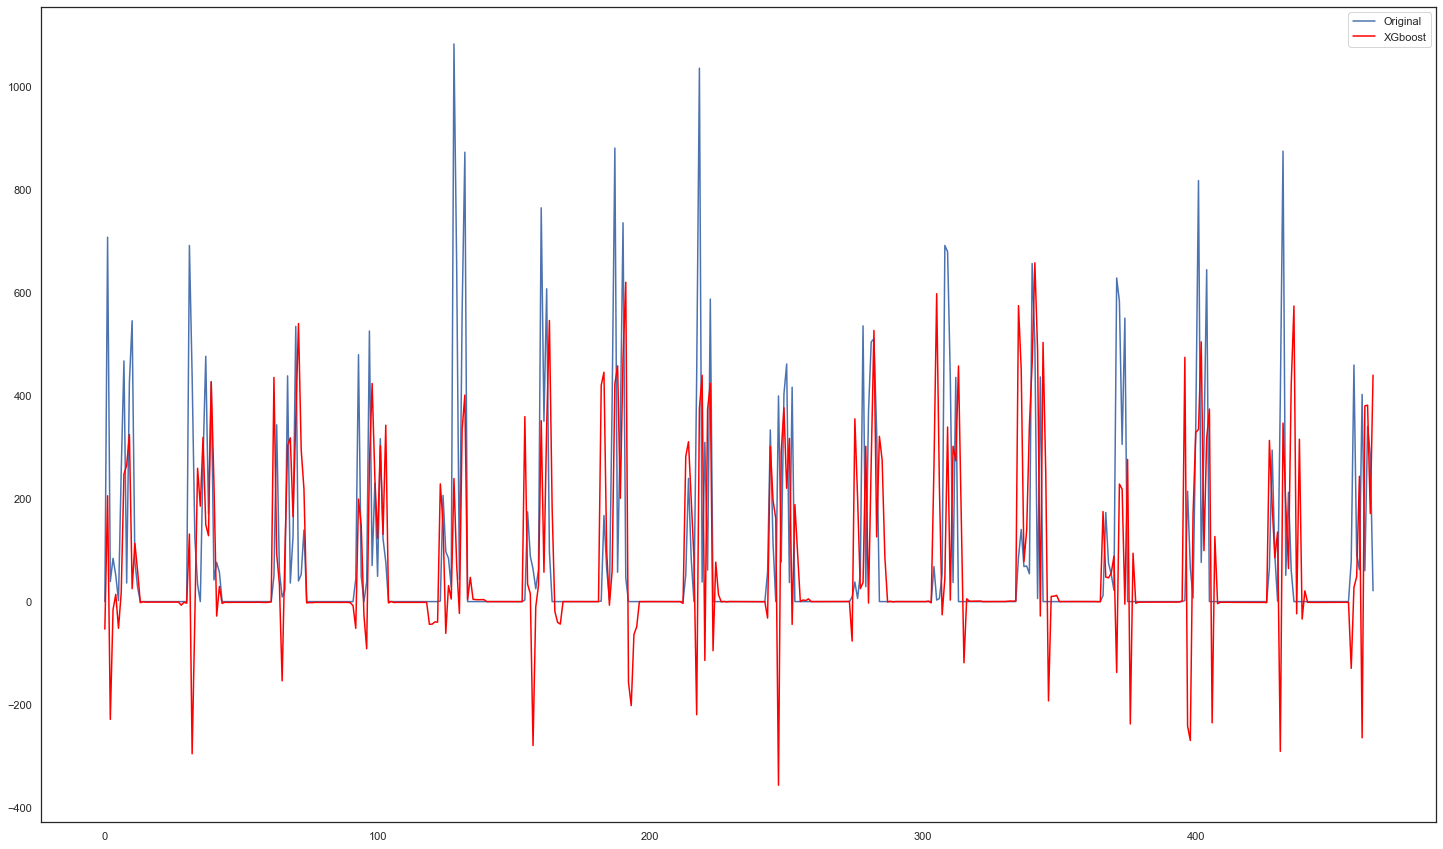

In [195]:
plt.plot(df_test.VALUES.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [205]:
models = ['Randomforest',
          'SARIMAX',
          'XGBoost',
          'ARIMA',
          'Prophet univariate',
          'HWES',
          'SES']
resis = pd.DataFrame(data={k: df_test.VALUES.values -
                     v for k, v in predictionsDict.items()})[models]
corr3 = resis.corr()
print("Residuals correlation")

Residuals correlation


Text(0.5, 1.0, 'Relation of forecasting models')

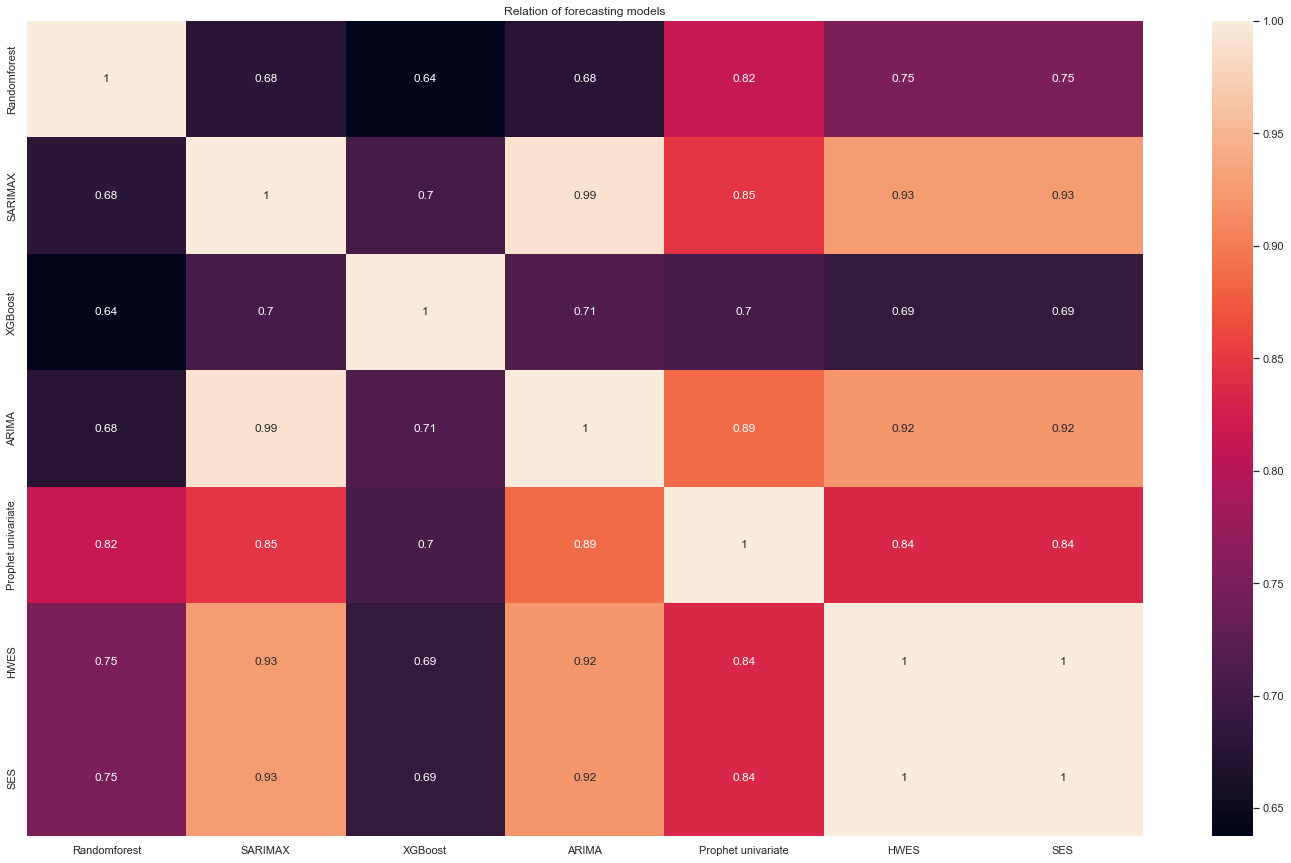

In [206]:
sns.set_theme (style = 'white')
heatmap = sns.heatmap(corr3, annot = True)
plt.title('Relation of forecasting models') #describing relation between regression models we have tested

In [207]:
resultsDict

{'SES': {'mae': 96.63231902621622,
  'rmse': 181.61570856841328,
  'mape': 262837716843.26187,
  'r2': 0.05028103465938616},
 'HWES': {'mae': 96.65029708418136,
  'rmse': 181.62303758070954,
  'mape': 262955940372.913,
  'r2': 0.0502043822324173},
 'ARIMA': {'mae': 112.50078797276525,
  'rmse': 174.8924784302066,
  'mape': 418056127030.0826,
  'r2': 0.11929480860425312},
 'AutoARIMA (4, 1, 2)': {'mae': 94.4297179004374,
  'rmse': 183.04710827623651,
  'mape': 250023568505.88513,
  'r2': 0.035251667352522276},
 'SARIMAX': {'mae': 81.4611214210943,
  'rmse': 181.9541931129425,
  'mape': 61003638790.76521,
  'r2': 0.046737676457691446},
 'Prophet univariate': {'mae': 84.195219821467,
  'rmse': 161.14071836240905,
  'mape': 164677208097.10394,
  'r2': 0.25234906183548866},
 'Randomforest': {'mae': 101.9406476255874,
  'rmse': 177.10481520958274,
  'mape': 221009006416.1009,
  'r2': 0.09687257589353537},
 'XGBoost': {'mae': 99.12256252858563,
  'rmse': 194.3084426753558,
  'mape': 148356478

7. - STUDIO DEL SETTORE RELATIVO ALLA RISTORAZIONE E CONSIDERAZIONI SUI RISULTATI DI DIFFERENTI MODELLI DI FORECASTING:  
    
         Studio con approccio relativo a time series mensile e auto sarima


In [208]:
attFrames[1]

In [213]:
attTimeSeRist = attFrames[1].iloc[:, [2]]
attTimeSeRist.rename(columns={'SETTORE': 'N.ATTIVATI'}, inplace=True)

In [214]:
attTimeSeRist

N.ATTIVATI
DATA                  
2010-01-31        2254
2010-02-28        2139
2010-03-31        1869
2010-04-30        1867
2010-05-31        2054
...                ...
2021-08-31        2016
2021-09-30        2401
2021-10-31        2467
2021-11-30        2042
2021-12-31        1796

[144 rows x 1 columns]

<AxesSubplot:xlabel='DATA'>

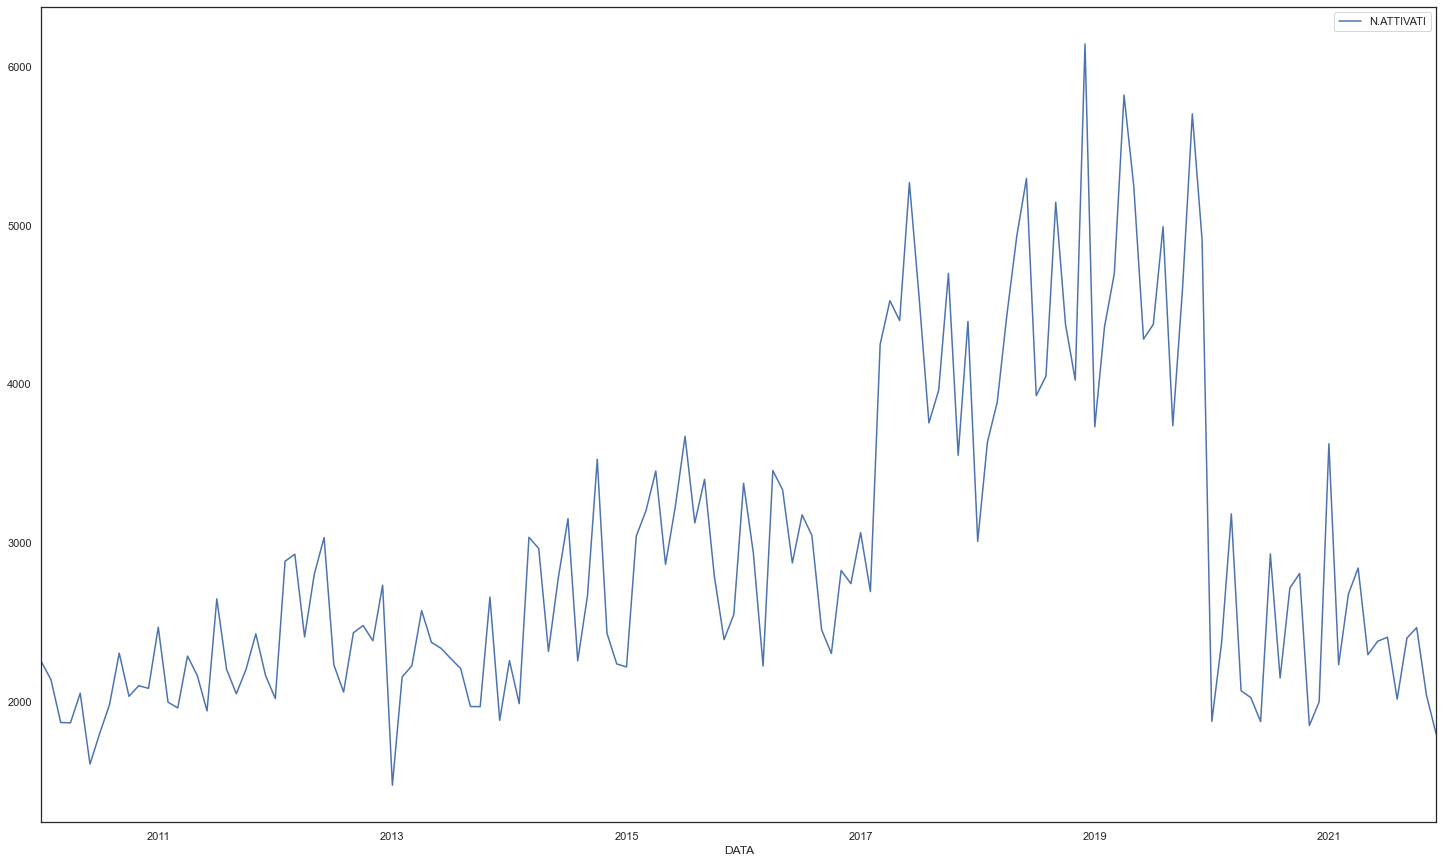

In [215]:
attTimeSeRist.plot()

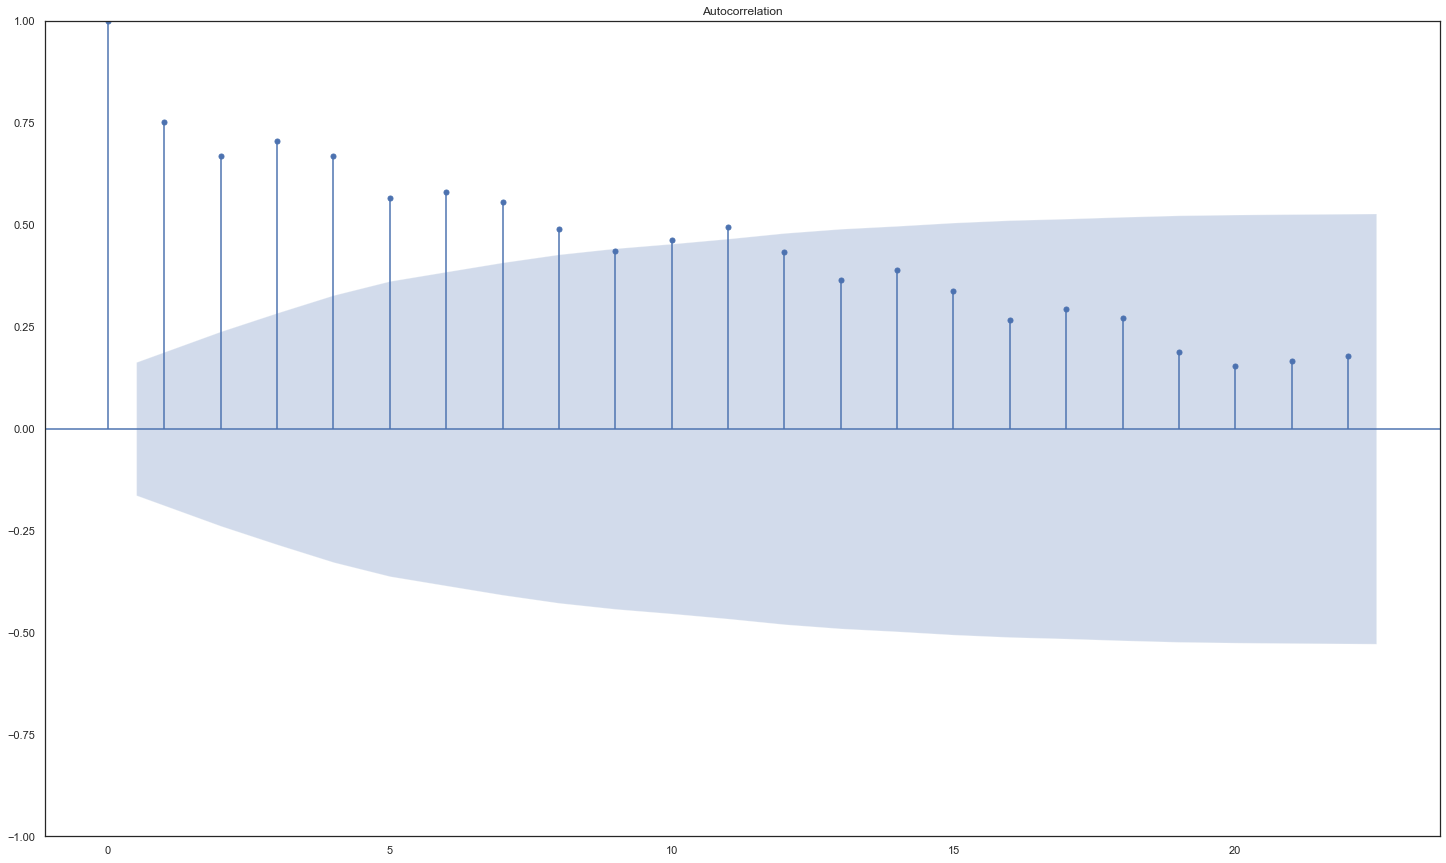

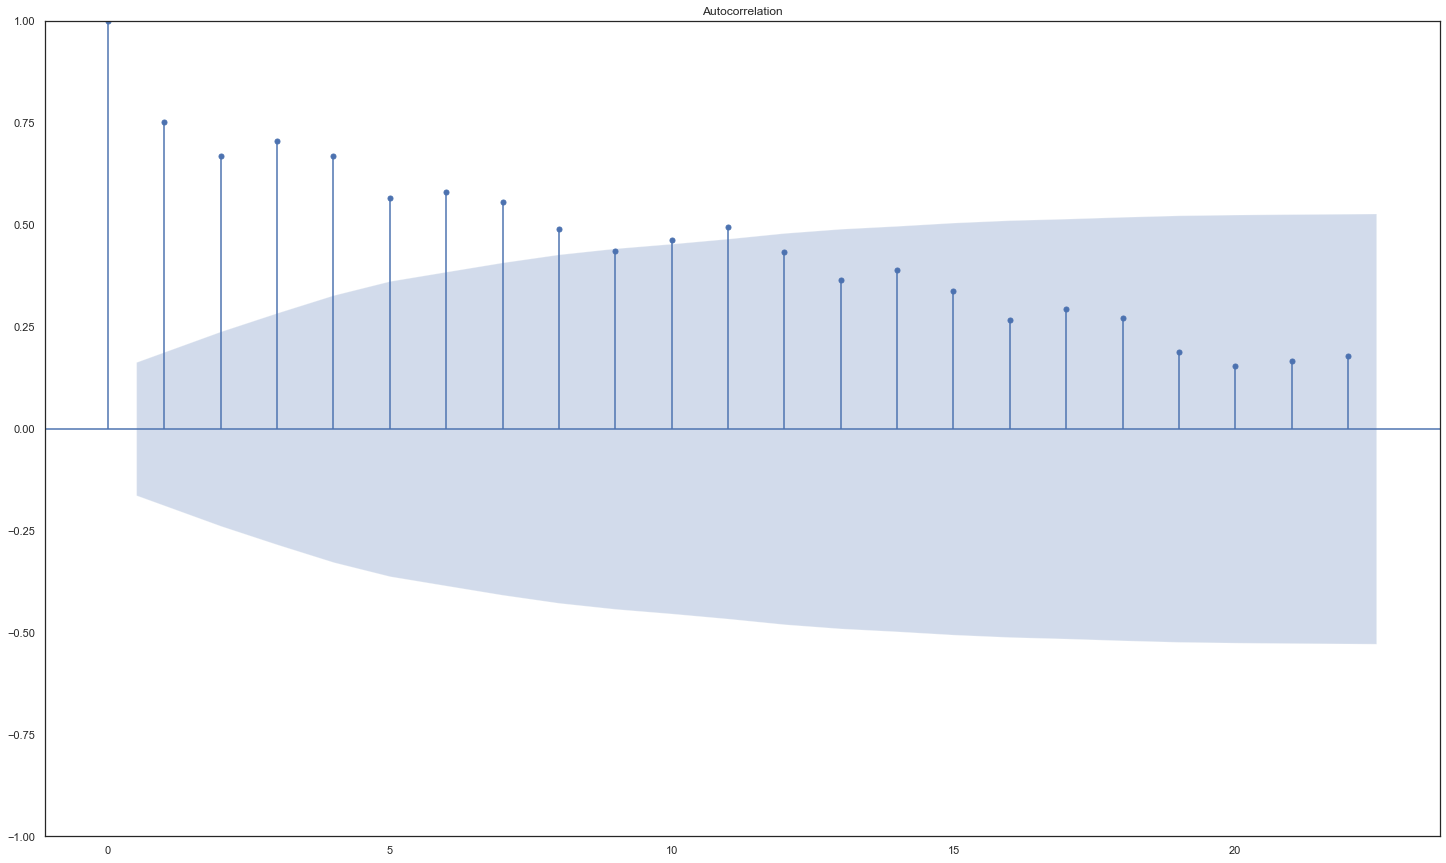

In [220]:
plot_acf(attTimeSeRist)

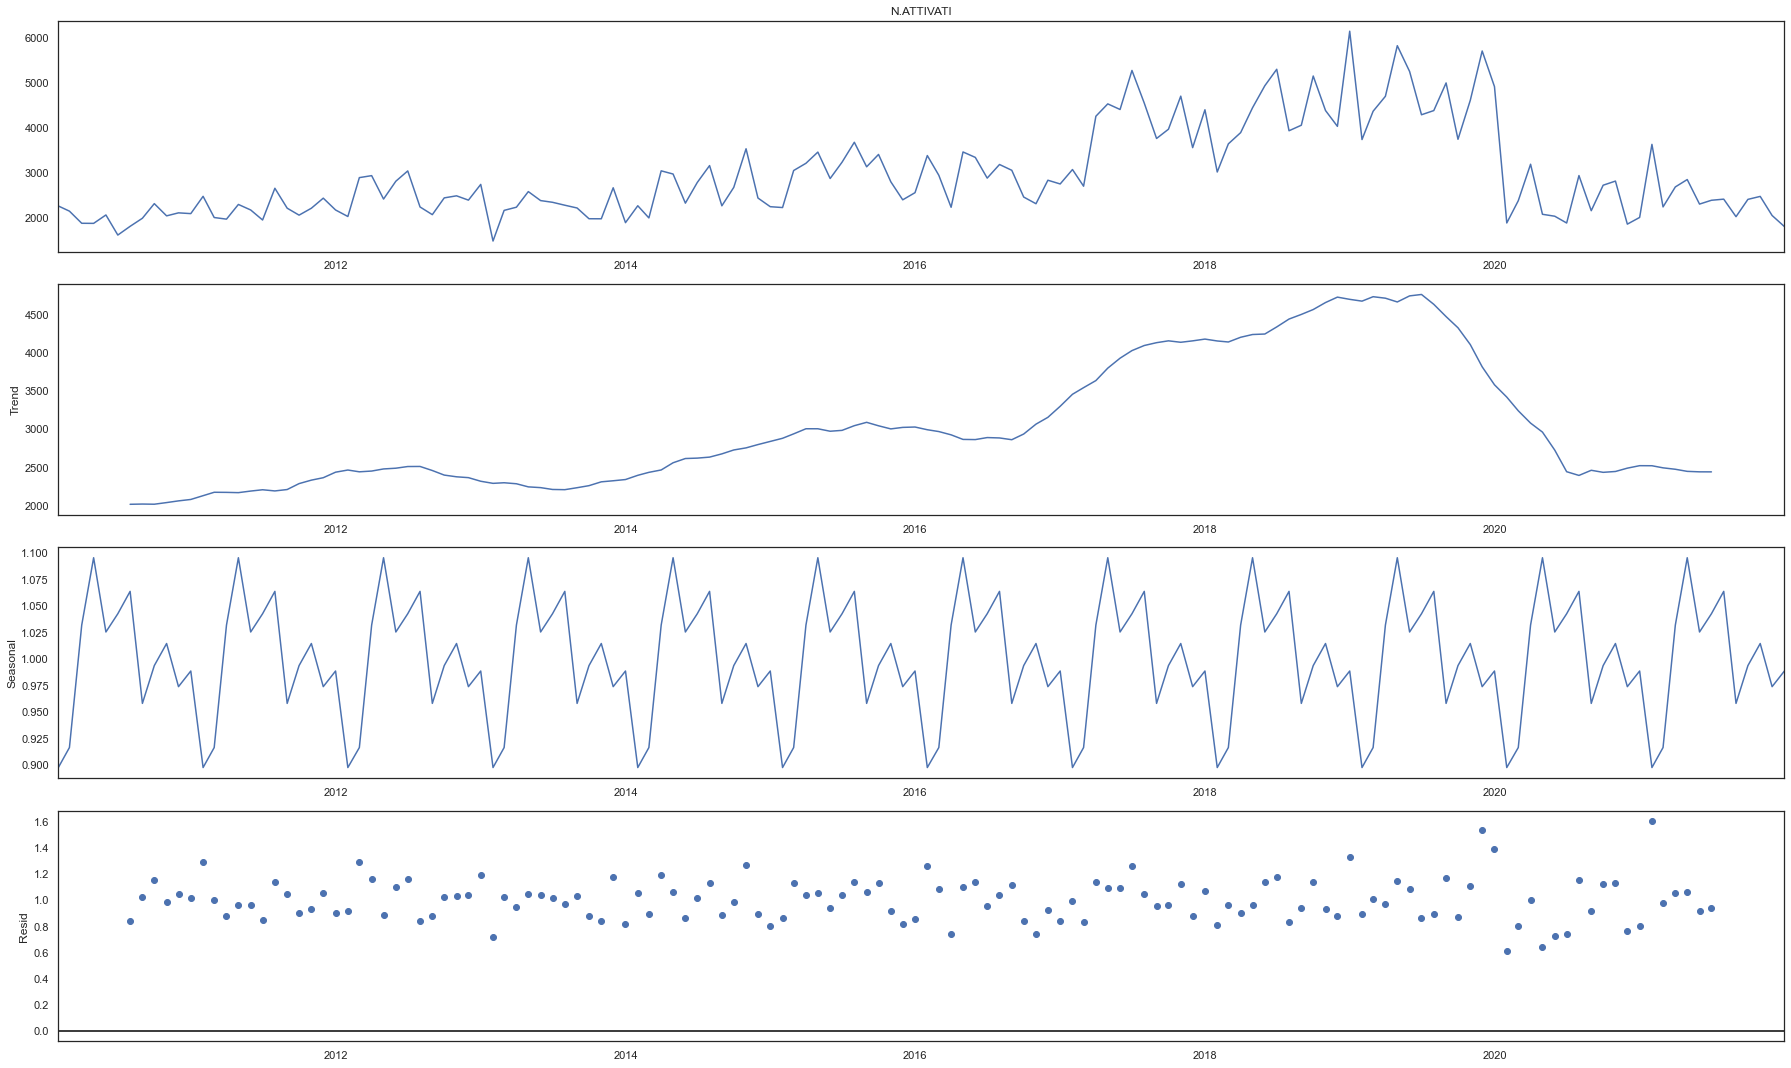

In [221]:

analysis = attTimeSeRist['N.ATTIVATI'].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [258]:
cwd = os.getcwd()
path = cwd + '/Ristorazione'
analysis.to_csv(path)

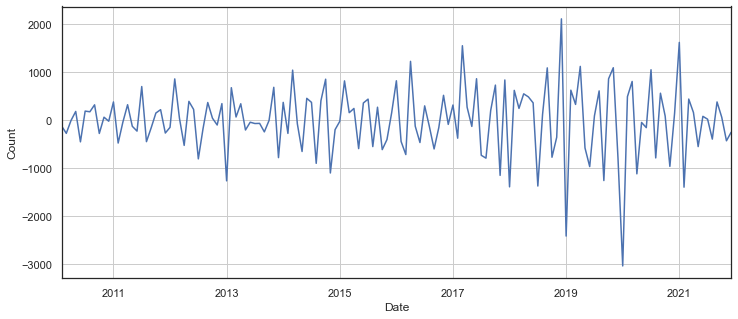

In [222]:
toStation = analysis.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = toStation.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
plt.grid(True)
plt.show()

In [223]:
test_result=adfuller(attTimeSeRist['N.ATTIVATI'])
adfuller_test(attTimeSeRist['N.ATTIVATI'])


ADF Test Statistic : -2.100352518908367
p-value : 0.24437287550497844
#Lags Used : 2
Number of Observations : 141


In [224]:
attTimeSeRist['Difference'] = attTimeSeRist['N.ATTIVATI'] - attTimeSeRist['N.ATTIVATI'].shift(1)
attTimeSeRist['Seasonal First Difference']=attTimeSeRist['N.ATTIVATI']-attTimeSeRist['N.ATTIVATI'].shift(12)
attTimeSeRist.head()

C:\Users\ggudy\AppData\Local\Temp\ipykernel_6396\1124636589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attTimeSeRist['Difference'] = attTimeSeRist['N.ATTIVATI'] - attTimeSeRist['N.ATTIVATI'].shift(1)
C:\Users\ggudy\AppData\Local\Temp\ipykernel_6396\1124636589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attTimeSeRist['Seasonal First Difference']=attTimeSeRist['N.ATTIVATI']-attTimeSeRist['N.ATTIVATI'].shift(12)


N.ATTIVATI  Difference  Seasonal First Difference
DATA                                                         
2010-01-31        2254         NaN                        NaN
2010-02-28        2139      -115.0                        NaN
2010-03-31        1869      -270.0                        NaN
2010-04-30        1867        -2.0                        NaN
2010-05-31        2054       187.0                        NaN

In [225]:
adfuller_test(attTimeSeRist ['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.3957124047674545
p-value : 0.5843299106614225
#Lags Used : 13
Number of Observations : 118


In [226]:
tfram4 = attTimeSeRist['N.ATTIVATI']

In [227]:

stepwise_model3 = auto_arima(tfram4, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model3.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2189.130, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2146.605, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2175.748, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2127.035, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2140.926, Time=1.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2107.443, Time=2.52 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2116.324, Time=0.61 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2106.696, Time=1.64 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2113.1

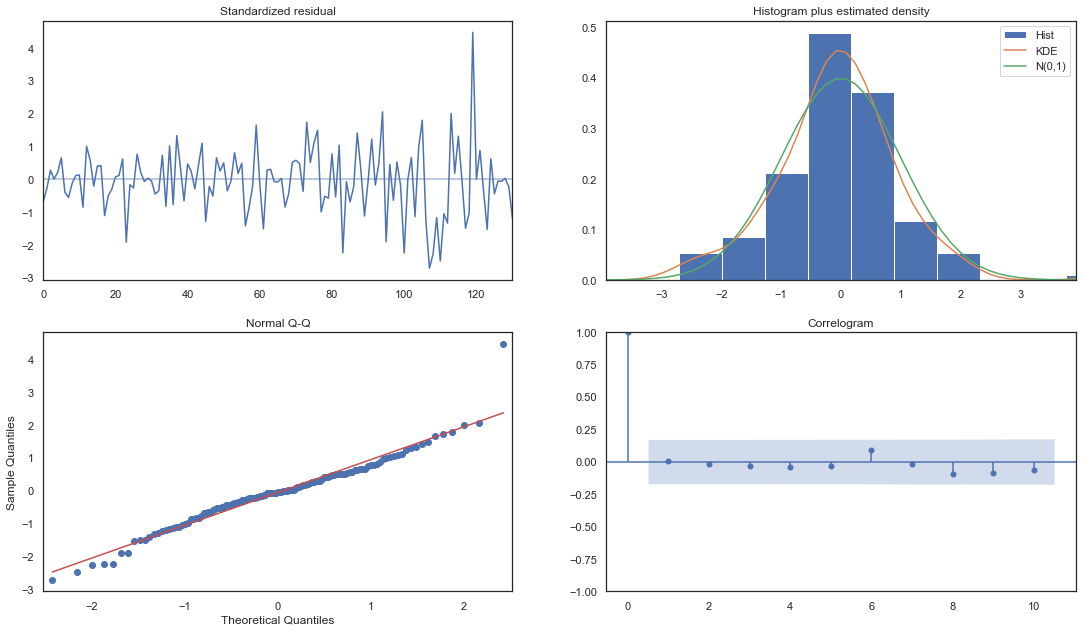

In [228]:
fig = stepwise_model3.plot_diagnostics()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

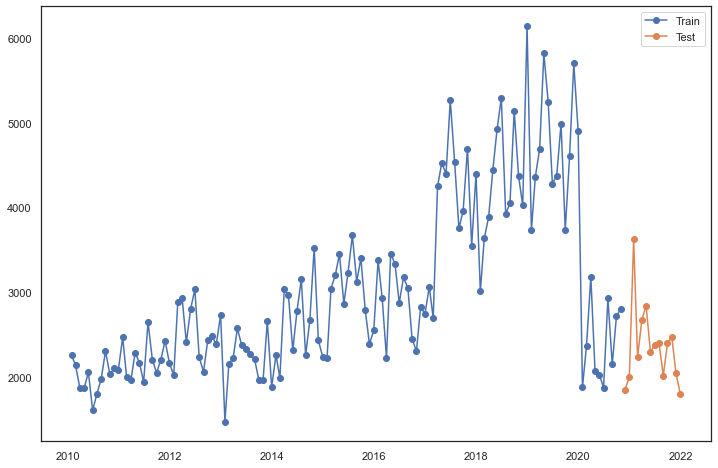

In [245]:
# Train Test Split Index
train_size = 0.9
split_idx = round(len(tfram4)* train_size)
split_idx

# Split
train3 = tfram4.iloc[:split_idx]
test3 = tfram4.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train3, label='Train', **kws)
plt.plot(test3, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [246]:
stepwise_model3.fit(train3)

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [249]:
future2, cf3 = stepwise_model3.predict(n_periods=14, return_conf_int=True)

In [250]:
future2 = pd.DataFrame(future2,index = test3.index, columns=['Prediction'])

<AxesSubplot:xlabel='DATA'>

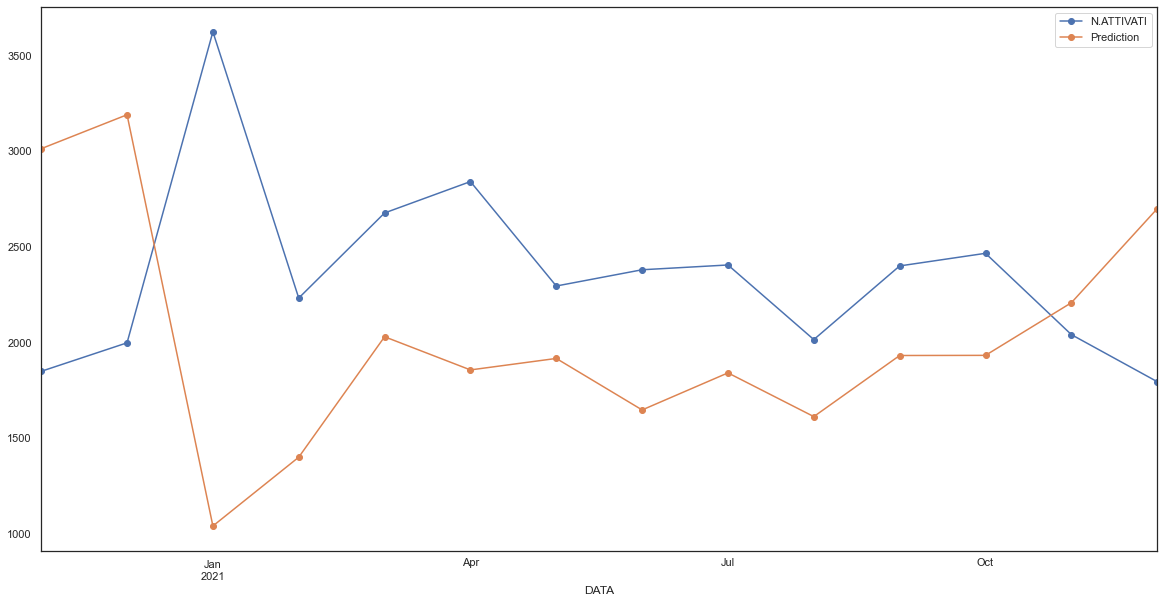

In [251]:
cc = pd.concat([test3,future2],axis=1)
cc.plot(**kwsnep, figsize=(20, 10))

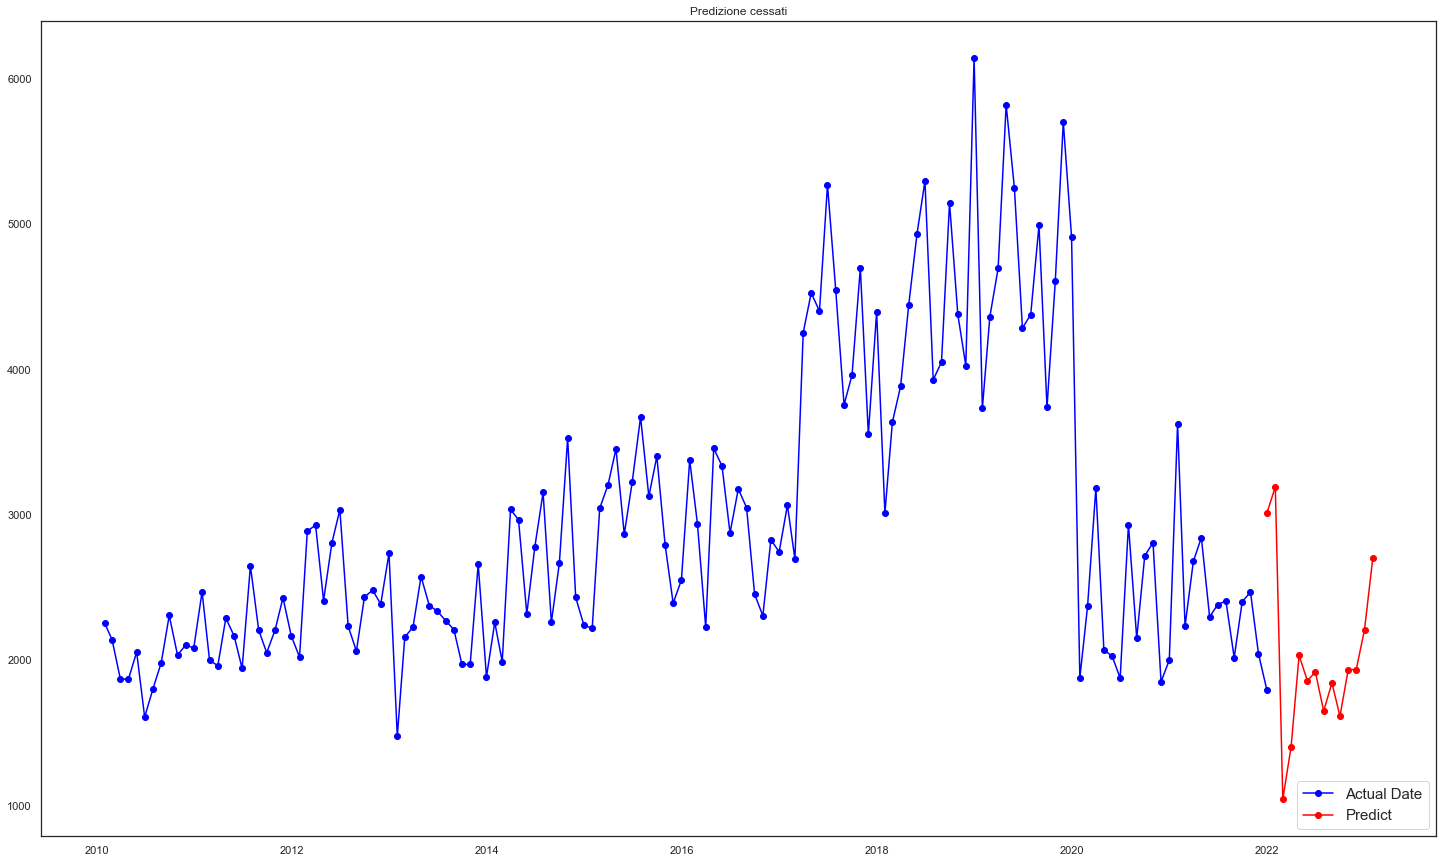

In [252]:
index_of2 = pd.date_range(tfram4.index[-1], periods = 14, freq='MS')

f = future2
f = f.set_index(index_of2)

# Plot Della prediction 
plt.figure(figsize=(25, 15))
plt.plot(tfram4, color='blue', label='Actual Date', **kwsn)
plt.plot(f, color='red', label='Predict', **kwsn)
plt.legend(loc='lower right', fontsize=15)
plt.title("Predizione cessati")
plt.show()

In [261]:
mape = mean_absolute_percentage_error(test3, f.Prediction)
print(mape)

0.3430122514976612


In [262]:
MSE = mean_squared_error(test3, f)
RMSE = math.sqrt(MSE)
print('The mean square error is: ', MSE)
print('The Root Mean Square error is: ', RMSE)

The mean square error is:  1002977.8325520398
The Root Mean Square error is:  1001.4878094874844
